In [2]:
# Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns
import statsmodels.formula.api as smf
import itertools
import math
import networkx as nx

## Movie data

movie.metadata.tsv.gz [3.4 M]
Metadata for 81,741 movies, extracted from November 4, 2012 dump of Freebase. Tab-separated; columns:
- Wikipedia movie ID
- Freebase movie ID
- Movie name
- Movie release date
- Movie box office revenue
- Movie runtime
- Movie languages (Freebase ID:name tuples)
- Movie countries (Freebase ID:name tuples)
- Movie genres (Freebase ID:name tuples)

In [241]:
# Load films
movies_header = ['wikipedia_id', 'freebase_id', 'name', 'release_date', 'box_office_revenue', 'runtime', 'languages', 'countries', 'genres']
movies = pd.read_csv('data/movie.metadata.tsv', sep='\t', header=None, names=movies_header)
movies.head(5)
print(movies.shape)
#movies['runtime'].hist()


(81741, 9)


In [242]:
movies.head(5)

,wikipedia_id,freebase_id,name,release_date,box_office_revenue,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [243]:
movies.describe()

,wikipedia_id,box_office_revenue,runtime
count,8.174100e+04,8.401000e+03,6.129100e+04
mean,1.740784e+07,4.799363e+07,1.118192e+02
std,1.098791e+07,1.121753e+08,4.360070e+03
min,3.300000e+02,1.000000e+04,0.000000e+00
25%,7.323695e+06,2.083193e+06,8.100000e+01
50%,1.777899e+07,1.063969e+07,9.300000e+01
75%,2.715573e+07,4.071696e+07,1.060000e+02
max,3.750192e+07,2.782275e+09,1.079281e+06


## Character data

character.metadata.tsv.gz [14 M]
Metadata for 450,669 characters aligned to the movies above, extracted from November 4, 2012 dump of Freebase. Tab-separated; columns:

- Wikipedia movie ID
- Freebase movie ID
- Movie release date
- Character name
- Actor date of birth
- Actor gender
- Actor height (in meters)
- Actor ethnicity (Freebase ID)
- Actor name
- Actor age at movie release
- Freebase character/actor map ID
- Freebase character ID
- Freebase actor ID

In [244]:
# Load characters
characters_header = ['wikipedia_movie_id','freebase_movie_id','movie_release_date','character_name','actor_birthdate','actor_gender','actor_height_meters','actor_ethnicity_freebase_id','actor_name','actor_age_at_movie_release','freebase_character_actor_map_id','freebase_character_id','freebase_actor_id']
characters = pd.read_csv('data/character.metadata.tsv', sep='\t', header=None, names=characters_header)
characters.sample(5)

,wikipedia_movie_id,freebase_movie_id,movie_release_date,character_name,actor_birthdate,actor_gender,actor_height_meters,actor_ethnicity_freebase_id,actor_name,actor_age_at_movie_release,freebase_character_actor_map_id,freebase_character_id,freebase_actor_id
428203,31240952,/m/0gjb9sf,2011-05-20,Sathya,1986-10-29,F,NaN,/m/01rv7x,Sridevi Vijaykumar,24.0,/m/0gj7l15,/m/0hb6195,/m/04n0p39
154338,22346977,/m/05s_vd6,1969-07-04,Franta Lampa,1927-08-11,M,NaN,NaN,Václav Babka,41.0,/m/0n584t5,/m/0n584t8,/m/07t408n
207657,21702693,/m/05mr00f,2007-08-20,Carl Ackland,1968-11-28,M,1.85,NaN,Steven Waddington,38.0,/m/05nxzx5,/m/0h76q11,/m/027tc0n
315149,21015620,/m/05b2s45,2009-04-24,Z,1984-02-15,M,NaN,NaN,Peter Anthony Tambakis,25.0,/m/0crt5cm,/m/0h5qz01,/m/02yx310
89665,11959704,/m/02rzp8w,1925-10-04,NaN,1899-10-20,F,NaN,NaN,Harriet Hammond,NaN,/m/040j1t0,NaN,/m/03cbk67


Let's map the wikipedia_movie_id to the movie name given in movies 'name' column

In [245]:
characters = characters.merge(movies[['wikipedia_id','name']], how='left', left_on='wikipedia_movie_id', right_on='wikipedia_id')
characters.drop('wikipedia_id', inplace=True, axis=1)

In [246]:
characters.head()

,wikipedia_movie_id,freebase_movie_id,movie_release_date,character_name,actor_birthdate,actor_gender,actor_height_meters,actor_ethnicity_freebase_id,actor_name,actor_age_at_movie_release,freebase_character_actor_map_id,freebase_character_id,freebase_actor_id,name
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,Ghosts of Mars
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,Ghosts of Mars
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,Ghosts of Mars
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,Ghosts of Mars
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,Ghosts of Mars


## Official IMDb dataset

This dataset includes all IMDb data. https://www.imdb.com/interfaces/

title.basics.tsv.gz
 - tconst (string) - alphanumeric unique identifier of the title
 - titleType (string) – the type/format of the title (e.g. movie, short, tvseries, tvepisode, video, etc)
 - primaryTitle (string) – the more popular title / the title used by the filmmakers on promotional materials at the point of release
 - originalTitle (string) - original title, in the original language
 - isAdult (boolean) - 0: non-adult title; 1: adult title
 - startYear (YYYY) – represents the release year of a title. In the case of TV Series, it is the series start year
 - endYear (YYYY) – TV Series end year. ‘\N’ for all other title types
 - runtimeMinutes – primary runtime of the title, in minutes
 - genres (string array) – includes up to three genres associated with the title

title.ratings.tsv.gz
 - tconst (string) - alphanumeric unique identifier of the title
 - averageRating – weighted average of all the individual user ratings
 - numVotes - number of votes the title has received

title.crew.tsv.gz
 - tconst (string) - alphanumeric unique identifier of the title
 - directors (array of nconsts) - director(s) of the given title
 - writers (array of nconsts) – writer(s) of the given title

name.basics.tsv.gz: information of actors
 - nconst (string) - alphanumeric unique identifier of the name/person
 - primaryName (string)– name by which the person is most often credited
 - birthYear – in YYYY format
 - deathYear – in YYYY format if applicable, else '\N'
 - primaryProfession (array of strings)– the top-3 professions of the person
 - knownForTitles (array of tconsts) – titles the person is known for

In [247]:
imdb_titles = pd.read_csv('./data/imdb/imdb_titles.tsv', na_values='\\N', sep='\t')
imdb_ratings = pd.read_csv('./data/imdb/imdb_ratings.tsv', na_values='\\N', sep='\t')
imdb_crew = pd.read_csv('./data/imdb/imdb_crew.tsv', na_values='\\N', sep='\t')
imdb_people = pd.read_csv('./data/imdb/imdb_people.tsv', na_values='\\N', sep='\t')

In [248]:
imdb_titles.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894.0,NaN,1.0,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892.0,NaN,5.0,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892.0,NaN,4.0,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892.0,NaN,12.0,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893.0,NaN,1.0,"Comedy,Short"


In [249]:
imdb_ratings.head()

,tconst,averageRating,numVotes
0,tt0000001,5.7,1923
1,tt0000002,5.8,260
2,tt0000003,6.5,1738
3,tt0000004,5.6,175
4,tt0000005,6.2,2553


In [250]:
imdb_crew.head()

,tconst,directors,writers
0,tt0000001,nm0005690,NaN
1,tt0000002,nm0721526,NaN
2,tt0000003,nm0721526,NaN
3,tt0000004,nm0721526,NaN
4,tt0000005,nm0005690,NaN


In [251]:
imdb_people.head()

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,nm0000001,Fred Astaire,1899.0,1987.0,"soundtrack,actor,miscellaneous","tt0031983,tt0072308,tt0053137,tt0050419"
1,nm0000002,Lauren Bacall,1924.0,2014.0,"actress,soundtrack","tt0071877,tt0037382,tt0038355,tt0117057"
2,nm0000003,Brigitte Bardot,1934.0,NaN,"actress,soundtrack,music_department","tt0054452,tt0049189,tt0057345,tt0056404"
3,nm0000004,John Belushi,1949.0,1982.0,"actor,soundtrack,writer","tt0077975,tt0078723,tt0080455,tt0072562"
4,nm0000005,Ingmar Bergman,1918.0,2007.0,"writer,director,actor","tt0083922,tt0060827,tt0050986,tt0050976"


In [252]:
imdb_people.describe()

,birthYear,deathYear
count,568354.000000,208794.000000
mean,1952.249489,1991.615310
std,34.844203,34.748459
min,4.000000,17.000000
25%,1931.000000,1978.000000
50%,1959.000000,2000.000000
75%,1978.000000,2013.000000
max,2022.000000,2022.000000


## IMDB budget data:

This dataset includes the ratings for 3828 IMDB movies. 
source: https://github.com/jeremy-lee93/dsc-mod-1-project-v2-1-onl01-dtsc-pt-052620/blob/master/IMDb_budgets.csv

- Movie:  Title of movie
- Year: Movie release year
- IMDb: IMDB rating over 10
- Rating: Certificate
- Runtime [min]
- Genre
- Release Date: Movie release date
- Production Budget: Budget spent for production of the movie
- Domestic Gross: Gross revenue in US and Canada for all time
- Worldwide Gross: Worldwide gross revenue for all time

In [253]:
imdb_budget = pd.read_csv('data/imdb/IMDb_budgets.csv')

In [254]:
imdb_budget.sample(5)

,Movie,Year,IMDb,Rating,Runtime,Genre,Release Date,Production Budget,Domestic Gross,Worldwide Gross
792,The Mummy,2017,5.4,PG-13,110,"Action, Adventure, Fantasy","Jun 2, 2017",195000000,80101125,409953905
2130,Blood Work,2002,6.4,R,110,"Action, Crime, Drama","Aug 9, 2002",50000000,26199517,26199517
2734,Dredd,2012,7.1,R,95,"Action, Crime, Sci-Fi","Sep 7, 2012",45000000,13414714,41467606
3047,Strangers on a Train,1951,8.0,PG,101,"Crime, Film-Noir, Thriller","Jul 3, 1951",1200000,7000000,7020059
3235,Snowpiercer,2013,7.1,R,126,"Action, Drama, Sci-Fi","Aug 1, 2013",40000000,4563029,86808205


In [255]:
imdb_budget.describe()

,Year,IMDb,Runtime,Production Budget,Domestic Gross,Worldwide Gross
count,3828.000000,3828.000000,3828.000000,3.828000e+03,3.828000e+03,3.828000e+03
mean,2003.594044,6.459013,109.940439,4.030960e+07,5.559021e+07,1.206910e+08
std,12.767740,0.996623,20.219674,4.480927e+07,7.403263e+07,1.993646e+08
min,1925.000000,1.500000,63.000000,7.000000e+03,0.000000e+00,0.000000e+00
25%,1999.000000,5.900000,96.000000,1.100000e+07,1.180967e+07,1.690363e+07
50%,2006.000000,6.500000,106.000000,2.500000e+07,3.225471e+07,5.077617e+07
75%,2013.000000,7.100000,120.000000,5.000000e+07,6.848642e+07,1.388776e+08
max,2020.000000,9.300000,271.000000,4.000000e+08,8.583730e+08,2.797801e+09


## Wikipedia

Wikipedia page views statistics
source: this data is crowed from the wikimedia API by the ./utils/wikipedia_pageview_statistics.py script
    
- `name`: Title of a movie
- `pageviews`: Number of page views for a movie with a `name`. The value is an weighted aggregation for the pageviews for the period between 01/12/2021 and 30/11/2022. The weight is computed with this formula - `weight = 1 + ((2022 - movie_release_year) / (2022 - min_movie_year))`. The aggregation is accomplished by the `mean` function.

In [256]:
wikipedia_pageviews = pd.read_csv('./handled_data/movies_wikipedia_pageviews.csv')

In [257]:
wikipedia_pageviews.sample(5)

,name,pageviews
8918,Crazy Cruise,226.510870
30888,Raakuyil,39.403080
29487,Phandebaaz,NaN
28356,Onkel Joakims hemmelighed,25.040761
19577,Kabhi Pyar Na Karna,306.008893


# Cleaning & Pre-processing of data

In [258]:
movies.describe()

,wikipedia_id,box_office_revenue,runtime
count,8.174100e+04,8.401000e+03,6.129100e+04
mean,1.740784e+07,4.799363e+07,1.118192e+02
std,1.098791e+07,1.121753e+08,4.360070e+03
min,3.300000e+02,1.000000e+04,0.000000e+00
25%,7.323695e+06,2.083193e+06,8.100000e+01
50%,1.777899e+07,1.063969e+07,9.300000e+01
75%,2.715573e+07,4.071696e+07,1.060000e+02
max,3.750192e+07,2.782275e+09,1.079281e+06


In [259]:
characters.describe()

,wikipedia_movie_id,actor_height_meters,actor_age_at_movie_release
count,4.506690e+05,154824.000000,292556.000000
mean,1.396975e+07,1.788893,37.788523
std,1.079662e+07,4.379940,20.587870
min,3.300000e+02,0.610000,-7896.000000
25%,3.759292e+06,1.676400,28.000000
50%,1.189065e+07,1.750000,36.000000
75%,2.366501e+07,1.830000,47.000000
max,3.750192e+07,510.000000,103.000000


In [260]:
# Function to remove encoding: 
remove_encoding = lambda x: np.nan if x == '{}' else \
    [w.replace(' Language', '').replace(' language', '') for w in re.findall(r'"(.*?)"', x)[1::2]]

In [261]:
movies['genres'] = movies['genres'].apply(remove_encoding)
movies['languages'] = movies['languages'].apply(remove_encoding)
movies['countries'] = movies['countries'].apply(remove_encoding)
movies.head()

,wikipedia_id,freebase_id,name,release_date,box_office_revenue,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,[English],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]"
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,[Norwegian],[Norway],"[Crime Fiction, Drama]"
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German],[Germany],[Drama]


In [262]:
movies['countries'].apply(np.shape).min()

()

### Clean release dates

In [263]:
# Replace string 'release_date' column with 3 float columns ['release_year','release_month','release_day']

movies['release_date'] = movies['release_date'].astype('str') # Convert to string all dates
release_date = pd.DataFrame(movies['release_date'].str.split('-', expand=True).values, columns=['release_year','release_month','release_day']) # Split between days, months and year
movies[['release_year','release_month','release_day']] = release_date
movies = movies.drop('release_date', axis=1)


In [264]:
movies.head()

,wikipedia_id,freebase_id,name,box_office_revenue,runtime,languages,countries,genres,release_year,release_month,release_day
0,975900,/m/03vyhn,Ghosts of Mars,14010832.0,98.0,[English],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",2001,08,24
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,NaN,95.0,[English],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",2000,02,16
2,28463795,/m/0crgdbh,Brun bitter,NaN,83.0,[Norwegian],[Norway],"[Crime Fiction, Drama]",1988,None,None
3,9363483,/m/0285_cd,White Of The Eye,NaN,110.0,[English],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",1987,None,None
4,261236,/m/01mrr1,A Woman in Flames,NaN,106.0,[German],[Germany],[Drama],1983,None,None


### Remove data that is out of this world 

In [265]:
def replace_outliers_with_nan(df, col, possible_range):
    df[col] = df[col].apply(lambda x: np.nan if x < possible_range[0] or x > possible_range[1] else x)

#### Movies

In [266]:
possible_movie_runtime_range = [0, 85 * 60] # 85 hours is the Guinness World Record for the longest movie - The Cure for Insomnia

In [267]:
replace_outliers_with_nan(movies, 'runtime', possible_movie_runtime_range)

In [268]:
movies.describe()

,wikipedia_id,box_office_revenue,runtime
count,8.174100e+04,8.401000e+03,61286.000000
mean,1.740784e+07,4.799363e+07,93.651871
std,1.098791e+07,1.121753e+08,51.513103
min,3.300000e+02,1.000000e+04,0.000000
25%,7.323695e+06,2.083193e+06,81.000000
50%,1.777899e+07,1.063969e+07,93.000000
75%,2.715573e+07,4.071696e+07,106.000000
max,3.750192e+07,2.782275e+09,5100.000000


In [269]:
movies[movies['runtime'] == 0]

,wikipedia_id,freebase_id,name,box_office_revenue,runtime,languages,countries,genres,release_year,release_month,release_day
42478,786716,/m/03c6bq,Dickson Experimental Sound Film,NaN,0.0,[English],[United States of America],[Short Film],1894,None,None


The real length of Dickson Experimental Sound Film is 17 seconds which rounded to minutes is 0.

#### Characters

Remove age and height that are incorrect or corrupted

In [270]:
possible_age_range = (0, 150)
possible_height_range = (0, 3)

In [271]:
replace_outliers_with_nan(characters, 'actor_age_at_movie_release', possible_age_range)
replace_outliers_with_nan(characters, 'actor_height_meters', possible_height_range)

A very important characteristic describing the characters is their ethnicity. In the original dataset only the freebase id referring to the ethnicity was available. Thus, a script that can be found in `utils/ethnicities_freebase_ids_script.py` has been created to relate it to the actual labels (p.e. '/m/0152s7' stands for 'Anglo-Irish people'). A CSV has been created to map the ids and the labels, it can be found in `handled_data/ethnicities_freebase_ids.csv`. This is how it looks like:Add ethnicity labels using the freebase ethnicity ids

In [272]:
ethnicity_freebase_ids = pd.read_csv('handled_data/ethnicities_freebase_ids.csv')
ethnicity_freebase_ids.head(5)

,ethnicity_freebase_id,ethnicity_label
0,/m/01267,Albanians
1,/m/012c1l,French Canadians
2,/m/012f86,Ukrainians
3,/m/012fh,Afrikaners
4,/m/01336l,Asian Americans


As it can be seen, the ethnicities are extremely specific and it is very difficult to extract some conclusions. Therefore, we grouped all ethnicities that are repeated more than 10 times into five main ethnic groups: Asian, Black, Latino, Indian and White. This classification can be found in the CSV document in `handled_data/major_ethnicities_clustering.csv`. This is how it looks like:

In [273]:
major_ethnicities = pd.read_csv('handled_data/major_ethnicities_clustering.csv',sep=',');
major_ethnicities.head(10)

,ethnicity_label,major_ethnicity
0,African Americans,Black
1,American Jews,White
2,Americans,White
3,Argentines,Latino
4,Ashkenazi Jews,White
5,Asian Americans,Asian
6,Asian people,Asian
7,Australians,White
8,Austrians,White
9,Bengali people,Indian


Next step is to merge this two tables into the characters main dataframe

In [274]:
characters = pd.merge(characters, ethnicity_freebase_ids, how='left', left_on='actor_ethnicity_freebase_id', right_on='ethnicity_freebase_id')
characters.drop('ethnicity_freebase_id', inplace=True, axis=1)
characters = pd.merge(characters, major_ethnicities, how='left', on='ethnicity_label')

Finally, this the characters main data frame in which we are working

In [275]:
characters.sample(5)

,wikipedia_movie_id,freebase_movie_id,movie_release_date,character_name,actor_birthdate,actor_gender,actor_height_meters,actor_ethnicity_freebase_id,actor_name,actor_age_at_movie_release,freebase_character_actor_map_id,freebase_character_id,freebase_actor_id,name,ethnicity_label,major_ethnicity
381002,26675487,/m/0bmbyxr,2001-05-09,NaN,1947-07-10,M,NaN,NaN,Srinivasa Rao Kota,53.0,/m/0bmzx6r,NaN,/m/02ql_ms,Prematho Raa,NaN,NaN
61279,1134919,/m/04984j,1980-06-20,Emmeline Lestrange,1965-05-31,F,1.830,/m/01qhm_,Brooke Shields,15.0,/m/0k4jmy,/m/059wj30,/m/0bx_q,The Blue Lagoon,German Americans,NaN
437243,3497365,/m/09gqrp,1976-04-23,Dorothy Stephens,NaN,F,NaN,NaN,Kathleen Miller,NaN,/m/0ch7s01,/m/0ch7s04,/m/05yp0pr,Stay Hungry,NaN,NaN
306464,2827852,/m/0858d3,1994,NaN,1966-03-26,M,1.727,/m/0xnvg,Michael Imperioli,27.0,/m/0cg3w16,NaN,/m/02lfcm,Amateur,Italian Americans,White
121453,16888240,/m/04115ny,1967,Zykov,NaN,M,NaN,NaN,Pyotr Chernov,NaN,/m/0cgr3kr,/m/0cgr3kv,/m/09_2kky,Sedmoy Sputnik,NaN,NaN


In [276]:
characters.describe()

,wikipedia_movie_id,actor_height_meters,actor_age_at_movie_release
count,4.536250e+05,157666.000000,294959.000000
mean,1.393780e+07,1.747917,37.925895
std,1.079782e+07,0.106067,14.096938
min,3.300000e+02,0.610000,0.000000
25%,3.738820e+06,1.676400,28.000000
50%,1.180718e+07,1.750000,36.000000
75%,2.362455e+07,1.830000,47.000000
max,3.750192e+07,2.356000,103.000000


### IMDB

In [277]:
def split_list(df, column_name, sep=','):
    df[column_name] = df[column_name].replace(np.nan, '').apply(lambda x: x.split(sep))

In [278]:
def fill_na_with_list(df, column_name):
    df[column_name] = df[column_name].fillna('').apply(list)

In [279]:
split_list(imdb_crew, 'directors')
split_list(imdb_crew, 'writers')
split_list(imdb_titles, 'genres')

In [280]:
imdb_people_dict = dict(zip(imdb_people['nconst'], imdb_people['primaryName']))

In [281]:
imdb_crew['directors'] = imdb_crew['directors'].apply(lambda _list: [imdb_people_dict[el] for el in _list if el in imdb_people_dict])

In [282]:
imdb_crew['writers'] = imdb_crew['writers'].apply(lambda _list: [imdb_people_dict[el] for el in _list if el in imdb_people_dict])

In [283]:
imdb = pd.merge(pd.merge(imdb_titles, imdb_ratings, how='inner', on='tconst'), imdb_crew, how='inner', on='tconst')

In [284]:
# Free memory
del imdb_titles
del imdb_ratings
del imdb_crew

In [285]:
imdb.sample(5)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes,directors,writers
647695,tt1426805,tvEpisode,Exploding Bumpers,Exploding Bumpers,0,2009.0,NaN,43.0,"[Documentary, Mystery, Reality-TV]",7.2,109,"[Alice Dallow, Tabitha Lentle]",[]
366810,tt0746239,tvEpisode,The Hat Comes Back,The Hat Comes Back,0,1987.0,NaN,NaN,[Comedy],7.5,11,[Gary Shimokawa],"[Barry Gurstein, David Pitlik]"
908677,tt3004676,tvMiniSeries,Banshee Origins: The Forge,Banshee Origins: The Forge,0,2013.0,NaN,NaN,[Drama],8.0,14,[],"[David Schickler, Jonathan Tropper]"
1027878,tt4970956,tvSpecial,WWE Night of Champions,WWE Night of Champions,0,2015.0,NaN,161.0,[Sport],6.5,322,[Kevin Dunn],[]
1109069,tt6333184,tvEpisode,Ragnar and His Sons,Ragnar and His Sons,0,2016.0,NaN,43.0,[Documentary],7.4,24,[],[]


In [286]:
imdb.describe()

,isAdult,startYear,endYear,runtimeMinutes,averageRating,numVotes
count,1.253452e+06,1.253191e+06,41948.000000,901787.000000,1.253452e+06,1.253452e+06
mean,1.551795e-02,2.001829e+03,2005.704777,56.207179,6.952086e+00,1.041908e+03
std,1.236008e-01,2.125113e+01,15.357264,96.507384,1.388000e+00,1.729051e+04
min,0.000000e+00,1.874000e+03,1933.000000,0.000000,1.000000e+00,5.000000e+00
25%,0.000000e+00,1.995000e+03,1998.000000,23.000000,6.200000e+00,1.200000e+01
50%,0.000000e+00,2.009000e+03,2011.000000,45.000000,7.100000e+00,2.600000e+01
75%,0.000000e+00,2.016000e+03,2018.000000,86.000000,7.900000e+00,1.010000e+02
max,1.000000e+00,2.022000e+03,2024.000000,51420.000000,1.000000e+01,2.667015e+06


### Weighted IMDB rating

To estimate a movie success, we need to both account for the rating 'averageRating' and to the correponding number of votes 'numVotes'. To do so, we build a new weighted rating based on a shrinkage estimator: 

weighted rating (WR) = (v ÷ (v+m)) × R + (m ÷ (v+m)) × C 

where:

R = average for the movie (mean) = (Rating)

v = number of votes for the movie = (votes)

m = minimum votes required to be listed (currently 25088)

C = the mean vote across the whole report (currently 7.94)

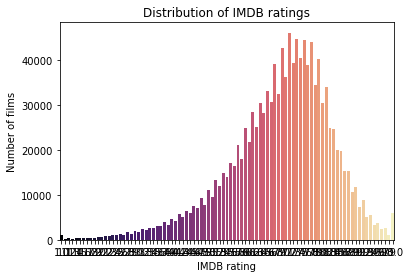

In [287]:
_ = sns.countplot(x='averageRating', data=imdb, palette="magma") \
   .set(title='Distribution of IMDB ratings', xlabel='IMDB rating', ylabel='Number of films')

In [288]:
C = imdb['averageRating'].mean()
m = imdb['numVotes'].min()
v = imdb['numVotes']
R = imdb['averageRating']

In [289]:
imdb['WR'] = (v / (v + m)) * R + (m / (v + m)) * C # Complete original dataset


To check if the weighted rating has worked, we display below the best rated movie. We observe that for an IMDB rating of 9/10, the weighted rating WR is better for movies with the most votes. We conclude that this weighted rating is more representative of a movie' success.

In [290]:
imdb[['originalTitle', 'averageRating', 'WR', 'numVotes']].sort_values('WR', ascending=False).head()

,originalTitle,averageRating,WR,numVotes
853340,Ozymandias,10.0,9.999918,185650
1000173,Unbreakable Souls,10.0,9.993245,2251
1023521,Angels Apocalypse,10.0,9.992627,2062
749029,Final Draft,10.0,9.978922,718
308511,Episode #1.9,10.0,9.975694,622


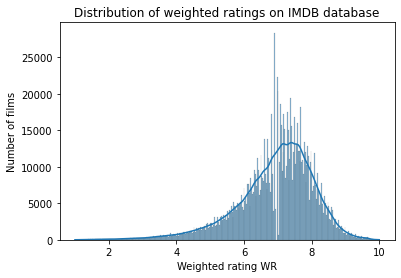

In [291]:
_ = sns.histplot(x='WR', data=imdb, kde=True) \
   .set(title='Distribution of weighted ratings on IMDB database', xlabel='Weighted rating WR', ylabel='Number of films')

### Merge IMDB database with movie database to have common features

We would like to merge the data from CMU movies and IMDB top 1000. Since we don't want to reduce the size of data, we would rather to an outer merge and fill missing values with NaN.

In [292]:
len((imdb['originalTitle'] + imdb['startYear'].astype(str)).unique()) / len(imdb)

0.9297141015371949

In [293]:
imdb.drop_duplicates(subset=['originalTitle', 'startYear'], inplace=True)

In [294]:
len((movies['name'] + movies['release_year'].astype(str)).unique()) / len(movies)

0.9977122863679182

In [295]:
# Remove duplicated movie with video game
movies.drop(movies[movies['wikipedia_id'] == 3184269].index, inplace=True)
# Fix duplicated movie with changing it release year to the correct one based on its wikipedia page
movies.loc[movies['wikipedia_id'] == 25357930, ['release_year']] = "2010"

In [296]:
movies.drop_duplicates(subset=['name', 'release_year'], inplace=True)

In [297]:
imdb.rename({'originalTitle': 'name', 'startYear': 'release_year'}, axis=1, inplace=True)

In [298]:
movies['release_year'] = movies['release_year'].replace('nan', np.nan).astype('float32')
movies['release_month'] = movies['release_month'].replace('nan', np.nan).astype('float32')
movies['release_day'] = movies['release_day'].replace('nan', np.nan).astype('float32')

In [299]:
movie_feature = movies.merge(imdb, on=['name', 'release_year'], how='left')

In [300]:
# Free memory
del imdb
del movies

In [301]:
def fill_NaN(df, column_left, column_right, column_name=None): # Updates missing data from left column with right column data
    if column_name is None:
        column_name = column_left
    df[column_name] = df[column_left].fillna(df[column_right])

In [302]:
fill_NaN(movie_feature, 'runtime', 'runtimeMinutes')
fill_NaN(movie_feature, 'genres_x', 'genres_y', 'genre')
movie_feature.drop(labels=['runtimeMinutes', 'genres_x', 'genres_y', 'primaryTitle', 'titleType', 'tconst', 'endYear'], axis=1, inplace=True)

In [303]:
movie_feature.columns

Index(['wikipedia_id', 'freebase_id', 'name', 'box_office_revenue', 'runtime',
       'languages', 'countries', 'release_year', 'release_month',
       'release_day', 'isAdult', 'averageRating', 'numVotes', 'directors',
       'writers', 'WR', 'genre'],
      dtype='object')

In [304]:
movie_feature.sample(3)

,wikipedia_id,freebase_id,name,box_office_revenue,runtime,languages,countries,release_year,release_month,release_day,isAdult,averageRating,numVotes,directors,writers,WR,genre
60471,24016193,/m/07k77_8,Cinderella,NaN,94.0,[English],[United States of America],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[Musical, Erotica]"
58574,31777003,/m/0gtxzzd,Mone Boro Kosto,NaN,NaN,[Bengali],[Bangladesh],2009.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[Action]
34281,1031157,/m/03_w9b,City Hall,20340204.0,111.0,[English],[United States of America],1996.0,NaN,NaN,0.0,6.2,21060.0,[Harold Becker],"[Ken Lipper, Paul Schrader, Nicholas Pileggi, ...",6.200179,"[Drama, Political drama, Courtroom Drama]"


In [305]:
movie_feature.describe()

,wikipedia_id,box_office_revenue,runtime,release_year,release_month,release_day,isAdult,averageRating,numVotes,WR
count,8.155500e+04,8.392000e+03,67052.000000,74720.000000,42596.000000,39305.000000,44031.000000,44031.000000,4.403100e+04,44031.000000
mean,1.740360e+07,4.799791e+07,93.715766,1977.460815,6.692201,15.651240,0.002566,6.195617,1.378128e+04,6.224498
std,1.098688e+07,1.122099e+08,60.342111,29.101585,3.483220,8.715734,0.050595,1.155310,7.286329e+04,1.102334
min,3.300000e+02,1.000000e+04,0.000000,1010.000000,1.000000,1.000000,0.000000,1.000000,5.000000e+00,1.131770
25%,7.320728e+06,2.075232e+06,80.000000,1956.000000,4.000000,8.000000,0.000000,5.600000,1.070000e+02,5.614247
50%,1.777503e+07,1.063551e+07,93.000000,1985.000000,7.000000,16.000000,0.000000,6.300000,5.160000e+02,6.317251
75%,2.714269e+07,4.073253e+07,108.000000,2004.000000,10.000000,23.000000,0.000000,7.000000,2.660500e+03,6.998635
max,3.750192e+07,2.782275e+09,5700.000000,2016.000000,12.000000,31.000000,1.000000,10.000000,2.667015e+06,9.467126


In [306]:
# print(f'There are {(imdb.shape[0]+movies.shape[0]) - movie_feature.shape[0]} common elements to both IMDB and Movie Corpus datasets. Knowing that IMDB includes {imdb.shape[0]} elements and Movie corpus includes {movies.shape[0]}.')


In [307]:
movie_feature.columns

Index(['wikipedia_id', 'freebase_id', 'name', 'box_office_revenue', 'runtime',
       'languages', 'countries', 'release_year', 'release_month',
       'release_day', 'isAdult', 'averageRating', 'numVotes', 'directors',
       'writers', 'WR', 'genre'],
      dtype='object')

[Text(0.5, 1.0, 'Distribution of weighted ratings on merged database'),
 Text(0.5, 0, 'Weighted rating WR'),
 Text(0, 0.5, 'Number of films')]

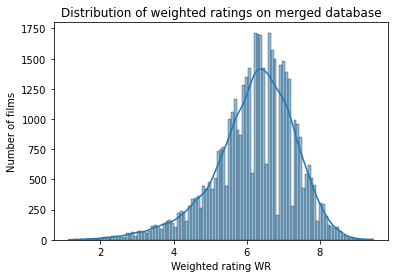

In [308]:
sns.histplot(x='WR', data=movie_feature, kde=True).set(title='Distribution of weighted ratings on merged database',xlabel='Weighted rating WR', ylabel='Number of films')


In [309]:
len((movie_feature['name'] + movie_feature['release_year'].astype(str)).unique()) / len(movie_feature)

1.0

### Fill missing budget data from imdb budget dataset

In [310]:
imdb_budget.sample(5)

,Movie,Year,IMDb,Rating,Runtime,Genre,Release Date,Production Budget,Domestic Gross,Worldwide Gross
1041,Hope Springs,2012,6.3,PG-13,100,"Comedy, Drama, Romance","Aug 8, 2012",30000000,63536011,133085295
924,JFK,1991,8.0,R,189,"Drama, History, Thriller","Dec 20, 1991",40000000,70405498,205400000
3253,12 Angry Men,1957,8.9,Approved,96,"Crime, Drama","Apr 13, 1957",340000,0,0
1396,The Kingdom,2007,7.0,R,110,"Action, Drama, Thriller","Sep 28, 2007",72500000,47467250,86802457
865,The Prince of Tides,1991,6.7,R,132,"Drama, Romance","Dec 25, 1991",30000000,74787599,74787599


In [311]:
imdb_budget['Release Date'] = imdb_budget['Release Date'].astype('str') # Convert to string all dates
release_date = pd.DataFrame(pd.to_datetime(imdb_budget['Release Date']).apply(lambda x: [x.year, x.month, x.day]).tolist(), columns=['release_year','release_month','release_day'])
imdb_budget[['release_year','release_month','release_day']] = release_date

In [312]:
imdb_budget['release_year'] = imdb_budget['release_year'].astype('float32')
imdb_budget['release_month'] = imdb_budget['release_month'].astype('float32')
imdb_budget['release_day'] = imdb_budget['release_day'].astype('float32')

In [313]:
imdb_budget.drop(['Year', 'Release Date'], axis=1, inplace=True)
imdb_budget.rename({'Movie': 'name', 'Genre': 'genres'}, axis=1, inplace=True)
imdb_budget.columns

Index(['name', 'IMDb', 'Rating', 'Runtime', 'genres', 'Production Budget',
       'Domestic Gross', 'Worldwide Gross', 'release_year', 'release_month',
       'release_day'],
      dtype='object')

In [314]:
imdb_budget['genres'] = imdb_budget['genres'].apply(lambda el: el.split(', '))

In [315]:
imdb_budget.describe()

,IMDb,Runtime,Production Budget,Domestic Gross,Worldwide Gross,release_year,release_month,release_day
count,3828.000000,3828.000000,3.828000e+03,3.828000e+03,3.828000e+03,3828.000000,3828.000000,3828.000000
mean,6.459013,109.940439,4.030960e+07,5.559021e+07,1.206910e+08,2003.593994,7.322100,15.891066
std,0.996623,20.219674,4.480927e+07,7.403263e+07,1.993646e+08,12.767752,3.378486,8.437509
min,1.500000,63.000000,7.000000e+03,0.000000e+00,0.000000e+00,1925.000000,1.000000,1.000000
25%,5.900000,96.000000,1.100000e+07,1.180967e+07,1.690363e+07,1999.000000,5.000000,9.000000
50%,6.500000,106.000000,2.500000e+07,3.225471e+07,5.077617e+07,2006.000000,8.000000,16.000000
75%,7.100000,120.000000,5.000000e+07,6.848642e+07,1.388776e+08,2013.000000,10.000000,23.000000
max,9.300000,271.000000,4.000000e+08,8.583730e+08,2.797801e+09,2020.000000,12.000000,31.000000


In [316]:
len((movie_feature['name'] + str(movie_feature['release_year'])).unique()) / len(movie_feature)

0.9254858684323463

In [317]:
imdb_budget.columns

Index(['name', 'IMDb', 'Rating', 'Runtime', 'genres', 'Production Budget',
       'Domestic Gross', 'Worldwide Gross', 'release_year', 'release_month',
       'release_day'],
      dtype='object')

In [318]:
movie_feature.columns

Index(['wikipedia_id', 'freebase_id', 'name', 'box_office_revenue', 'runtime',
       'languages', 'countries', 'release_year', 'release_month',
       'release_day', 'isAdult', 'averageRating', 'numVotes', 'directors',
       'writers', 'WR', 'genre'],
      dtype='object')

In [319]:
movie_feature_with_budget = movie_feature.merge(imdb_budget, on=['name', 'release_year'], how='outer')

In [320]:
movie_feature_with_budget.columns

Index(['wikipedia_id', 'freebase_id', 'name', 'box_office_revenue', 'runtime',
       'languages', 'countries', 'release_year', 'release_month_x',
       'release_day_x', 'isAdult', 'averageRating', 'numVotes', 'directors',
       'writers', 'WR', 'genre', 'IMDb', 'Rating', 'Runtime', 'genres',
       'Production Budget', 'Domestic Gross', 'Worldwide Gross',
       'release_month_y', 'release_day_y'],
      dtype='object')

In [321]:
fill_NaN(movie_feature_with_budget,'genre','genres','genre')
fill_NaN(movie_feature_with_budget,'release_day_x','release_day_y','release_day')
fill_NaN(movie_feature_with_budget,'release_month_x','release_month_y','release_month')
fill_NaN(movie_feature_with_budget,'runtime','Runtime')

### Investigate the gross difference between the original and the imdb budget datasets

<AxesSubplot:title={'center':'Distribution of the difference of the total worldwide gross data from the two datasets'}, ylabel='Frequency'>

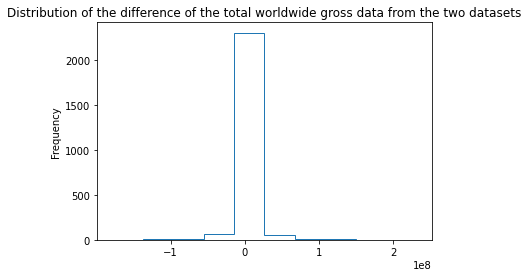

In [322]:
(movie_feature_with_budget['box_office_revenue'] - movie_feature_with_budget['Worldwide Gross']).plot(kind='hist', histtype='step', title='Distribution of the difference of the total worldwide gross data from the two datasets')

<AxesSubplot:title={'center':'Distribution of the percentage in difference of the total worldwide gross data from the two datasets'}, ylabel='Frequency'>

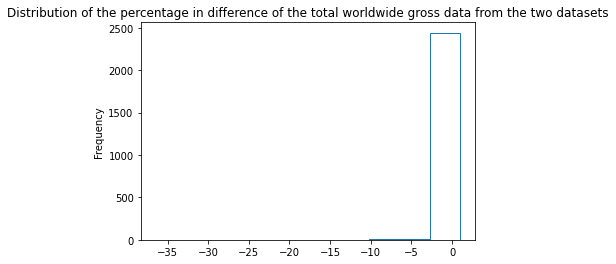

In [323]:
((movie_feature_with_budget['box_office_revenue'] - movie_feature_with_budget['Worldwide Gross']) / movie_feature_with_budget['box_office_revenue']).plot(kind='hist', histtype='step', title='Distribution of the percentage in difference of the total worldwide gross data from the two datasets')

In [324]:
movie_feature_with_budget_differences = movie_feature_with_budget.copy()
movie_feature_with_budget_differences['gross_difference'] = np.abs(movie_feature_with_budget_differences['box_office_revenue'] - movie_feature_with_budget_differences['Worldwide Gross'])
movie_feature_with_budget_differences['gross_difference%'] = ((np.abs(movie_feature_with_budget['box_office_revenue'] - movie_feature_with_budget['Worldwide Gross']) / movie_feature_with_budget['box_office_revenue']) * 100).round(2)

In [325]:
# Difference between the total worldwide gross data from the two datasets
movie_feature_with_budget_differences \
    [(movie_feature_with_budget_differences['gross_difference'] != 0) & (~movie_feature_with_budget_differences['gross_difference'].isna())] \
    .sort_values('gross_difference%', ascending=False) \
    [['name', 'box_office_revenue', 'Worldwide Gross', 'gross_difference', 'gross_difference%']]

,name,box_office_revenue,Worldwide Gross,gross_difference,gross_difference%
1611,The Son of No One,30680.0,1148578.0,1117898.0,3643.74
10379,Restless,163265.0,2772511.0,2609246.0,1598.17
3307,Welcome to Collinwood,336620.0,4606284.0,4269664.0,1268.39
30129,Margaret,46495.0,623292.0,576797.0,1240.56
4126,The Wizard of Oz,3017000.0,34949482.0,31932482.0,1058.42
...,...,...,...,...,...
56979,Click,237681299.0,237685089.0,3790.0,0.00
57636,G-Force,292810686.0,292817841.0,7155.0,0.00
12989,What Women Want,374111707.0,374105123.0,6584.0,0.00
58624,Butch Cassidy and the Sundance Kid,102308889.0,102310653.0,1764.0,0.00


In [326]:
# Percentage differences between the gross data from the two datasets
movie_feature_with_budget_differences.describe(percentiles=[.25, .5, .75, .8, .9, .95])[['gross_difference%']]

,gross_difference%
count,2464.000000
mean,16.458888
std,101.443043
min,0.000000
25%,0.020000
50%,0.695000
75%,5.455000
80%,9.924000
90%,34.167000
95%,62.882000


In [327]:
movie_feature_with_budget_differences[movie_feature_with_budget_differences['gross_difference'] == 0].shape[0] / movie_feature_with_budget_differences['gross_difference%'].notna().sum()

0.15868506493506493

In [328]:
movie_feature_with_budget_differences[
    (movie_feature_with_budget_differences['name'] == 'The Son of No One') |
    (movie_feature_with_budget_differences['name'] == 'Restless') |
    (movie_feature_with_budget_differences['name'] == 'Welcome to Collinwood')
][[
    'name', 'box_office_revenue', 'Worldwide Gross'
]]

,name,box_office_revenue,Worldwide Gross
1611,The Son of No One,30680.0,1148578.0
3307,Welcome to Collinwood,336620.0,4606284.0
10379,Restless,163265.0,2772511.0
18706,Restless,NaN,NaN
31576,Restless,NaN,NaN


In [329]:
# gross_difference = box_office_revenue - Worldwide Gross
print((movie_feature_with_budget_differences['box_office_revenue'] - movie_feature_with_budget_differences['Worldwide Gross'] > 0).sum())
print((movie_feature_with_budget_differences['box_office_revenue'] - movie_feature_with_budget_differences['Worldwide Gross'] < 0).sum())
print((movie_feature_with_budget_differences['box_office_revenue'] - movie_feature_with_budget_differences['Worldwide Gross'] == 0).sum())
(movie_feature_with_budget_differences['box_office_revenue'] - movie_feature_with_budget_differences['Worldwide Gross']).describe()

1012
1061
391


count    2.464000e+03
mean     4.148700e+05
std      1.570988e+07
min     -1.785914e+08
25%     -6.153875e+05
50%      0.000000e+00
75%      1.997022e+05
max      2.310745e+08
dtype: float64

We want to fill the missing data from the imdb budget dataset. For this purpose we are comparing the difference between the CMU, imdb top 1000, and imdb budget data. We have the:
 
 * `box_office_revenue` - from CMU with 8401 values /total gross/
 * `Gross` - from imdb top 1000 with 831 values /total gross in US and Canada/
 * `Domestic Gross` - from imdb budget with 3841 values /total gross in US and Canada/
 * `Worldwide Gross` - from imdb budget with 3841 values /total gross/

We would only consider the total worldwide gross since we are investigating movies from the whole world. The information for it is contained in the `box_office_revenue` and `Worldwide Gross`. Only around 20% of the values for the total gross are the same. Also, we know that the other data in `box_office_revenue` is not bigger or smaller than the `Worldwide Gross` for all records. So we can conclude that `box_office_revenue` and `Worldwide Gross` are not connected.

Based on this, we cannot combine the data from the both datasets and we would prefer using the data from the imdb budget dataset because it contains information about the budget of the movie and the data inside seams more accurate based on the comparison of a subset of it with Wikipedia data.

In [330]:
movie_feature_with_budget.columns

Index(['wikipedia_id', 'freebase_id', 'name', 'box_office_revenue', 'runtime',
       'languages', 'countries', 'release_year', 'release_month_x',
       'release_day_x', 'isAdult', 'averageRating', 'numVotes', 'directors',
       'writers', 'WR', 'genre', 'IMDb', 'Rating', 'Runtime', 'genres',
       'Production Budget', 'Domestic Gross', 'Worldwide Gross',
       'release_month_y', 'release_day_y', 'release_day', 'release_month'],
      dtype='object')

In [331]:
movie_feature_with_budget.columns

Index(['wikipedia_id', 'freebase_id', 'name', 'box_office_revenue', 'runtime',
       'languages', 'countries', 'release_year', 'release_month_x',
       'release_day_x', 'isAdult', 'averageRating', 'numVotes', 'directors',
       'writers', 'WR', 'genre', 'IMDb', 'Rating', 'Runtime', 'genres',
       'Production Budget', 'Domestic Gross', 'Worldwide Gross',
       'release_month_y', 'release_day_y', 'release_day', 'release_month'],
      dtype='object')

In [332]:
# Remove merged extra columns 
movie_feature_with_budget.drop([
    'Worldwide Gross', 'Domestic Gross', 'Rating', 'Runtime', 'IMDb', 'release_month_x', 'release_month_y',
    'release_day_x', 'release_day_y', 'genres'
], axis=1, inplace=True)

# Rename gross column
movie_feature_with_budget.rename({'box_office_revenue': 'total_gross'}, axis=1, inplace=True)

# Compute profit as success indicator
movie_feature_with_budget['profit'] = movie_feature_with_budget['total_gross'] - movie_feature_with_budget['Production Budget']

In [333]:
movie_feature_with_budget.columns

Index(['wikipedia_id', 'freebase_id', 'name', 'total_gross', 'runtime',
       'languages', 'countries', 'release_year', 'isAdult', 'averageRating',
       'numVotes', 'directors', 'writers', 'WR', 'genre', 'Production Budget',
       'release_day', 'release_month', 'profit'],
      dtype='object')

In [334]:
movie_feature_with_budget.describe()

,wikipedia_id,total_gross,runtime,release_year,isAdult,averageRating,numVotes,WR,Production Budget,release_day,release_month,profit
count,8.155500e+04,8.392000e+03,68104.000000,75770.000000,44031.000000,44031.000000,4.403100e+04,44031.000000,3.828000e+03,40527.000000,43783.000000,2.464000e+03
mean,1.740360e+07,4.799791e+07,93.965487,1977.970337,0.002566,6.195617,1.378128e+04,6.224498,4.030960e+07,15.658129,6.707717,7.208180e+07
std,1.098688e+07,1.122099e+08,59.949382,29.228281,0.050595,1.155310,7.286329e+04,1.102334,4.480927e+07,8.708538,3.483055,1.442546e+08
min,3.300000e+02,1.000000e+04,0.000000,1010.000000,0.000000,1.000000,5.000000e+00,1.131770,7.000000e+03,1.000000,1.000000,-1.110072e+08
25%,7.320728e+06,2.075232e+06,80.000000,1956.000000,0.000000,5.600000,1.070000e+02,5.614247,1.100000e+07,8.000000,4.000000,4.951632e+05
50%,1.777503e+07,1.063551e+07,93.000000,1986.000000,0.000000,6.300000,5.160000e+02,6.317251,2.500000e+07,16.000000,7.000000,2.414130e+07
75%,2.714269e+07,4.073253e+07,108.000000,2004.000000,0.000000,7.000000,2.660500e+03,6.998635,5.000000e+07,23.000000,10.000000,8.700518e+07
max,3.750192e+07,2.782275e+09,5700.000000,2020.000000,1.000000,10.000000,2.667015e+06,9.467126,4.000000e+08,31.000000,12.000000,2.545275e+09


In [335]:
movie_feature_with_budget.head(5)

,wikipedia_id,freebase_id,name,total_gross,runtime,languages,countries,release_year,isAdult,averageRating,numVotes,directors,writers,WR,genre,Production Budget,release_day,release_month,profit
0,975900.0,/m/03vyhn,Ghosts of Mars,14010832.0,98.0,[English],[United States of America],2001.0,0.0,4.9,55353.0,[John Carpenter],"[Larry Sulkis, John Carpenter]",4.900185,"[Thriller, Science Fiction, Horror, Adventure,...",NaN,24.0,8.0,NaN
1,3196793.0,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,NaN,95.0,[English],[United States of America],2000.0,NaN,NaN,NaN,NaN,NaN,NaN,"[Mystery, Biographical film, Drama, Crime Drama]",NaN,16.0,2.0,NaN
2,28463795.0,/m/0crgdbh,Brun bitter,NaN,83.0,[Norwegian],[Norway],1988.0,0.0,5.7,40.0,[Sølve Skagen],"[Sølve Skagen, Gunnar Staalesen]",5.839121,"[Crime Fiction, Drama]",NaN,NaN,NaN,NaN
3,9363483.0,/m/0285_cd,White Of The Eye,NaN,110.0,[English],[United Kingdom],1987.0,NaN,NaN,NaN,NaN,NaN,NaN,"[Thriller, Erotic thriller, Psychological thri...",NaN,NaN,NaN,NaN
4,261236.0,/m/01mrr1,A Woman in Flames,NaN,106.0,[German],[Germany],1983.0,NaN,NaN,NaN,NaN,NaN,NaN,[Drama],NaN,NaN,NaN,NaN


## Account for inflation: 

As our movie database has movies dating back to 1921, we need to adjust the budgets and profits through an inflation rate.

Source: https://inflationdata.com/Inflation/Inflation/DecadeInflation.asp

In [336]:
# Create dictionary of cumulative inflation rate per decade since 1913 in the US:
inflation_rates = [92.86, 4.82, -18.6, 68.57, 24.58, 28.23, 103.45, 64.41, 33.47, 28.31, 19.38, 1.27]
inflation_rates = [x / 100 + 1 for x in inflation_rates]
decades = list(np.linspace(1913,2023,len(inflation_rates)))
inflation_dic = dict(map(lambda i,j : (i,j) , decades, inflation_rates))

In [337]:
df = movie_feature_with_budget.copy()

In [338]:
# Initialisation
df['profit_modified'] = df['profit']
df['total_gross_modified'] = df['total_gross']
df['budget_modified'] = df['Production Budget']

In [339]:
for k in range(len(decades)-1): # For each decade
    year_before = decades[k]
    year = decades[k+1]
    inflation_rate = inflation_dic[year_before]
    
    decade_df = df[(df['release_year']<year) & (df['release_year']>year_before)] # decade mask
    
    idx = decade_df.index.tolist()

    # Create new column with prices modified by interest rate
    df.loc[idx, 'profit_modified'] = decade_df['profit'] * inflation_rate
    df.loc[idx, 'total_gross_modified'] = decade_df['total_gross'] * inflation_rate
    df.loc[idx, 'budget_modified'] = decade_df['Production Budget'] * inflation_rate

In [340]:
movie_feature_with_budget = df.copy()

In [341]:
movie_feature_with_budget.head(2)

,wikipedia_id,freebase_id,name,total_gross,runtime,languages,countries,release_year,isAdult,averageRating,...,writers,WR,genre,Production Budget,release_day,release_month,profit,profit_modified,total_gross_modified,budget_modified
0,975900.0,/m/03vyhn,Ghosts of Mars,14010832.0,98.0,[English],[United States of America],2001.0,0.0,4.9,...,"[Larry Sulkis, John Carpenter]",4.900185,"[Thriller, Science Fiction, Horror, Adventure,...",NaN,24.0,8.0,NaN,NaN,1.870026e+07,NaN
1,3196793.0,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,NaN,95.0,[English],[United States of America],2000.0,NaN,NaN,...,NaN,NaN,"[Mystery, Biographical film, Drama, Crime Drama]",NaN,16.0,2.0,NaN,NaN,NaN,NaN


In [342]:
# Delete the columns for budget which are not modified by inflation rate: 
movie_feature_with_budget.drop(['total_gross','profit', 'Production Budget'], axis=1, inplace=True)

### Wikipedia pageviews

In [343]:
wikipedia_pageviews.sample(5)

,name,pageviews
11178,Doraemon: Nobita in the Wan-Nyan Spacetime Ody...,1557.891963
25959,Mugabe and the White African,549.046854
33681,She's Out Of My League,54.724638
3267,An Unreasonable Man,629.189723
15474,Gudumba Shankar,4125.597826


In [344]:
wikipedia_pageviews.describe()

,pageviews
count,45819.000000
mean,2396.190760
std,10343.997960
min,0.000000
25%,46.054842
50%,230.307230
75%,1041.628953
max,410868.409091


In [345]:
movie_feature_with_budget_and_wikipedia_pageviews = pd.merge(movie_feature_with_budget, wikipedia_pageviews, on='name', how='left')

# Free memory
del movie_feature_with_budget
del wikipedia_pageviews

In [346]:
movie_feature_with_budget_and_wikipedia_pageviews.describe()

,wikipedia_id,runtime,release_year,isAdult,averageRating,numVotes,WR,release_day,release_month,profit_modified,total_gross_modified,budget_modified,pageviews
count,8.155500e+04,68104.000000,75770.000000,44031.000000,44031.000000,4.403100e+04,44031.000000,40527.000000,43783.000000,2.464000e+03,8.392000e+03,3.828000e+03,46823.000000
mean,1.740360e+07,93.965487,1977.970337,0.002566,6.195617,1.378128e+04,6.224498,15.658129,6.707717,9.605612e+07,6.483874e+07,5.092346e+07,2734.818491
std,1.098688e+07,59.949382,29.228281,0.050595,1.155310,7.286329e+04,1.102334,8.708538,3.483055,1.897343e+08,1.487117e+08,5.505716e+07,11517.211493
min,3.300000e+02,0.000000,1010.000000,0.000000,1.000000,5.000000e+00,1.131770,1.000000,1.000000,-1.424334e+08,1.138400e+04,8.981700e+03,0.000000
25%,7.320728e+06,80.000000,1956.000000,0.000000,5.600000,1.070000e+02,5.614247,8.000000,4.000000,6.762006e+05,2.803050e+06,1.411410e+07,47.083004
50%,1.777503e+07,93.000000,1986.000000,0.000000,6.300000,5.160000e+02,6.317251,16.000000,7.000000,3.261206e+07,1.456574e+07,3.255200e+07,238.284585
75%,2.714269e+07,108.000000,2004.000000,0.000000,7.000000,2.660500e+03,6.998635,23.000000,10.000000,1.156132e+08,5.778973e+07,6.673500e+07,1094.704134
max,3.750192e+07,5700.000000,2020.000000,1.000000,10.000000,2.667015e+06,9.467126,31.000000,12.000000,3.265843e+09,3.569937e+09,4.862949e+08,410868.409091


### Prepare `df_all`

In [347]:
# For simplicity of use, we rename the dataframe
df_all = movie_feature_with_budget_and_wikipedia_pageviews

#### Deal with NaN

In [348]:
fill_na_with_list(df_all, 'languages')
fill_na_with_list(df_all, 'countries')
fill_na_with_list(df_all, 'genre')
fill_na_with_list(df_all, 'directors')
fill_na_with_list(df_all, 'writers')

#### Remove irrelevant columns

In [349]:
df_all.drop(['wikipedia_id', 'averageRating', 'numVotes'], axis=1, inplace=True)

# Exploratory Data Analysis

## Success indicators

Success of a movie can be very subjective. We thus need to diversify our definitions of success to have a holistic view of our dataset. The following success indicators are considered: 
- How well a movie is received: 
    IMDB ratings which should be weighted by the number of votes
- How profitable a movie is: 
    Overall gross revenue of the movie OR profit = gross revenue - budget spent
- How long a movie will last in time: 
    Number of connection to the movie wikipedia page


## Explore data

Looking at the impacts of features on eachother by drawing a correlation heatmap

C:\Users\34683\AppData\Local\Temp/ipykernel_22888/2314911968.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_all.corr(), annot=True, ax=ax).set(title='Heat map of correlations between different movie features');


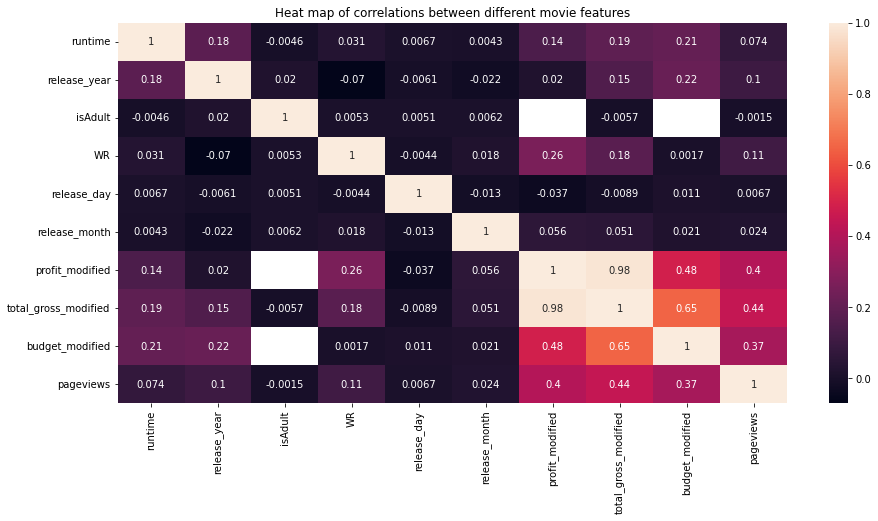

In [350]:
fig, ax = plt.subplots(figsize=(15,7))
sns.heatmap(df_all.corr(), annot=True, ax=ax).set(title='Heat map of correlations between different movie features');


Interesting correlations: 
Our different success indicators are not too correlated (WR, profit_modified, pageviews) 

### Creation of unique success score

In order to investigate the relation between movie features and success, it would be practical to have a unique movie success score. Seeing how the weighted ratings, the profit, and the number of pageviews are uncorrelated, a movie that is successful in time (high pageviews) might however not be the most profitable (high profit), same thing for IMDB rating. 

In [351]:
# We standardise each success feature
df_all['WR_std'] = (df_all['WR'] - df_all['WR'].mean())/df_all['WR'].std()
df_all['profit_modified_std'] = (df_all['profit_modified'] - df_all['profit_modified'].mean())/df_all['profit_modified'].std()
df_all['pageviews_std'] = (df_all['pageviews'] - df_all['pageviews'].mean())/df_all['pageviews'].std()
df_all['total_gross_modified_std'] = (df_all['total_gross_modified'] - df_all['total_gross_modified'].mean())/df_all['total_gross_modified'].std()



In [352]:
# We L2 normalise each success feature
df_all['WR_norm'] = df_all['WR'] / np.sqrt(np.square(df_all['WR']).sum(axis=0))
df_all['profit_modified_norm'] = df_all['profit_modified'] / np.sqrt(np.square(df_all['profit_modified']).sum(axis=0))
df_all['pageviews_norm'] = df_all['pageviews'] / np.sqrt(np.square(df_all['pageviews']).sum(axis=0))
df_all['total_gross_modified_norm'] = df_all['total_gross_modified'] / np.sqrt(np.square(df_all['total_gross_modified']).sum(axis=0))



In [353]:
df_all[['WR_std','profit_modified_std','pageviews_std','WR_norm','profit_modified_norm','pageviews_norm']].describe()

,WR_std,profit_modified_std,pageviews_std,WR_norm,profit_modified_norm,pageviews_norm
count,4.403100e+04,2.464000e+03,4.682300e+04,44031.000000,2464.000000,46823.000000
mean,-3.255706e-16,-6.488316e-18,-1.214006e-18,0.004693,0.009101,0.001068
std,1.000000e+00,1.000000e+00,1.000000e+00,0.000831,0.017976,0.004496
min,-4.619948e+00,-1.256965e+00,-2.374549e-01,0.000853,-0.013495,0.000000
25%,-5.535986e-01,-5.027024e-01,-2.333669e-01,0.004233,0.000064,0.000018
50%,8.414206e-02,-3.343836e-01,-2.167655e-01,0.004763,0.003090,0.000093
75%,7.022702e-01,1.030759e-01,-1.424055e-01,0.005276,0.010954,0.000427
max,2.941601e+00,1.670645e+01,3.543684e+01,0.007137,0.309422,0.160405


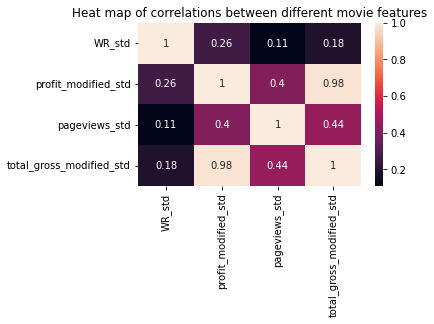

In [354]:
fig, ax = plt.subplots(figsize=(5,3))
sns.heatmap(df_all[['WR_std','profit_modified_std','pageviews_std','total_gross_modified_std']].corr(), annot=True, ax=ax).set(title='Heat map of correlations between different movie features');

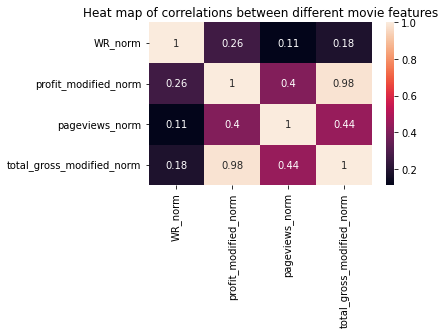

In [355]:
fig, ax = plt.subplots(figsize=(5,3))
sns.heatmap(df_all[['WR_norm','profit_modified_norm','pageviews_norm','total_gross_modified_norm']].corr(), annot=True, ax=ax).set(title='Heat map of correlations between different movie features');

There is still no strong correlations between success features. This indicates that the different scores are independent. Therefore, we create a single movie score based on the rank of each movie for individual scores. The best movie according to each individual feature will thus be ranked with score 1.

In [356]:
# Drop columns since unused 
df_all.drop(['WR_std','profit_modified_std','pageviews_std','WR_norm','profit_modified_norm','pageviews_norm'],axis=1,inplace=True)

In [357]:
# Rating of movies according to feature 1: WR : Score 1 'S1'
df_all.sort_values(by='WR',ascending=False,inplace=True)
df_all['S1'] = np.arange(1, len(df_all)+1)

# Rating of movies according to feature 2: profit_modified : Score 2 'S2'
df_all.sort_values(by='profit_modified',ascending=False,inplace=True)
df_all['S2'] = np.arange(1, len(df_all)+1)

# Rating of movies according to feature 3: total_gross_modified : Score 3 'S3'
df_all.sort_values(by='total_gross_modified',ascending=False,inplace=True)
df_all['S3'] = np.arange(1, len(df_all)+1)

# Rating of movies according to feature 4: pageviews : Score 4 'S4'
df_all.sort_values(by='pageviews',ascending=False,inplace=True)
df_all['S4'] = np.arange(1, len(df_all)+1)

# Number of movies: 
N_movies = len(df_all)

Since the pageviews has been obtained by querying according to the name of the movie and the apperance of the word "film" in the summary of the wikipedia page, it is possible that there might be some error (multiple wikipedia page not answering to the movie). Let's check the best movies according to this feature:

In [358]:
df_all.head(20)

,freebase_id,name,runtime,languages,countries,release_year,isAdult,directors,writers,WR,...,profit_modified,total_gross_modified,budget_modified,pageviews,total_gross_modified_std,total_gross_modified_norm,S1,S2,S3,S4
1294,/m/0crd14y,Madonna,85.0,"[Croatian, Serbian]",[Croatia],1999.0,NaN,[],[],NaN,...,NaN,NaN,NaN,410868.409091,NaN,NaN,44616,44630,46108,1
57928,/m/07cz2,The Matrix,135.0,[English],"[United States of America, Australia]",1999.0,0.0,"[Lana Wachowski, Lilly Wachowski]","[Lilly Wachowski, Lana Wachowski]",8.699995,...,5.319012e+08,6.186567e+08,86755500.0,371788.721591,3.724103,0.041630,95,91,121,2
81555,NaN,Avengers: Endgame,181.0,[],[],2019.0,NaN,[],[],NaN,...,NaN,NaN,477520000.0,321330.244565,NaN,NaN,81556,81556,81556,3
81586,NaN,Spider-Man: Homecoming,133.0,[],[],2017.0,NaN,[],[],NaN,...,NaN,NaN,208915000.0,311412.870059,NaN,NaN,81587,81587,81587,4
22209,/m/02dkqh,Doctor Who,89.0,[English],"[United States of America, Canada, United King...",1996.0,0.0,[Geoffrey Sax],"[Matthew Jacobs, Sydney Newman]",6.300334,...,NaN,NaN,NaN,293771.607708,NaN,NaN,23063,24081,27660,5
27206,/m/08096cn,Don't Look Up,NaN,[Japanese],[],1996.0,NaN,[],[],NaN,...,NaN,NaN,NaN,259033.395751,NaN,NaN,56457,56467,57463,6
65390,/m/03wc1t7,Ponniyin Selvan,139.0,[Tamil],[India],2005.0,0.0,[Radha Mohan],"[Radha Mohan, Viji Radhika, Viji]",4.947403,...,NaN,NaN,NaN,257791.275692,NaN,NaN,38798,38975,40821,7
5187,/m/07kbtrw,Friends,112.0,[English],"[France, South Africa, United Kingdom]",1993.0,0.0,[Elaine Proctor],[Elaine Proctor],6.325876,...,NaN,NaN,NaN,247536.067441,NaN,NaN,21855,22876,26575,8
21710,/m/02vt6lv,Friends,13.0,"[Silent film, English]",[United States of America],1912.0,0.0,[D.W. Griffith],[D.W. Griffith],5.524528,...,NaN,NaN,NaN,247536.067441,NaN,NaN,33981,34407,36762,9
55672,/m/0dqr6n,Friends,101.0,[English],[United Kingdom],1971.0,0.0,[Lewis Gilbert],"[Lewis Gilbert, Vernon Harris, Jack Russell]",6.502161,...,NaN,NaN,NaN,247536.067441,NaN,NaN,18987,20217,24322,10


We visually remove the pageviews which seem erronated among top scored movie according to this feature. 
- Madonna (confusion between film and singer)
- Friends (confusion between film and famous TV show)
- Don't Look up in japenese language (confusion between japanese 1996 movie and 2021 succesful movie)
- Chiranjeevi is also the name of India's former ministry of Culture

In [359]:
df_all.loc[[3,25,53,61,41,57,38,46,42,34,79],'S4'] = np.nan # indices correponding to films abovementioned

In [360]:
df_all.sort_values(by='S4',ascending=True,inplace=True)
df_all['S4'] = np.arange(1, len(df_all)+1)

In [361]:
df_all.head(10)

,freebase_id,name,runtime,languages,countries,release_year,isAdult,directors,writers,WR,...,profit_modified,total_gross_modified,budget_modified,pageviews,total_gross_modified_std,total_gross_modified_norm,S1,S2,S3,S4
1294,/m/0crd14y,Madonna,85.0,"[Croatian, Serbian]",[Croatia],1999.0,NaN,[],[],NaN,...,NaN,NaN,NaN,410868.409091,NaN,NaN,44616,44630,46108,1
57928,/m/07cz2,The Matrix,135.0,[English],"[United States of America, Australia]",1999.0,0.0,"[Lana Wachowski, Lilly Wachowski]","[Lilly Wachowski, Lana Wachowski]",8.699995,...,5.319012e+08,6.186567e+08,86755500.0,371788.721591,3.724103,0.04163,95,91,121,2
81555,NaN,Avengers: Endgame,181.0,[],[],2019.0,NaN,[],[],NaN,...,NaN,NaN,477520000.0,321330.244565,NaN,NaN,81556,81556,81556,3
81586,NaN,Spider-Man: Homecoming,133.0,[],[],2017.0,NaN,[],[],NaN,...,NaN,NaN,208915000.0,311412.870059,NaN,NaN,81587,81587,81587,4
22209,/m/02dkqh,Doctor Who,89.0,[English],"[United States of America, Canada, United King...",1996.0,0.0,[Geoffrey Sax],"[Matthew Jacobs, Sydney Newman]",6.300334,...,NaN,NaN,NaN,293771.607708,NaN,NaN,23063,24081,27660,5
27206,/m/08096cn,Don't Look Up,NaN,[Japanese],[],1996.0,NaN,[],[],NaN,...,NaN,NaN,NaN,259033.395751,NaN,NaN,56457,56467,57463,6
65390,/m/03wc1t7,Ponniyin Selvan,139.0,[Tamil],[India],2005.0,0.0,[Radha Mohan],"[Radha Mohan, Viji Radhika, Viji]",4.947403,...,NaN,NaN,NaN,257791.275692,NaN,NaN,38798,38975,40821,7
5187,/m/07kbtrw,Friends,112.0,[English],"[France, South Africa, United Kingdom]",1993.0,0.0,[Elaine Proctor],[Elaine Proctor],6.325876,...,NaN,NaN,NaN,247536.067441,NaN,NaN,21855,22876,26575,8
21710,/m/02vt6lv,Friends,13.0,"[Silent film, English]",[United States of America],1912.0,0.0,[D.W. Griffith],[D.W. Griffith],5.524528,...,NaN,NaN,NaN,247536.067441,NaN,NaN,33981,34407,36762,9
55672,/m/0dqr6n,Friends,101.0,[English],[United Kingdom],1971.0,0.0,[Lewis Gilbert],"[Lewis Gilbert, Vernon Harris, Jack Russell]",6.502161,...,NaN,NaN,NaN,247536.067441,NaN,NaN,18987,20217,24322,10


#### Create single score with  harmonic mean

In the context of ranking movies based on multiple uncorrelated success features, the harmonic mean can be used to combine the ranks for each movie in a way that gives more weight to lower ranks. This is healful to prioritize movies that perform well across all of the features, rather than just excelling in a few specific ones.

In [362]:
df_all['Score'] = df_all.apply(lambda x: N_movies / (1/x['S1'] + 1/x['S2'] + 1/x['S3'] + 1/x['S4']), axis=1)
df_all.sort_values(by='Score',ascending=True,inplace=True)
df_all.head(3)

,freebase_id,name,runtime,languages,countries,release_year,isAdult,directors,writers,WR,...,total_gross_modified,budget_modified,pageviews,total_gross_modified_std,total_gross_modified_norm,S1,S2,S3,S4,Score
23686,/m/0bth54,Avatar,178.0,"[English, Spanish]","[United States of America, United Kingdom]",2009.0,0.0,[James Cameron],[James Cameron],7.799997,...,3.569937e+09,304094700.0,NaN,23.569749,0.240222,2113,1,1,46819,41292.288012
22242,/m/0dr_4,Titanic,194.0,"[Italian, English, French, Swedish, Russian, G...",[United States of America],1997.0,0.0,[James Cameron],[James Cameron],7.899996,...,2.916816e+09,266940000.0,NaN,19.177891,0.196273,1636,2,2,46820,82552.776673
22040,/m/0h5ndj,The Ambassador,27.0,[English],[United States of America],2008.0,0.0,[Rob Sitch],"[Santo Cilauro, Tom Gleisner, Rob Sitch]",9.467126,...,NaN,NaN,NaN,NaN,NaN,1,2465,8393,50623,82560.039430


In [363]:
# Rescale scores between 0 and 1: best score is 0, worst score is 1
min_score = df_all['Score'].min()
max_score = df_all['Score'].max()
df_all['Score']=df_all.apply(lambda x: (x['Score']-min_score)/(max_score-min_score),axis=1)

Currently, the column 'Score' corresponds to a score where best score is 0. For future calculation, we transform this into a score between 0 and 10 where the best score is 10. 

In [364]:
df_all['Score'] = (1 - df_all['Score'])*10

In [365]:
df_all.sort_values(by='Score',ascending=False,inplace=True)
df_all.head(10)

,freebase_id,name,runtime,languages,countries,release_year,isAdult,directors,writers,WR,...,total_gross_modified,budget_modified,pageviews,total_gross_modified_std,total_gross_modified_norm,S1,S2,S3,S4,Score
23686,/m/0bth54,Avatar,178.0,"[English, Spanish]","[United States of America, United Kingdom]",2009.0,0.0,[James Cameron],[James Cameron],7.799997,...,3.569937e+09,304094700.0,NaN,23.569749,0.240222,2113,1,1,46819,10.000000
22242,/m/0dr_4,Titanic,194.0,"[Italian, English, French, Swedish, Russian, G...",[United States of America],1997.0,0.0,[James Cameron],[James Cameron],7.899996,...,2.916816e+09,266940000.0,NaN,19.177891,0.196273,1636,2,2,46820,9.999758
22040,/m/0h5ndj,The Ambassador,27.0,[English],[United States of America],2008.0,0.0,[Rob Sitch],"[Santo Cilauro, Tom Gleisner, Rob Sitch]",9.467126,...,NaN,NaN,NaN,NaN,NaN,1,2465,8393,50623,9.999758
1294,/m/0crd14y,Madonna,85.0,"[Croatian, Serbian]",[Croatia],1999.0,NaN,[],[],NaN,...,NaN,NaN,410868.409091,NaN,NaN,44616,44630,46108,1,9.999758
28169,/m/062zm5h,The Avengers,137.0,"[Russian, English]",[United States of America],2012.0,0.0,[Joss Whedon],"[Joss Whedon, Zak Penn]",7.999996,...,1.939737e+09,288697500.0,770.791996,12.607598,0.130525,1255,3,3,14176,9.999517
57928,/m/07cz2,The Matrix,135.0,[English],"[United States of America, Australia]",1999.0,0.0,"[Lana Wachowski, Lilly Wachowski]","[Lilly Wachowski, Lana Wachowski]",8.699995,...,6.186567e+08,86755500.0,371788.721591,3.724103,0.041630,95,91,121,2,9.999328
4290,/m/06_vgr3,The Ape,81.0,[Swedish],[Sweden],2009.0,0.0,[Joe Pinkerton],[Joe Pinkerton],9.466483,...,NaN,NaN,NaN,NaN,NaN,2,2466,8394,50624,9.999275
18633,/m/0872p_c,Transformers: Dark of the Moon,157.0,[English],[United States of America],2011.0,0.0,[Michael Bay],[Ehren Kruger],6.200009,...,1.441880e+09,250204500.0,55851.217391,9.259800,0.097024,25061,4,7,396,9.999017
31290,/m/05mxr92,I Love You,47.0,[Oriya],[India],2005.0,0.0,[Kelly Makin],"[Ron Cowen, Daniel Lipman, Del Shores]",9.460559,...,NaN,NaN,NaN,NaN,NaN,3,2467,8395,50625,9.998792
81555,NaN,Avengers: Endgame,181.0,[],[],2019.0,NaN,[],[],NaN,...,NaN,477520000.0,321330.244565,NaN,NaN,81556,81556,81556,3,9.998789


### Create success score for movie features

Since we would like to compute the added value of movie features, we want to calculate scores for particular features. In particular, we are interested in estimating a score for combinations of features. For instance, two actors combined together might bring an additional value to a movie that they wouldn't if they were acting independently. We thus want to calculate a weight of actor and director pairs.

In [343]:
def score_movie_element(df, column_name):
    df = df.dropna(subset=[column_name], axis=0)
    df = df.explode(column_name)
    df = df_all.explode(column_name)
    df = df.groupby(column_name).agg({'name': 'count', 'Score': 'mean'}).rename({'name': 'count'}, axis=1).reset_index()
    return df

In [344]:
def score_movie_element_groups(df, column_name):
    df = df.copy().dropna(subset=[column_name], axis=0)
    df[column_name] = df[column_name].apply(lambda x: list(itertools.combinations(set(x), 2)))
    df = df[df[column_name].map(lambda d: len(d)) > 0]
    df = df.explode(column_name)
    df = df.groupby(column_name).agg({'name': 'count', 'Score': 'mean'}).rename({'name': 'count'}, axis=1).reset_index()
    df = df.rename({'count':'num_movies'},axis=1)
    df_AB = pd.DataFrame(df[column_name].tolist()).add_prefix(column_name).reset_index(drop=True)
    df[df_AB.columns] = df_AB
    return df

We want to weight the score by the number of movies: 
weighted rating (Score) = score^4 * (number of movies / total number of movies)^0.25
The coefficients were found empirically to find a balance between rating and number of movies
where:
- R = mean score of feature i accross all movies
- v = number of movies in which feature i plays a role
- m = number of movies total

In [345]:
def weighted_rating(df, column_score, column_nmb_movies, new_column): # Alternative VERSION
    R = df[column_score]
    v = df[column_nmb_movies]
    m = df[column_nmb_movies].sum()
    
    WR = R**4 * (v/m)**0.25
    
    df[new_column] = WR # Update score column
    return df

In [346]:
# Add actor_name to df_all
actors = characters.dropna(subset=['actor_name'], axis=0).groupby('freebase_movie_id')['actor_name'].apply(list).to_frame().reset_index()
df_all = pd.merge(df_all, actors, left_on='freebase_id', right_on='freebase_movie_id', how='left').drop(columns=['freebase_movie_id'])

#### Added value of actor pairs

In [347]:
df_all.sample(3)

,freebase_id,name,runtime,languages,countries,release_year,isAdult,directors,writers,WR,...,S2,S3,S4,Score,actors_score,directors_score,genres_score,normalised_score,Score_inversed,actor_name
50626,/m/0gh88b9,Kuppivala,NaN,[Malayalam],[India],1965.0,NaN,[],[],NaN,...,52393,53223,26104,4.917446,NaN,NaN,0.413488,0.508354,0.491745,NaN
27648,/m/0j42q8d,Le occasioni di Rosa,90.0,[Italian],[Italy],1981.0,0.0,[Salvatore Piscicelli],"[Carla Apuzzo, Salvatore Piscicelli]",6.641915,...,17621,21948,44181,7.402268,NaN,0.259779,0.413488,0.259779,0.740227,NaN
28653,/m/04q2g0m,Tawaif,141.0,"[Hindi, Urdu]",[India],1985.0,0.0,[B.R. Chopra],"[Masroor Alam, Satish Bhatnagar, C.J. Pavri, R...",6.614670,...,17868,22191,56029,7.301070,0.33645,0.177634,0.362541,0.269882,0.730107,"[Rati Agnihotri, Poonam Dhillon, Asrani, Shash..."


In [348]:
actors_score = score_movie_element(df_all, 'actor_name')

In [349]:
# Add number of movies:
characters['num_movies'] = characters.groupby(by=['freebase_actor_id'])['freebase_actor_id'].transform('size')

In [350]:
actors_score = actors_score.merge(characters[['actor_name','num_movies']].drop_duplicates(['actor_name']),on='actor_name',how='inner')

In [351]:
# Weight score by number of movies: 
actors_score = weighted_rating(actors_score, 'Score', 'num_movies', 'WScore')

In [352]:
actors_score.sort_values(by='Score',ascending=False).head()

,actor_name,count,Score,num_movies,WScore
55709,Jason Whyte,1,10.000000,1.0,386.200853
112987,Sean Anthony Moran,1,10.000000,1.0,386.200853
74802,Lewis Abernathy,1,9.999758,1.0,386.163487
103576,Rashmi Rustagi,1,9.999517,1.0,386.126185
78533,M'laah Kaur Singh,1,9.999517,1.0,386.126185


In [353]:
actors_score.sort_values(by='WScore',ascending=False).head(10)

,actor_name,count,Score,num_movies,WScore
760,Adam Sandler,40,9.562221,40.0,812.013680
93898,Nicolas Cage,76,9.053632,76.0,766.139575
118159,Steve Buscemi,164,8.615520,164.0,761.465394
16597,Bruce Willis,78,9.004210,78.0,754.430841
29639,Denzel Washington,43,9.323401,43.0,747.270563
61964,John Travolta,114,8.760211,114.0,743.186276
33098,Eddie Murphy,53,9.180420,53.0,740.171645
106789,Robert De Niro,178,8.494717,178.0,734.537400
111485,Samuel L. Jackson,106,8.772565,106.0,733.915646
74983,Liam Neeson,64,9.008428,64.0,719.373171


In [354]:
# Compute score of actor pairs
actor_pairs_score = score_movie_element_groups(df_all, 'actor_name')
# Weight score by number of movies: 
actor_pairs_score = weighted_rating(actor_pairs_score, 'Score', 'num_movies', 'WScore')

In [355]:
actor_pairs_score.sort_values(by='WScore', ascending=False, inplace=True)

Top 10 actor collaboration

In [356]:
actor_pairs_score.head(10)

,actor_name,num_movies,Score,actor_name0,actor_name1,WScore
1669070,"(Rob Schneider, Adam Sandler)",12,9.806016,Rob Schneider,Adam Sandler,445.205544
678095,"(Geraldine Somerville, Emma Watson)",9,9.975494,Geraldine Somerville,Emma Watson,443.703713
1241159,"(Maggie Smith, Geraldine Somerville)",9,9.972749,Maggie Smith,Geraldine Somerville,443.215586
35202,"(Alan Rickman, Warwick Davis)",9,9.971140,Alan Rickman,Warwick Davis,442.929600
1669929,"(Robbie Coltrane, Emma Watson)",9,9.968238,Robbie Coltrane,Emma Watson,442.414126
2029638,"(Warwick Davis, Emma Watson)",8,9.995118,Warwick Davis,Emma Watson,434.229146
35197,"(Alan Rickman, Tom Felton)",8,9.995118,Alan Rickman,Tom Felton,434.229146
412629,"(Daniel Radcliffe, Emma Watson)",8,9.995118,Daniel Radcliffe,Emma Watson,434.229146
412636,"(Daniel Radcliffe, Geraldine Somerville)",8,9.995118,Daniel Radcliffe,Geraldine Somerville,434.229146
1669896,"(Robbie Coltrane, Daniel Radcliffe)",8,9.995118,Robbie Coltrane,Daniel Radcliffe,434.229146


Bottom 10 actor collaboration

In [357]:
actor_pairs_score.tail(10)

,actor_name,num_movies,Score,actor_name0,actor_name1,WScore
87350,"(Andrea Runge, Ron Silver)",1,0.110343,Andrea Runge,Ron Silver,0.000004
87348,"(Andrea Runge, Liane Balaban)",1,0.110343,Andrea Runge,Liane Balaban,0.000004
87347,"(Andrea Runge, Jared Van Snellenberg)",1,0.110343,Andrea Runge,Jared Van Snellenberg,0.000004
87341,"(Andrea Runge, Billy Morton)",1,0.110343,Andrea Runge,Billy Morton,0.000004
87340,"(Andrea Runge, Ariel Bastian)",1,0.110343,Andrea Runge,Ariel Bastian,0.000004
137364,"(Ariel Bastian, Billy Morton)",1,0.110343,Ariel Bastian,Billy Morton,0.000004
137365,"(Ariel Bastian, Jared Van Snellenberg)",1,0.110343,Ariel Bastian,Jared Van Snellenberg,0.000004
137366,"(Ariel Bastian, Liane Balaban)",1,0.110343,Ariel Bastian,Liane Balaban,0.000004
137367,"(Ariel Bastian, Siri Baruc)",1,0.110343,Ariel Bastian,Siri Baruc,0.000004
1823402,"(Siri Baruc, Jared Van Snellenberg)",1,0.110343,Siri Baruc,Jared Van Snellenberg,0.000004


#### Added value of director pairs

In [358]:
directors_score = score_movie_element(df_all, 'directors')

In [359]:
# Movies with multiple directors:
director_pairs_score = score_movie_element_groups(df_all, 'directors')
directors_score.sort_values(by='Score',inplace=True, ascending=False)

In [360]:
directors_score.head(10)

,directors,count,Score
7986,Joe Pinkerton,1,9.999275
16900,Tony To,1,9.997827
11809,Moirangthem Maniram,1,9.996866
13734,Raul Barcelona,1,9.996385
4574,Elaine Proctor,1,9.996372
4184,Don DuPree,1,9.995894
11336,Michael Gershman,1,9.995426
10392,Makoto Moriwaki,1,9.993980
4568,Eiji Suganuma,1,9.993980
12430,Orlando Bagwell,1,9.993058


In [361]:
director_score = weighted_rating(directors_score, 'Score', 'count', 'WScore')
director_pairs_score = weighted_rating(director_pairs_score, 'Score', 'num_movies', 'WScore')

In [362]:
director_score.sort_values(by='WScore', inplace=True, ascending=False)

Top 20 directors

In [363]:
director_score.head(20)

,directors,count,Score,WScore
17708,Woody Allen,40,9.331814,1282.753285
16602,Tim Burton,16,9.856272,1269.534857
10894,Martin Scorsese,34,9.326269,1228.754962
14124,Ridley Scott,20,9.622529,1219.489849
3017,Clint Eastwood,34,9.292141,1210.868104
2922,Chuck Jones,138,8.508021,1207.947073
17592,William Hanna,94,8.701592,1200.716880
8636,Joseph Barbera,92,8.709970,1198.884682
14436,Robert Zemeckis,16,9.691380,1186.687392
8003,Joel Coen,16,9.683787,1182.972641


In [364]:
director_pairs_score.sort_values(by='WScore',inplace=True)

Top 10 director collaboration

In [365]:
director_pairs_score.head(10)

,directors,num_movies,Score,directors0,directors1,WScore
4663,"(Jim Carroll, Jason Kerr)",1,4.151529,Jim Carroll,Jason Kerr,28.951307
3755,"(Hans van Riet, Peter Ney)",1,4.152864,Hans van Riet,Peter Ney,28.988560
3754,"(Hans van Riet, Mark S. Jacobs)",1,4.152864,Hans van Riet,Mark S. Jacobs,28.988560
6389,"(Mark S. Jacobs, Peter Ney)",1,4.152864,Mark S. Jacobs,Peter Ney,28.988560
2521,"(Don Barton, Arnold Stevens)",1,4.154256,Don Barton,Arnold Stevens,29.027429
4924,"(John Polonia, Jon McBride)",1,4.164622,John Polonia,Jon McBride,29.318256
6387,"(Mark Polonia, Jon McBride)",1,4.164622,Mark Polonia,Jon McBride,29.318256
2407,"(Dean Hamilton, Bob Clark)",1,4.181858,Dean Hamilton,Bob Clark,29.806628
4680,"(Jim Wynorski, John Blush)",1,4.182732,Jim Wynorski,John Blush,29.831556
6612,"(Michael Kolko, Jason Dudek)",1,4.183748,Michael Kolko,Jason Dudek,29.860540


Bottom 10 director collaboration

In [366]:
director_pairs_score.tail(10)

,directors,num_movies,Score,directors0,directors1,WScore
2800,"(Eric Darnell, Tom McGrath)",3,9.984159,Eric Darnell,Tom McGrath,1274.564761
28,"(Aaron Seltzer, Jason Friedberg)",5,9.785933,Aaron Seltzer,Jason Friedberg,1336.555837
1862,"(Clyde Geronimi, Hamilton Luske)",12,9.307636,Clyde Geronimi,Hamilton Luske,1361.408808
5653,"(Lana Wachowski, Lilly Wachowski)",6,9.748323,Lana Wachowski,Lilly Wachowski,1377.504959
9609,"(Wilfred Jackson, Hamilton Luske)",12,9.355149,Wilfred Jackson,Hamilton Luske,1389.421114
2909,"(Ethan Coen, Joel Coen)",8,9.650042,Ethan Coen,Joel Coen,1421.428467
8124,"(Ron Clements, John Musker)",6,9.853744,Ron Clements,John Musker,1438.065132
4760,"(Joel Coen, Ethan Coen)",7,9.772584,Joel Coen,Ethan Coen,1445.931717
7428,"(Peter Farrelly, Bobby Farrelly)",9,9.743602,Peter Farrelly,Bobby Farrelly,1521.508725
5064,"(Joseph Barbera, William Hanna)",91,8.740006,Joseph Barbera,William Hanna,1756.478927


#### Added value of genre combination

In [367]:
genre_score = score_movie_element(df_all, 'genre')

In [368]:
genre_pairs_score = score_movie_element_groups(df_all, 'genre')

In [369]:
genre_score = weighted_rating(genre_score, 'Score', 'count', 'WScore')
genre_pairs_score = weighted_rating(genre_pairs_score, 'Score', 'num_movies', 'WScore')

Top 10 genres

In [370]:
genre_score.sort_values(by='WScore',inplace=True, ascending=False)
genre_score.head(10)

,genre,count,Score,WScore
155,Film adaptation,1529,7.937339,1113.928057
245,New Hollywood,88,9.369168,1059.205582
258,Period piece,1755,7.619935,979.331785
92,Costume drama,483,8.216409,958.893532
55,Buddy film,372,8.230513,904.479468
76,Comedy,16779,6.368630,840.293819
6,Action/Adventure,4553,6.862496,817.632647
294,Romantic comedy,2679,7.090729,816.229111
130,Existentialism,36,9.251937,805.492860
11,Airplanes and airports,56,8.976114,796.995477


Top 10 genre combination

In [371]:
genre_pairs_score.sort_values(by='WScore',inplace=True, ascending=False)
genre_pairs_score.head(10)

,genre,num_movies,Score,genre0,genre1,WScore
7494,"(Film adaptation, Drama)",1387,7.942479,Film adaptation,Drama,951.555670
6656,"(Family Film, Comedy)",844,8.071453,Family Film,Comedy,896.361348
6625,"(Family Film, Adventure)",723,8.138943,Family Film,Adventure,891.553245
3304,"(Comedy, Buddy film)",288,8.568086,Comedy,Buddy film,869.909329
5893,"(Drama, Period piece)",1558,7.660971,Drama,Period piece,847.945174
10888,"(New Hollywood, Drama)",65,9.336708,New Hollywood,Drama,845.462251
6652,"(Family Film, Children's/Family)",577,8.095400,Family Film,Children's/Family,824.779477
672,"(Adventure, Children's/Family)",344,8.302417,Adventure,Children's/Family,801.767621
12401,"(Romance Film, Comedy)",1928,7.425282,Romance Film,Comedy,789.258390
675,"(Adventure, Comedy)",699,7.908187,Adventure,Comedy,787.984453


Bottom 10 genre combination

In [372]:
genre_pairs_score.tail(10)

,genre,num_movies,Score,genre0,genre1,WScore
5763,"(Drama, Animal Picture)",1,0.138627,Drama,Animal Picture,1.447053e-05
5665,"(Documentary, Softcore Porn)",1,0.128349,Documentary,Softcore Porn,1.063296e-05
5121,"(Culture & Society, Mondo film)",1,0.111918,Culture & Society,Mondo film,6.147491e-06
15700,"(World cinema, Mondo film)",1,0.111918,World cinema,Mondo film,6.147491e-06
12951,"(Sci-Fi, Thriller)",3,0.054039,Sci-Fi,Thriller,4.397303e-07
1920,"(Biography, Fantasy)",1,0.049862,Biography,Fantasy,2.421914e-07
12364,"(Romance, War)",1,0.034449,Romance,War,5.517992e-08
1976,"(Biography, War)",1,0.030907,Biography,War,3.575198e-08
13861,"(Sport, Romance)",1,0.025911,Sport,Romance,1.766085e-08
10375,"(Music, War)",1,0.021067,Music,War,7.717684e-09


#### Add combined actor/director/genre score for movie

In [373]:
actor_score_dict = dict(zip(actors_score['actor_name'], actors_score['Score']))
director_score_dict = dict(zip(directors_score['directors'], directors_score['Score']))
genre_score_dict = dict(zip(genre_score['genre'], genre_score['Score']))

In [374]:
df_all['actors_score'] = df_all['actor_name'].dropna().apply(lambda x: np.mean([actor_score_dict[actor] for actor in x]))
df_all['directors_score'] = df_all['directors'].dropna().apply(lambda x: np.mean([director_score_dict[director] for director in x]))
df_all['genres_score'] = df_all['genre'].dropna().apply(lambda x: np.mean([genre_score_dict[genre] for genre in x]))

/Users/nstanishev/opt/anaconda3/envs/epfl-ada/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nstanishev/opt/anaconda3/envs/epfl-ada/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


[Text(0.5, 1.0, 'Heat map of correlations between different movie features')]

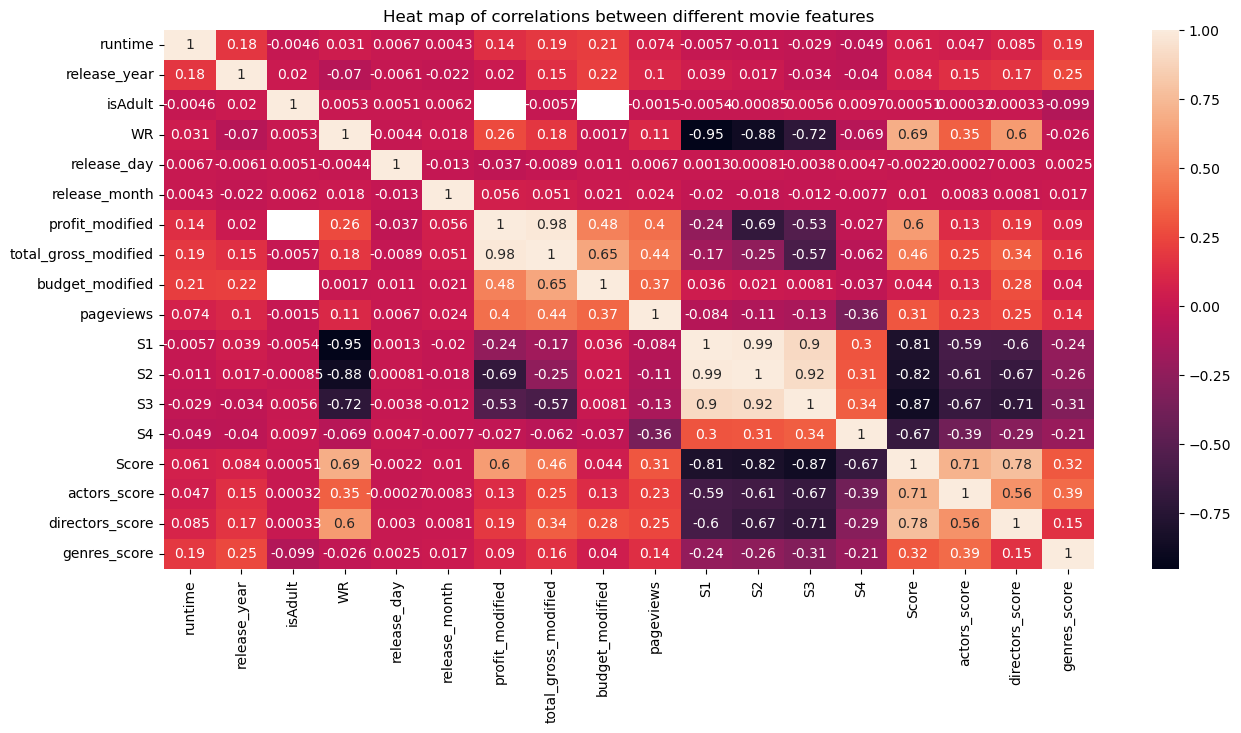

In [375]:
fig, ax = plt.subplots(figsize=(15,7))
sns.heatmap(df_all[[
    'runtime', 'release_year', 'isAdult', 'WR', 'release_day', 'release_month', 'profit_modified', 'total_gross_modified',
    'budget_modified', 'pageviews', 'S1', 'S2', 'S3', 'S4', 'Score', 'actors_score', 'directors_score', 'genres_score'
]].corr(), annot=True, ax=ax).set(title='Heat map of correlations between different movie features')

#### One hot encoding for list values

In [376]:
df_all_ohe = df_all.copy()

In [377]:
def one_hot_encoding_list(df, column_name, top_count):
    top = pd.Series([el for _list in df[column_name] for el in _list]).value_counts()[:top_count].index
    df[column_name] = df[column_name].apply(lambda _list: [el if el in top else 'Other' for el in _list])
    result = df.join(pd.get_dummies(df[column_name].apply(pd.Series).stack(), prefix=column_name).groupby(level=0).max())
    result.fillna({f'{column_name}_{el}': 0 for el in list(top) + ['Other']}, inplace=True)
    result.drop([column_name], axis=1, inplace=True)
    return result

In [378]:
def one_hot_encoding(df, column_name, top_count):
    top = df[column_name].value_counts()[:top_count].index
    df[column_name] = df[column_name].apply(lambda el: el if el in top else 'Other')
    result = df.join(pd.get_dummies(df[column_name], prefix=column_name).groupby(level=0).max())
    result.drop([column_name], axis=1, inplace=True)
    return result

In [379]:
df_all_ohe = one_hot_encoding_list(df_all_ohe, 'genre', 25)
df_all_ohe = one_hot_encoding_list(df_all_ohe, 'languages', 15)
df_all_ohe = one_hot_encoding_list(df_all_ohe, 'countries', 15)
df_all_ohe = one_hot_encoding_list(df_all_ohe, 'directors', 30)
df_all_ohe = one_hot_encoding_list(df_all_ohe, 'writers', 30)

/var/folders/m_/fhwnh1jn04qgx3nmt22_5h340000gn/T/ipykernel_15326/142190017.py:4: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  result = df.join(pd.get_dummies(df[column_name].apply(pd.Series).stack(), prefix=column_name).groupby(level=0).max())
/var/folders/m_/fhwnh1jn04qgx3nmt22_5h340000gn/T/ipykernel_15326/142190017.py:4: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  result = df.join(pd.get_dummies(df[column_name].apply(pd.Series).stack(), prefix=column_name).groupby(level=0).max())
/var/folders/m_/fhwnh1jn04qgx3nmt22_5h340000gn/T/ipykernel_15326/142190017.py:4: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  result = df.join(pd.get_dummies(

#### Expand the list values

In [229]:
df_all_expanded = df_all.copy()

In [230]:
df_all_expanded = df_all_expanded.explode('genre')
df_all_expanded = df_all_expanded.explode('languages')
df_all_expanded = df_all_expanded.explode('countries')
df_all_expanded = df_all_expanded.explode('directors')
df_all_expanded = df_all_expanded.explode('writers')

In [231]:
df_all_expanded.sample(5)

,freebase_id,name,runtime,languages,countries,release_year,isAdult,directors,writers,WR,...,pageviews,total_gross_modified_std,total_gross_modified_norm,S1,S2,S3,S4,Score,ethnicity_score,actor_name
11848,/m/03cn_g3,Babylon,95.0,English,United Kingdom,1980.0,0.0,Franco Rosso,Martin Stellman,7.398703,...,NaN,NaN,NaN,5525,7537,12983,52453,8.818425,NaN,NaN
2328,/m/0cvv_y,My Super Ex-Girlfriend,95.0,English,United States of America,2006.0,0.0,Ivan Reitman,Don Payne,5.200135,...,12947.094532,0.090179,0.005265,37326,1143,1697,2132,9.753168,2.0,"['Uma Thurman', 'Uma Thurman', 'Rainn Wilson',..."
51284,/m/0809nq6,In Pursuit,90.0,Spanish,United States of America,2001.0,NaN,NaN,NaN,NaN,...,226.011281,NaN,NaN,61013,61023,61819,23821,4.674748,2.0,"['Claudia Schiffer', 'Daniel Baldwin', 'Dean S..."
17342,/m/08f3y0,See Spot Run,97.0,English,Canada,2001.0,0.0,John Whitesell,Dan Baron,5.300879,...,4225.058465,NaN,NaN,36447,36756,38815,4835,8.314273,3.0,"['Paul Sorvino', 'Paul Sorvino', 'David Arquet..."
1497,/m/0bmch_x,Unknown,111.0,Arabic,Canada,2011.0,0.0,Jaume Collet-Serra,Didier Van Cauwelaert,6.800003,...,NaN,0.738481,0.011753,14496,594,822,47201,9.838292,1.0,"['Liam Neeson', 'Diane Kruger', 'January Jones..."


For the final dataset obtained, we gather data from 4 different sources. In order to not restrain ourselves to only common features and end up with a smaller dataset, we made the choice of outer merges filled with NaN. Indeed, if we had taken inner merge of all datasets, it might be that our final dataset is both small and not badly representative of the population. 

Having NaN values has however some consequences on our data analysis. It might be that the NaN are not fully random, for instance, runtime for Crime movies are all missing values while we have the runtime for all Comedies. This should ideally be investigated further to check the NaN are indeed random. In the framework of this milestone, the choice was to focus on other tasks. We will thus assume randomness of NaN values.



### Save dataframe to avoid running pre-processing

In [16]:
df_all.to_csv('./handled_data/dataframes/df_all.csv',encoding='utf-8')
df_all_expanded.to_csv('./handled_data/dataframes/df_all_expanded.csv',encoding='utf-8')
df_all_ohe.to_csv('./handled_data/dataframes/df_all_ohe.csv',encoding='utf-8')
characters.to_csv('./handled_data/dataframes/characters.csv',encoding='utf-8')

### Read processed dataframe to avoid running pre-processing

In [224]:
import ast
df_all = pd.read_csv('./handled_data/dataframes/df_all.csv',encoding='utf-8',index_col=0, na_values='',converters={column :ast.literal_eval for column in ['languages', 'countries', 'directors', 'writers', 'genre']})
df_all_expanded = pd.read_csv('./handled_data/dataframes/df_all_expanded.csv',encoding='utf-8',index_col=0)
df_all_ohe = pd.read_csv('./handled_data/dataframes/df_all_ohe.csv',encoding='utf-8',index_col=0)
characters = pd.read_csv('./handled_data/dataframes/characters.csv',encoding='utf-8',index_col=0)

/var/folders/m_/fhwnh1jn04qgx3nmt22_5h340000gn/T/ipykernel_15326/3425677836.py:3: DtypeWarning: Columns (8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all_expanded = pd.read_csv('./handled_data/dataframes/df_all_expanded.csv',encoding='utf-8',index_col=0)


### Impact of release date on success

To assess the impact of release date on success, we need to use the information on 'release_month' for each movie and need to choose a feature for success which can be either the IMDB weighted rating 'WR' or the gross revenue.

In [394]:
print(f"Out of {df_all.shape[0]} movies in out dataset, we have the release month information for {df_all['release_month'].count()} movies which is a big enough dataset to be representative.")

Out of 82605 movies in out dataset, we have the release month information for 43783 movies which is a big enough dataset to be representative.


In [395]:
df_release = df_all.dropna(how='all', subset=['release_month']) # Remove NaN months

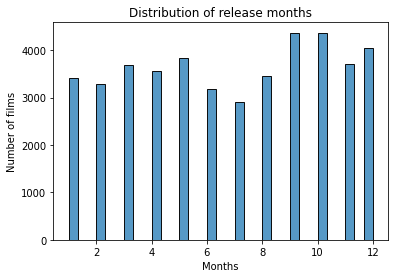

In [396]:
sns.histplot(x='release_month', data = df_release).set(title='Distribution of release months',xlabel='Months', ylabel='Number of films');

From the plot above, we can see that the distribution of release months is fairly homogeneous accross the data which allows to investigate success accross different release months.

In [397]:
df_release=df_release.sort_values(by='release_month', ascending=True)

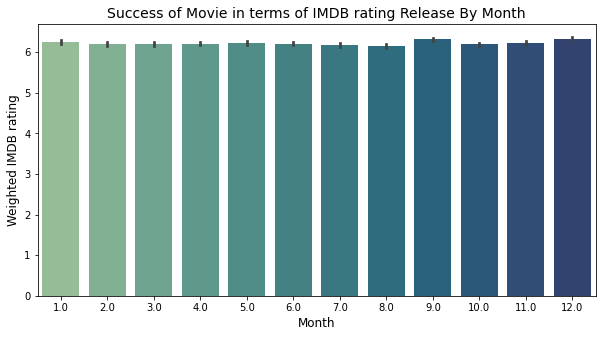

In [398]:
# Plot
plt.figure(figsize=(10,5));
ax = sns.barplot(x="release_month", y="WR",data=df_release,palette='crest');
plt.xlabel('Month', fontsize=12)
plt.ylabel('Weighted IMDB rating', fontsize=12)
plt.title('Success of Movie in terms of IMDB rating Release By Month', fontsize=14);

Text(0.5, 1.0, 'Success in terms of revenue of Movie Release By Month')

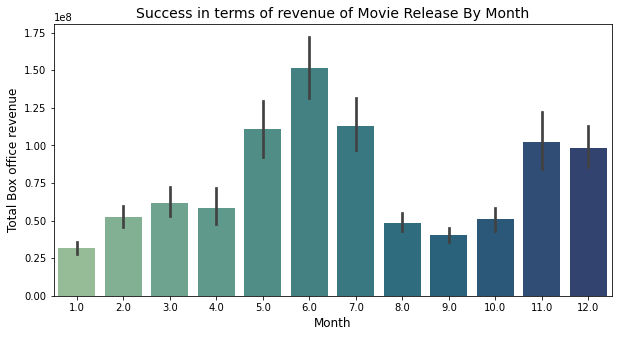

In [399]:
# Plot
plt.figure(figsize=(10,5))
ax = sns.barplot(x="release_month", y="total_gross_modified",data=df_release,palette='crest')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Box office revenue', fontsize=12)
plt.title('Success in terms of revenue of Movie Release By Month', fontsize=14)

As we can see from the results above, the movie weighted ratings are not at all influenced by the release period. However, the gross revenue is. We see that movies released in summer and in the end of the year are more successful.  Since the distribution of movies is fairly the same across our dataset, we can deduce that these periods are more favourable for movie release. It interesting to note that these results coincide with usual holidays periods where people have more time to go to the cinema. 

## What budget should be spent on a successful movie?

To see what budget should be spent on a successful movie, we want to compare mainly three features, the budget spent 'Production Budget', the profit made 'profit' and the weighted rating of the movie to account for successfulness 'WR'.


In [400]:
print(f"Out of {df_all.shape[0]} movies in out dataset, we have the profit information for {df_all['profit_modified'].count()} movies, total gross revenue information for {df_all['total_gross_modified'].count()} movies , budget information for {df_all['budget_modified'].count()} movies.")


Out of 82605 movies in out dataset, we have the profit information for 2464 movies, total gross revenue information for 8392 movies , budget information for 3828 movies.


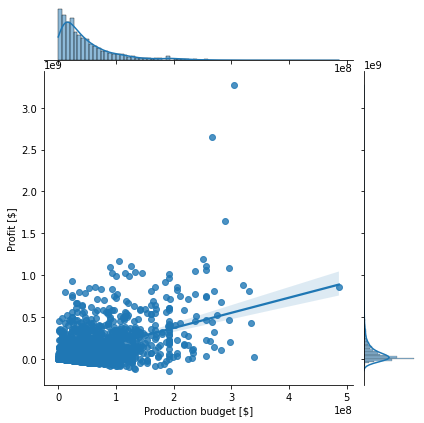

In [401]:
h = sns.jointplot(data=df_all, x='budget_modified', y='profit_modified', kind="reg");
h.ax_joint.set_xlabel('Production budget [$]');
h.ax_joint.set_ylabel('Profit [$]');

As we can see from the plot above, the positive trend line indicates that an increase in the budget will result in an increase in profit. However, there seems to be a lot of outliers. For our datastory (Milestone 3), it would be interesting to split this into two categories, high budget movies and average movies. Additionnaly, we will want to investigate if this budget trend is different across genres.

To compare the link between all three features, we build the pairplot below:

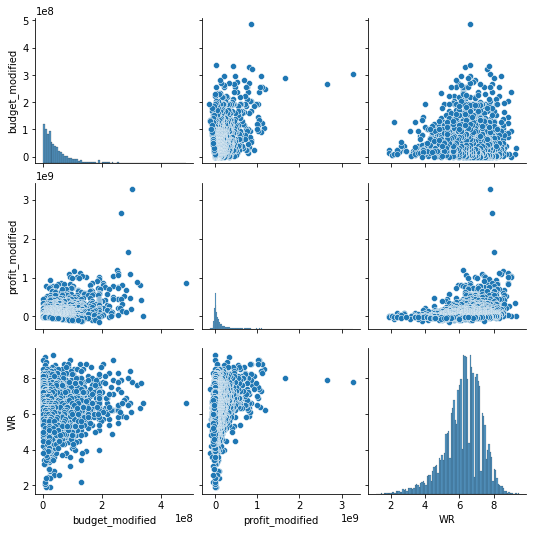

In [402]:
sns.pairplot(df_all[['budget_modified','profit_modified','WR']]);

### Top 20 most profitable movies

In [403]:
Top20_ProfitableMovies = df_all.sort_values('profit_modified', ascending=False).head(20)

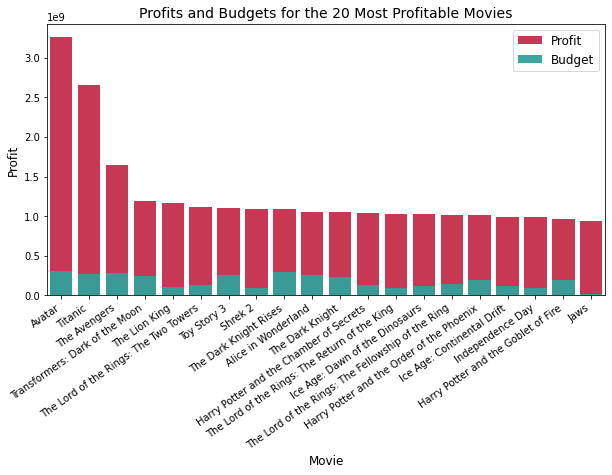

In [404]:
plt.figure(figsize=(10,5))
sns.barplot(x=Top20_ProfitableMovies['name'],y=Top20_ProfitableMovies['profit_modified'], 
            color='crimson', alpha=0.95, label='Profit', ci=None)
sns.barplot(x=Top20_ProfitableMovies['name'],y=Top20_ProfitableMovies['budget_modified'], 
            color='lightseagreen', alpha=0.95, label='Budget', ci=None)
plt.xlabel('Movie', fontsize=12)
plt.title("Profits and Budgets for the 20 Most Profitable Movies", fontsize=14)
plt.ylabel('Profit', fontsize=12)
plt.xticks(rotation=35, horizontalalignment='right', fontsize=10)
plt.legend(fontsize=12)

## Impact of director

In [405]:
(df_all_expanded['name'] + df_all_expanded['release_year'].astype('string')).duplicated() == False

23686     True
23686    False
23686    False
23686    False
23686    False
         ...  
82601    False
82601    False
82603     True
82603    False
82603    False
Length: 916591, dtype: bool

In [406]:
df_all_expanded.head()

,freebase_id,name,runtime,languages,countries,release_year,isAdult,directors,writers,WR,...,total_gross_modified,budget_modified,pageviews,total_gross_modified_std,total_gross_modified_norm,S1,S2,S3,S4,Score
23686,/m/0bth54,Avatar,178.0,English,United States of America,2009.0,0.0,James Cameron,James Cameron,7.799997,...,3.569937e+09,304094700.0,NaN,23.569749,0.240222,2113,1,1,46819,10.0
23686,/m/0bth54,Avatar,178.0,English,United Kingdom,2009.0,0.0,James Cameron,James Cameron,7.799997,...,3.569937e+09,304094700.0,NaN,23.569749,0.240222,2113,1,1,46819,10.0
23686,/m/0bth54,Avatar,178.0,Spanish,United States of America,2009.0,0.0,James Cameron,James Cameron,7.799997,...,3.569937e+09,304094700.0,NaN,23.569749,0.240222,2113,1,1,46819,10.0
23686,/m/0bth54,Avatar,178.0,Spanish,United Kingdom,2009.0,0.0,James Cameron,James Cameron,7.799997,...,3.569937e+09,304094700.0,NaN,23.569749,0.240222,2113,1,1,46819,10.0
23686,/m/0bth54,Avatar,178.0,English,United States of America,2009.0,0.0,James Cameron,James Cameron,7.799997,...,3.569937e+09,304094700.0,NaN,23.569749,0.240222,2113,1,1,46819,10.0


In [407]:
print(f"Out of {df_all.shape[0]} movies in out dataset, we have the director information for {df_all_expanded[(df_all_expanded['name'] + df_all_expanded['release_year'].astype('string')).duplicated() == False]['directors'].count()} movies coming from the IMDB data set.")

Out of 82605 movies in out dataset, we have the director information for 43724 movies coming from the IMDB data set.


In [408]:
df_director = df_all_expanded.dropna(how='all', subset=['directors']).drop_duplicates(['name', 'release_year', 'directors']) # Remove NaN directors

In [409]:
Top20_ProfitableMovies = df_director.sort_values('profit_modified', ascending=False).head(20)

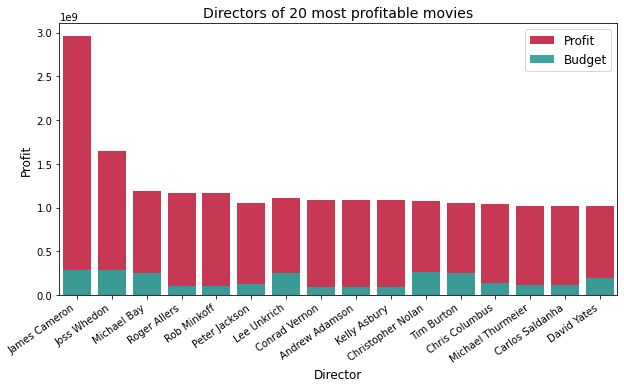

In [410]:
plt.figure(figsize=(10,5))
sns.barplot(x=Top20_ProfitableMovies['directors'], y=Top20_ProfitableMovies['profit_modified'], 
            color='crimson', alpha=0.95, label='Profit', ci=None)
sns.barplot(x=Top20_ProfitableMovies['directors'], y=Top20_ProfitableMovies['budget_modified'], 
            color='lightseagreen', alpha=0.95, label='Budget', ci=None)
plt.xlabel('Director', fontsize=12)
plt.title("Directors of 20 most profitable movies", fontsize=14)
plt.ylabel('Profit', fontsize=12)
plt.xticks(rotation=35, horizontalalignment='right', fontsize=10)
plt.legend(fontsize=12)

In [411]:
Top20_ProfitableMovies['directors']

23686        James Cameron
22242        James Cameron
28169          Joss Whedon
18633          Michael Bay
21419         Roger Allers
21419          Rob Minkoff
8815         Peter Jackson
69462          Lee Unkrich
59304        Conrad Vernon
59304       Andrew Adamson
59304         Kelly Asbury
54637    Christopher Nolan
9713            Tim Burton
38115    Christopher Nolan
41152       Chris Columbus
80736        Peter Jackson
38400    Michael Thurmeier
38400      Carlos Saldanha
79796        Peter Jackson
17912          David Yates
Name: directors, dtype: object

## Impact of actors

In order to assess the added value of actors to a movie's success, it is necessary to define the success of individual actors. To do this, we first create an actors dataset. We also compute in how many films in the dataset the actor appears, this value can be found in the column `num_movies`.

In [412]:
characters
pd.merge(characters, df_all, how='left', left_on='freebase_movie_id', right_on='freebase_id')

,wikipedia_movie_id,freebase_movie_id,movie_release_date,character_name,actor_birthdate,actor_gender,actor_height_meters,actor_ethnicity_freebase_id,actor_name,actor_age_at_movie_release,...,total_gross_modified,budget_modified,pageviews,total_gross_modified_std,total_gross_modified_norm,S1,S2,S3,S4,Score
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,...,1.870026e+07,NaN,16013.456439,-0.310254,0.001258,39158.0,39322.0,3824.0,1786.0,9.445138
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,...,1.870026e+07,NaN,16013.456439,-0.310254,0.001258,39158.0,39322.0,3824.0,1786.0,9.445138
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,...,1.870026e+07,NaN,16013.456439,-0.310254,0.001258,39158.0,39322.0,3824.0,1786.0,9.445138
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,...,1.870026e+07,NaN,16013.456439,-0.310254,0.001258,39158.0,39322.0,3824.0,1786.0,9.445138
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,...,1.870026e+07,NaN,16013.456439,-0.310254,0.001258,39158.0,39322.0,3824.0,1786.0,9.445138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
453620,913762,/m/03pcrp,1992-05-21,Elensh,1970-05,F,NaN,NaN,Dorothy Elias-Fahn,NaN,...,NaN,NaN,28.143610,NaN,NaN,81554.0,81554.0,81554.0,38614.0,2.274605
453621,913762,/m/03pcrp,1992-05-21,Hibiki,1965-04-12,M,NaN,NaN,Jonathan Fahn,27.0,...,NaN,NaN,28.143610,NaN,NaN,81554.0,81554.0,81554.0,38614.0,2.274605
453622,28308153,/m/0cp05t9,1957,NaN,1941-11-18,M,1.730,/m/02w7gg,David Hemmings,15.0,...,NaN,NaN,83.275939,NaN,NaN,4835.0,6910.0,12459.0,31060.0,8.956573
453623,28308153,/m/0cp05t9,1957,NaN,NaN,NaN,NaN,NaN,Roberta Paterson,NaN,...,NaN,NaN,83.275939,NaN,NaN,4835.0,6910.0,12459.0,31060.0,8.956573


In [413]:
characters.columns

Index(['wikipedia_movie_id', 'freebase_movie_id', 'movie_release_date',
       'character_name', 'actor_birthdate', 'actor_gender',
       'actor_height_meters', 'actor_ethnicity_freebase_id', 'actor_name',
       'actor_age_at_movie_release', 'freebase_character_actor_map_id',
       'freebase_character_id', 'freebase_actor_id', 'name', 'ethnicity_label',
       'major_ethnicity'],
      dtype='object')

In [414]:
actors = pd.merge(characters, df_all, how='left', left_on='freebase_movie_id', right_on='freebase_id')
actors.columns

Index(['wikipedia_movie_id', 'freebase_movie_id', 'movie_release_date',
       'character_name', 'actor_birthdate', 'actor_gender',
       'actor_height_meters', 'actor_ethnicity_freebase_id', 'actor_name',
       'actor_age_at_movie_release', 'freebase_character_actor_map_id',
       'freebase_character_id', 'freebase_actor_id', 'name_x',
       'ethnicity_label', 'major_ethnicity', 'freebase_id', 'name_y',
       'runtime', 'languages', 'countries', 'release_year', 'isAdult',
       'directors', 'writers', 'WR', 'genre', 'release_day', 'release_month',
       'profit_modified', 'total_gross_modified', 'budget_modified',
       'pageviews', 'total_gross_modified_std', 'total_gross_modified_norm',
       'S1', 'S2', 'S3', 'S4', 'Score'],
      dtype='object')

In [415]:
actors = pd.merge(characters, df_all, how='left', left_on='freebase_movie_id', right_on='freebase_id')
actors = actors[['freebase_actor_id', 'freebase_movie_id', 'actor_name', 'actor_gender', 'actor_height_meters', 'ethnicity_label', 'major_ethnicity', 'WR']]
actors = actors.dropna(subset=['freebase_actor_id'])
#actors['mean_WR'] = actors.groupby(by=['freebase_actor_id']).mean(numeric_only=True)['WR']

actors['num_movies'] = actors.groupby(by=['freebase_actor_id'])['freebase_actor_id'].transform('size')
actors['WR_mean'] = actors[['freebase_actor_id', 'WR']].groupby(by=['freebase_actor_id']).transform('mean')
actors.drop(['freebase_movie_id'], axis=1, inplace=True)
actors.drop_duplicates(subset=['freebase_actor_id'], inplace=True)


In [416]:
characters.groupby('actor_name').count()

,wikipedia_movie_id,freebase_movie_id,movie_release_date,character_name,actor_birthdate,actor_gender,actor_height_meters,actor_ethnicity_freebase_id,actor_age_at_movie_release,freebase_character_actor_map_id,freebase_character_id,freebase_actor_id,name,ethnicity_label,major_ethnicity
actor_name,,,,,,,,,,,,,,,
Cesarine Prinz\t,2,2,2,0,2,2,0,0,0,2,0,2,2,0,0
Daniel Newman,1,1,1,1,1,1,0,0,1,1,1,1,1,0,0
'Big Bill' Giddinger,1,1,1,0,0,1,0,0,0,1,0,1,1,0,0
'Big' Lee,1,1,1,1,0,1,0,0,0,1,1,1,1,0,0
'Chicken' Holleman,1,1,1,0,0,0,0,0,0,1,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
雅-miyavi-,1,1,1,0,1,1,1,0,1,1,0,1,1,0,0
雪乃五月,2,2,2,0,2,2,0,0,2,2,0,2,2,0,0
高山久子,3,3,3,1,3,3,0,0,3,3,1,3,3,0,0


In [417]:
#Apply weighting to score
WR_actors_mean = np.mean(actors.WR_mean)
min_movies = 1

def isNan(value):
    return value!=value

def get_weigthed_WR(WR, num_movies):
    if not isNan(WR) and not isNan(num_movies):
        if num_movies > min_movies:
            return num_movies/(num_movies + min_movies) * WR + min_movies/(num_movies + min_movies) * WR_actors_mean
    return np.nan

actors['WR'] = actors.apply(lambda row: get_weigthed_WR(row['WR_mean'], row['num_movies']), axis=1)



In [418]:
actors.head()

,freebase_actor_id,actor_name,actor_gender,actor_height_meters,ethnicity_label,major_ethnicity,WR,num_movies,WR_mean
0,/m/03wcfv7,Wanda De Jesus,F,1.620,NaN,NaN,5.512609,8,5.435887
1,/m/0346l4,Natasha Henstridge,F,1.780,unknown,NaN,5.337700,23,5.303409
2,/m/01vw26l,Ice Cube,M,1.727,African Americans,Black,5.735950,33,5.724118
3,/m/034hyc,Jason Statham,M,1.750,NaN,NaN,6.466230,31,6.477193
4,/m/01y9xg,Clea DuVall,F,1.650,NaN,NaN,6.323573,31,6.329934


In [419]:
top_20_actors = actors.dropna(subset=['WR']).sort_values(by='WR', ascending=False).iloc[0:20]

top_20_actors.head()

,freebase_actor_id,actor_name,actor_gender,actor_height_meters,ethnicity_label,major_ethnicity,WR,num_movies,WR_mean
3452,/m/02wk8g,Gigi Leung,F,NaN,NaN,NaN,8.464958,18,8.594879
93331,/m/0bfn08s,János Derzsi,M,NaN,NaN,NaN,8.464410,7,8.798414
50643,/m/03gqpqy,Paul Chun,M,NaN,NaN,NaN,8.440598,15,8.594879
13449,/m/09vw0_q,Tôru Minegishi,M,NaN,NaN,NaN,8.434090,5,8.895631
135697,/m/06l0c3,Simonetta Stefanelli,F,NaN,NaN,NaN,8.431592,3,9.199994


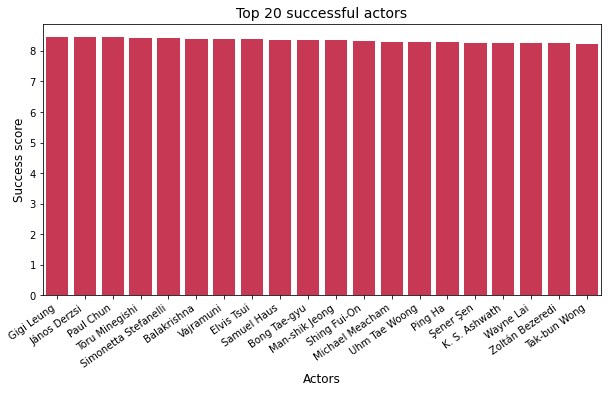

In [420]:
plt.figure(figsize=(10,5));
sns.barplot(x=top_20_actors['actor_name'],y=top_20_actors['WR'], 
            color='crimson', alpha=0.95, ci=None);
plt.xlabel('Actors', fontsize=12);
plt.title("Top 20 successful actors", fontsize=14);
plt.ylabel('Success score', fontsize=12);
plt.xticks(rotation=35, horizontalalignment='right', fontsize=10);

In [421]:
actors_score.sort_values('WScore',ascending=True,inplace=True)
top_20_actors = actors_score.iloc[0:20]
top_20_actors.head()

KeyError: 'WScore'

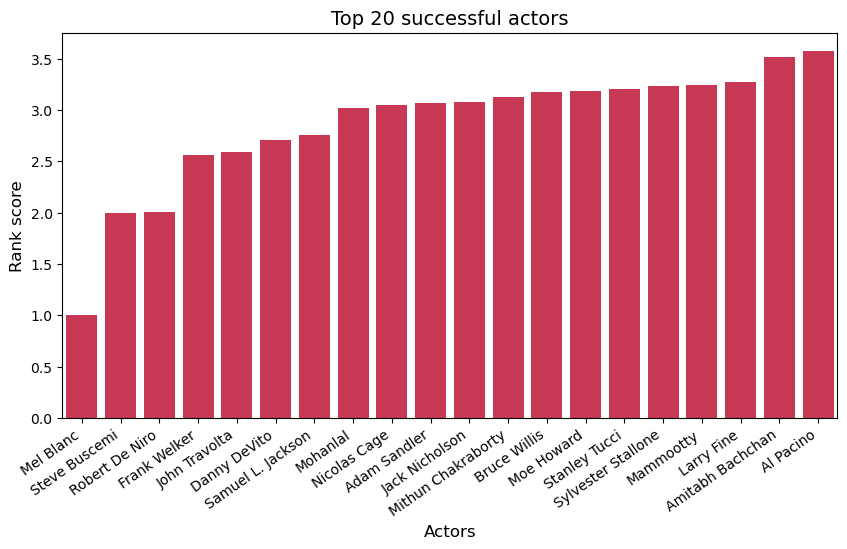

In [ ]:
plt.figure(figsize=(10,5));
sns.barplot(x=top_20_actors['actor_name'],y=top_20_actors['WScore'], 
            color='crimson', alpha=0.95, ci=None);
plt.xlabel('Actors', fontsize=12);
plt.title("Top 20 successful actors", fontsize=14);
plt.ylabel('Rank score', fontsize=12);
plt.xticks(rotation=35, horizontalalignment='right', fontsize=10);

### TO UPDATE ANYTHING BELOW

In [422]:
print(f"Out of {df_all.shape[0]} movies in out dataset, we have the 1st actor information for {df_all['Star1'].count()} movies coming from the top 1000 IMDB data set.")

KeyError: 'Star1'

For now, we only consider the main actor of a movie but this can be extrapolated to all actors accross multiple movies for our next milestone. 

In [423]:
df_main_actor = df_all.dropna(how='all', subset=['Star1']) # Remove NaN actors

KeyError: ['Star1']

In [424]:
Top20_ProfitableMovies = df_main_actor.sort_values('profit_modified', ascending=False).head(20)

NameError: name 'df_main_actor' is not defined

In [425]:
plt.figure(figsize=(10,5))
sns.barplot(x=Top20_ProfitableMovies['Star1'],y=Top20_ProfitableMovies['profit_modified'], 
            color='crimson', alpha=0.95, label='Profit', ci=None)
sns.barplot(x=Top20_ProfitableMovies['Star1'],y=Top20_ProfitableMovies['budget_modified'], 
            color='lightseagreen', alpha=0.95, label='Budget', ci=None)
plt.xlabel('Actors', fontsize=12)
plt.title("Actors of 20 most profitable movies", fontsize=14)
plt.ylabel('Profit', fontsize=12)
plt.xticks(rotation=35, horizontalalignment='right', fontsize=10)
plt.legend(fontsize=12)

KeyError: 'Star1'

<Figure size 720x360 with 0 Axes>

For our datastory, the goal would be to cluster actors accross genres. That way, we can forecast which actor would be best to select for a particular genre to boost success.

## Popular features in characters

The characters table is splitted between actors and actresses to study each gender as a whole different group.

In [428]:
characters_male = characters[characters['actor_gender'] == 'M']
characters_female = characters[characters['actor_gender'] == 'F']

The following plot presents the height distribution for the actors and actresses. We can see that men tend to be taller than women actors. Also, it can be seen that in the dataset there are way more men than women

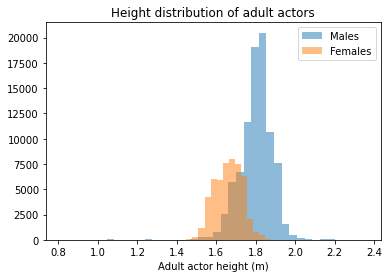

In [429]:
def filter_children(characters):
    LIMIT_CHILDREN_AGE = 14
    return characters[(characters['actor_age_at_movie_release'] > LIMIT_CHILDREN_AGE)]

def characters_height_histogram(characters, bins):
    characters_height = characters.dropna(subset=['actor_height_meters'])
    plt.hist(characters_height['actor_height_meters'],bins=bins, alpha=0.5)
    plt.legend(['Males', 'Females'])
    plt.xlabel('Adult actor height (m)')
    plt.title('Height distribution of adult actors')

characters_height_histogram(filter_children(characters_male), bins=40)
characters_height_histogram(filter_children(characters_female), bins=25)


Another important characteristic we can study is the age on movie release. Again, there is a huge difference between women and men. Women play roles when they are younger, while men seem to have longer careers.

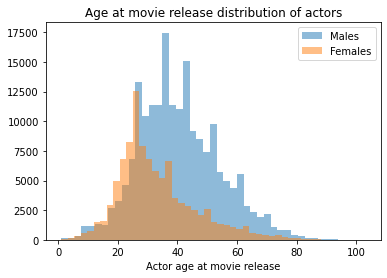

In [430]:
def characters_age_histogram(characters):
    characters_age = characters.dropna(subset=['actor_age_at_movie_release']).sort_values(by=['actor_age_at_movie_release'])
    characters_age = characters_age[characters_age['actor_age_at_movie_release'] > 0]
    plt.hist(characters_age['actor_age_at_movie_release'], bins=45, alpha=0.5)
    plt.legend(['Males', 'Females'])
    plt.xlabel('Actor age at movie release')
    plt.title('Age at movie release distribution of actors')

characters_age_histogram(characters_male)
characters_age_histogram(characters_female)

The following plot shows the ethnicity distribution for actors and actresses of the dataset. It can be seen how white people clearly dominate the characters dataset by more than a half of it. Indians are also a big group representing 1/4 of the ethnicities. In this case, the difference between genders is not that big.

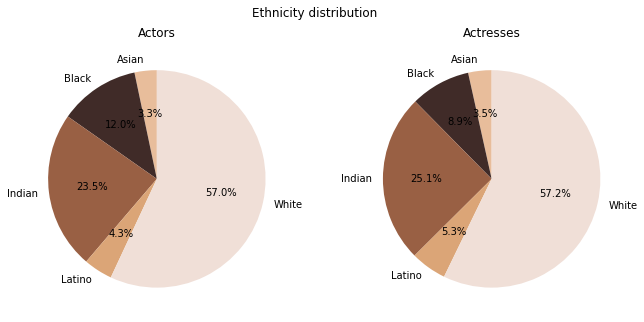

In [431]:
def pie_chart_actor_ethnicities(actors, title, ax):
    actors_ethnicity = actors.dropna(subset=['major_ethnicity'])
    actors_ethnicity = actors_ethnicity[actors_ethnicity['major_ethnicity'] != 'unknown']
    ethnicities, counts = np.unique(actors_ethnicity['major_ethnicity'], return_counts=True)
    #print(np.sort(counts))
    others_count = 0
    plot_ethnicities = []
    plot_counts = []
    ETHNICITY_THRESHOLD = 1
    for ethnicity, count in zip(ethnicities, counts):
        if count > ETHNICITY_THRESHOLD:
            plot_ethnicities.append(ethnicity)
            plot_counts.append(count)
        else:
            others_count += count

    colors = ['#e8bd9b','#402b28','#996044','#dba577','#f0dfd7']

    ax.pie(plot_counts, labels=plot_ethnicities, startangle=90,autopct='%1.1f%%',colors=colors, radius=1)
    ax.set_title(title)

def two_pie_charts_actor_ethnicities(actors1, actors2, title, title1, title2):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_facecolor('white')
    fig.set_size_inches(11, 5)
    fig.suptitle(title)

    pie_chart_actor_ethnicities(actors1, title1, ax1)
    pie_chart_actor_ethnicities(actors2, title2, ax2)
    plt.show()


two_pie_charts_actor_ethnicities(characters_male, 
                                 characters_female, 
                                 title='Ethnicity distribution', 
                                 title1='Actors', 
                                 title2='Actresses')

The next plot shows the number of different ethnicities per movie. For instance, a movie that includes at least one Indian and one Black actress has 2 different ethnicities. As we can see, the vast majority of the films only have one ethnicity on it.

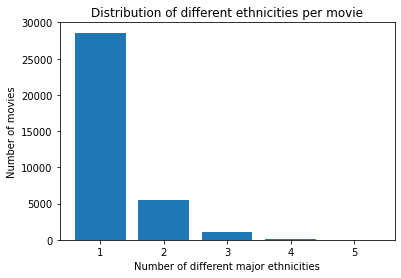

In [432]:
def plot_different_ethnicities_per_movie(characters):
    ethnicity_characters = characters.dropna(subset=['major_ethnicity'])
    num_different_ethnicities = ethnicity_characters.groupby(by=['freebase_movie_id'])['major_ethnicity'].nunique()
    num_ethnicies, count = np.unique(num_different_ethnicities, return_counts=True)
    plt.bar(num_ethnicies, count)
    plt.xlabel('Number of different major ethnicities')
    plt.ylabel('Number of movies')
    plt.title('Distribution of different ethnicities per movie')
plot_different_ethnicities_per_movie(characters)

(array(['Asian', 'Black', 'Indian', 'Latino', 'White'], dtype=object), array([ 3010, 10022, 20954,  4179, 51618], dtype=int64))


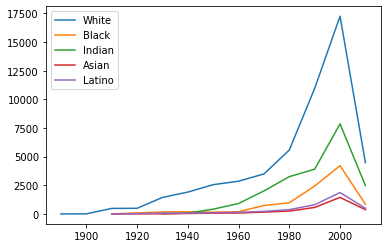

In [433]:
characters_eth = characters.dropna(subset=['major_ethnicity', 'movie_release_date'])
print(np.unique(characters_eth['major_ethnicity'], return_counts=True))

movies_release_year = df_all[['release_year', 'freebase_id']].dropna(subset='freebase_id')
characters_eth = pd.merge(left=characters_eth, right=movies_release_year, how='left', left_on='freebase_movie_id', right_on='freebase_id').drop(columns='freebase_id')
characters_eth['decade'] = np.trunc(characters_eth['release_year']/10)*10
characters_eth = characters_eth[['actor_name', 'decade', 'major_ethnicity', 'freebase_actor_id', 'freebase_movie_id']]
characters_eth_counts = characters_eth.groupby(by=['decade', 'major_ethnicity']).count()

ethnicities = ['White', 'Black', 'Indian', 'Asian', 'Latino']
char_counts_eth = []
decades = np.array([1880, 1890, 1900, 1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010])*1.0

for ethnicity in ethnicities:
    char_counts = characters_eth_counts['actor_name'][:, ethnicity]
    char_counts_eth.append(char_counts)
    total = np.sum(char_counts)
    plt.plot(char_counts)


plt.legend(ethnicities)
plt.show()

# eth_percentages = []
# for idx, eth in enumerate(ethnicities):
#     eth_idx = []
#     for decade in decades:
        

#for dec in decades:
#    print(char_counts_eth[:,dec])

In [434]:
example_eth = '/m/011xg5'
movies_ethnicity_score = characters_eth.groupby(by=['freebase_movie_id'])['major_ethnicity'].nunique().to_frame()
movies_ethnicity_score.rename(columns={'major_ethnicity': 'ethnicity_score'}, inplace=True)
movies_ethnicity_score.reset_index(inplace=True)
df_all = pd.merge(df_all, movies_ethnicity_score, how='left', left_on='freebase_id', right_on='freebase_movie_id').drop(columns='freebase_movie_id')

In [436]:
df_all.to_csv('./handled_data/dataframes/df_all.csv',encoding='utf-8')

Again, let's split actors in genders

In [ ]:
actors_male = actors[actors['actor_gender'] == 'M']
actors_female = actors[actors['actor_gender'] == 'F']

And now we can focus on the actors that have appeared in a greater number of movies. We fix this threshold at 15 movies.

In [ ]:
def get_most_demanded_actors(actors, min_num_movies):
    return actors[actors['num_movies'] >= min_num_movies]

MIN_NUM_MOVIES_DEMANDED_ACTOR = 5
demanded_actors_male = get_most_demanded_actors(actors_male, MIN_NUM_MOVIES_DEMANDED_ACTOR)
demanded_actors_female = get_most_demanded_actors(actors_female, MIN_NUM_MOVIES_DEMANDED_ACTOR)


This way, we can compare if the most characteristic features of each actor are the same for the whole dataset of characters. We are plotting again the height distribution both for males and females.

In [ ]:
characters_height_histogram(demanded_actors_male, 40)
characters_height_histogram(demanded_actors_female, 15)

Also, the ethnicities are plotted again. We can observe that discriminations are even bigger.

In [ ]:
two_pie_charts_actor_ethnicities(demanded_actors_male, 
                                demanded_actors_female, 
                                 title='Top actors ethnicity distribution', 
                                 title1='Actors', 
                                 title2='Actresses')

All these data about characters is going to be merged and analysed for the last milestone. By now, we have demonstrated that we have data enough to work and answer the proper questions

Get score for actors and actresses

In [ ]:
df_test = df_all.dropna(subset=['WR'])
df_test.sort_values(by='WR', ascending=False)

# def isNaN(string):
#     return string!=string

# def get_movie_feature_by_id(freebase_movie_id, feature):
#     if not isNaN(freebase_movie_id):
#         #print(freebase_movie_id)
#         a = df_test.loc[df_all['freebase_id'] == freebase_movie_id]
#         if (len(a) > 0):
#             print(a[feature])
#             return a[feature][0].item()
#     return np.nan


# # characters['movie_score'] = characters.apply(lambda row : get_movie_feature_by_id(row['freebase_movie_id'], 'WR'), axis=1)

# # characters.dropna(subset='movie_score')

# # characters.iloc[0]['freebase_movie_id']

# characters.apply(lambda row : get_movie_feature_by_id(row['freebase_movie_id'], 'WR'), axis=1)


## What genres are the most profitable?

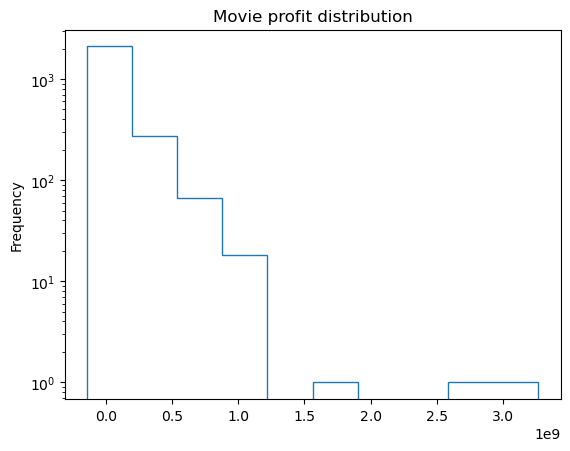

In [250]:
df_all['profit_modified'].plot(kind='hist', logy=True, histtype='step', title='Movie profit distribution');

In [251]:
df_genre = df_all_expanded.dropna(how='all', subset=['genre']).drop_duplicates(['name', 'release_year', 'genre'])

In [252]:
genres = df_genre['genre'].value_counts()

In [ ]:
genres[genres > 1000].plot(kind='bar', title='Movie genres distribution');

In [ ]:
plt.figure(figsize=(15,5));
ax = sns.barplot(
    x="genre",
    y="profit_modified",
    data=df_genre[df_genre['profit_modified'].notna() & df_genre['genre'].isin(genres[genres > 1000].index.to_list())],
    palette='crest'
)
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Profit', fontsize=12)
plt.title('Success of Movie based on genre in terms of the profit', fontsize=14)
_ = plt.xticks(rotation=90)

## Correlation between the choice of topics and movie profitability can be investigated

In [ ]:
df_genre['genre_category'] = df_genre['genre'].astype('category').cat.codes

In [ ]:
fig, ax = plt.subplots(figsize=(15,7))
sns.heatmap(df_genre.corr(), annot=True, ax=ax).set(title='Heat map of correlations between different movie features');

## Clustering between movies: Classics VS forgettable : check with wikipedia ID how much it is visited : time series of access 

In [ ]:
df_all_ohe.sample(5)

In [ ]:
df_all_ohe_cleaned_columns = df_all_ohe.rename({c: c.replace('/', '').replace('.', '').replace(' ', '').replace('\'', '').replace('-', '') for c in df_all_ohe.columns}, axis=1)

In [ ]:
mod = smf.ols(formula=
    'pageviews ~ runtime + release_year + WR + release_month + profit_modified + genre_Action + ' +
    'genre_ActionAdventure + genre_Adventure + genre_Animation + genre_Blackandwhite + genre_Comedy + ' +
    'genre_Comedyfilm + genre_CrimeFiction + genre_Documentary + genre_Drama + genre_FamilyFilm + ' + 
    'genre_Fantasy + genre_Horror + genre_Indie + genre_Musical + genre_Mystery + genre_Other + ' + 
    'genre_RomanceFilm + genre_Romanticcomedy + genre_Romanticdrama + genre_ScienceFiction + genre_ShortFilm + ' + 
    'genre_Silentfilm + genre_Thriller + genre_Warfilm + genre_Worldcinema + languages_Cantonese + ' + 
    'languages_English + languages_French + languages_German + languages_Hindi + languages_Italian + ' + 
    'languages_Japanese + languages_Korean + languages_Malayalam + languages_Other + languages_Russian + ' + 
    'languages_Silentfilm + languages_Spanish + languages_StandardMandarin + languages_Tamil + languages_Telugu + ' + 
    'countries_Argentina + countries_Australia + countries_Canada + countries_France + countries_Germany + ' + 
    'countries_HongKong + countries_India + countries_Italy + countries_Japan + countries_Mexico + ' + 
    'countries_Netherlands + countries_Other + countries_SouthKorea + countries_Spain + countries_UnitedKingdom + ' + 
    'countries_UnitedStatesofAmerica + directors_AlfredHitchcock + directors_CecilBDeMille + ' + 
    'directors_CharlesChaplin + directors_CharlesLamont + directors_ChuckJones + directors_DWGriffith + ' + 
    'directors_DaveFleischer + directors_FrizFreleng + directors_GeorgeCukor + directors_GeorgeMarshall + ' + 
    'directors_GordonDouglas + directors_HenryHathaway + directors_JohnFord + directors_JosephBarbera + ' + 
    'directors_JosephKane + directors_JulesWhite + directors_MichaelCurtiz + directors_NormanTaurog + ' + 
    'directors_Other + directors_RaoulWalsh + directors_RayTaylor + directors_RichardThorpe + directors_RobertFMcGowan + ' + 
    'directors_RobertFlorey + directors_RobertMcKimson + directors_RoscoeFattyArbuckle + directors_SamNewfield + ' + 
    'directors_WilliamAWellman + directors_WilliamBeaudine + directors_WilliamHanna + directors_WilliamWitney + ' + 
    'writers_ArthurConanDoyle + writers_BasilDickey + writers_BenHecht + writers_CareyWilson + writers_CharlesChaplin + ' + 
    'writers_CharlesDickens + writers_DWGriffith + writers_DudleyNichols + writers_EdgarRiceBurroughs + writers_ElwoodUllman + ' + 
    'writers_FelixAdler + writers_FrancesMarion + writers_GeorgeHPlympton + writers_GopalakrishnaParuchuri + writers_HMWalker + ' + 
    'writers_HalRoach + writers_JohnWDunn + writers_KaderKhan + writers_MichaelMaltese + writers_NunnallyJohnson + writers_Other + ' + 
    'writers_ParuchuriVenkateswaraRao + writers_RahiMasoomReza + writers_RobertAMcGowan + writers_SachinBhowmick + writers_Satyanand + ' + 
    'writers_StephenKing + writers_TeddPierce + writers_ValGuest + writers_WarrenFoster + writers_WilliamShakespeare',
  data=df_all_ohe_cleaned_columns)
np.random.seed(2)
res = mod.fit()
res.summary()

## Countries

In [ ]:
# sort by country
import json
movies_header = ['wikipedia_id', 'freebase_id', 'name', 'release_date', 'box_office_revenue', 'runtime', 'languages', 'countries', 'genres']
movies = pd.read_csv('data/movie.metadata.tsv', sep='\t', header=None, names=movies_header)
data = pd.read_csv('data/movie.metadata.tsv', sep='\t', header=None, names=movies_header)
movies.head(5)
print(movies.shape)
# movies=movies['countries'].apply(lambda row: len((eval(row).values())))
movies=movies['countries'].apply(lambda row: (eval(row).values()))
movies= pd.DataFrame(movies,columns=['countries'])
# movies['countries'].apply(len)
# movies.describe()
movies.head()


In [ ]:


# movies=movies['countries'].apply(lambda row: (eval(row).values()))
# movies= pd.DataFrame(movies,columns=['countries'])
exploded=pd.DataFrame([[c] for C in movies['countries'] for c in C],columns=['countries'])
len(exploded['countries'].unique())
count=exploded['countries'].value_counts()
count.to_csv('test.csv')
# US=movies['countries'].apply(lambda lis : "United States of America" in lis and len(lis)==1)
US=movies['countries'].apply(lambda lis : "United States of America" in lis)
US_movies=data.loc[US]
print('number of movies made in the US: ',US.sum())
IN=movies['countries'].apply(lambda lis : "India" in lis)
IN_movies=movies[IN]
print('number of movies made in india: ',IN.sum())

mult=movies['countries'].apply(lambda lis : len(lis)>1)
print('number of movies made in more than one country: ',sum(mult))


In [ ]:

# one list with all the countries of all the movies
exploded=pd.DataFrame([[c] for C in movies['countries'] for c in C],columns=['countries'])
len(exploded['countries'].unique())
count=exploded['countries'].value_counts()
count.to_csv('handled_data/test.csv')


In [ ]:



from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(15,7))
plt.bar(count.head(20).index.to_series(),count.head(20))
plt.xticks(rotation=60, horizontalalignment='right', fontsize=12);
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(15,7))
plt.bar(count[1:51].index.to_series(),count[1:51])
plt.xticks(rotation=60, horizontalalignment='right', fontsize=12);


In [ ]:


# sort movies by date 
data[(data['release_date']<'2000') & (data['release_date']>='1995')]
set1=data[data['release_date']<'1985']
set2=data[data['release_date']>'1985']
set1=set1['countries']
set2=set2['countries']
def analysis(set) :
    set=set.apply(lambda row: (eval(row).values()))
    set= pd.DataFrame(set,columns=['countries'])
    exploded=pd.DataFrame([[c] for C in set['countries'] for c in C],columns=['countries'])
    # len(exploded['countries'].unique())
    count=exploded['countries'].value_counts()
    count.to_csv('test.csv')
    return count

c1=analysis(set1)
c2=analysis(set2)


In [ ]:
fig, ax = plt.subplots(figsize=(11,5))
# fig.set_facecolor('white')
# fig.set_size_inches(11, 5)
# fig.suptitle('title')
plot_counts=c1.head(5)
plot_countries=plot_counts.index.to_series()
ax.pie(plot_counts, labels=plot_countries, startangle=90,autopct='%1.1f%%', radius=1)
ax.set_title('top 5 countries by number of movies before 1985')
plt.show()
# plot_countries


In [ ]:

fig, ax = plt.subplots(figsize=(11,5))
# fig.set_facecolor('white')
# fig.set_size_inches(11, 5)
# fig.suptitle('title')
plot_counts=c2.head(5)
plot_countries=plot_counts.index.to_series()
ax.pie(plot_counts, labels=plot_countries, startangle=90,autopct='%1.1f%%', radius=1)
ax.set_title('top 5 countries by number of movies after 1985')
plt.show()

# Train NN for predicting revenue

In [232]:
df_all_ohe.columns

Index(['freebase_id', 'name', 'runtime', 'release_year', 'isAdult', 'WR',
       'release_day', 'release_month', 'profit_modified',
       'total_gross_modified',
       ...
       'writers_Other', 'writers_Paruchuri Venkateswara Rao',
       'writers_Rahi Masoom Reza', 'writers_Robert A. McGowan',
       'writers_Sachin Bhowmick', 'writers_Satyanand', 'writers_Stephen King',
       'writers_Tedd Pierce', 'writers_Warren Foster',
       'writers_William Shakespeare'],
      dtype='object', length=141)

In [233]:
df_all.describe()

,runtime,release_year,isAdult,WR,release_day,release_month,profit_modified,total_gross_modified,budget_modified,pageviews,total_gross_modified_std,total_gross_modified_norm,S1,S2,S3,S4,Score,ethnicity_score
count,68104.000000,75770.000000,44031.000000,44031.000000,40527.000000,43783.000000,2.464000e+03,8.392000e+03,3.828000e+03,46823.000000,8.392000e+03,8.392000e+03,82605.00000,82605.00000,82605.00000,82605.00000,82605.000000,33531.000000
mean,93.965487,1977.970463,0.002566,6.224498,15.658129,6.707718,9.605612e+07,6.483874e+07,5.092346e+07,2734.818491,1.016029e-17,4.363016e-03,41303.00000,41303.00000,41303.00000,41303.00000,5.681350,1.230145
std,59.949382,29.227202,0.050595,1.102334,8.708535,3.483166,1.897343e+08,1.487117e+08,5.505716e+07,11517.211493,1.000000e+00,1.000685e-02,23846.15383,23846.15383,23846.15383,23846.15383,2.704260,0.505826
min,0.000000,1010.000000,0.000000,1.131770,1.000000,1.000000,-1.424334e+08,1.138400e+04,8.981700e+03,0.000000,-4.359263e-01,7.660325e-07,1.00000,1.00000,1.00000,1.00000,0.000000,1.000000
25%,80.000000,1956.000000,0.000000,5.614247,8.000000,4.000000,6.762006e+05,2.803050e+06,1.411410e+07,47.083004,-4.171539e-01,1.886180e-04,20652.00000,20652.00000,20652.00000,20652.00000,3.515480,1.000000
50%,93.000000,1986.000000,0.000000,6.317251,16.000000,7.000000,3.261206e+07,1.456574e+07,3.255200e+07,238.284585,-3.380567e-01,9.801326e-04,41303.00000,41303.00000,41303.00000,41303.00000,5.936719,1.000000
75%,108.000000,2004.000000,0.000000,6.998635,23.000000,10.000000,1.156132e+08,5.778973e+07,6.673500e+07,1094.704134,-4.740050e-02,3.888687e-03,61954.00000,61954.00000,61954.00000,61954.00000,8.036496,1.000000
max,5700.000000,2020.000000,1.000000,9.467126,31.000000,12.000000,3.265843e+09,3.569937e+09,4.862949e+08,410868.409091,2.356975e+01,2.402221e-01,82605.00000,82605.00000,82605.00000,82605.00000,10.000000,5.000000


In [234]:
df_all_ohe.describe()

,runtime,release_year,isAdult,WR,release_day,release_month,profit_modified,total_gross_modified,budget_modified,pageviews,...,writers_Other,writers_Paruchuri Venkateswara Rao,writers_Rahi Masoom Reza,writers_Robert A. McGowan,writers_Sachin Bhowmick,writers_Satyanand,writers_Stephen King,writers_Tedd Pierce,writers_Warren Foster,writers_William Shakespeare
count,68104.000000,75770.000000,44031.000000,44031.000000,40527.000000,43783.000000,2.464000e+03,8.392000e+03,3.828000e+03,46823.000000,...,82605.000000,82605.000000,82605.000000,82605.000000,82605.000000,82605.000000,82605.00000,82605.000000,82605.000000,82605.000000
mean,93.965487,1977.970463,0.002566,6.224498,15.658129,6.707718,9.605612e+07,6.483874e+07,5.092346e+07,2734.818491,...,0.487525,0.000811,0.000678,0.000799,0.000884,0.000605,0.00069,0.001259,0.001259,0.001198
std,59.949382,29.227202,0.050595,1.102334,8.708535,3.483166,1.897343e+08,1.487117e+08,5.505716e+07,11517.211493,...,0.499847,0.028468,0.026028,0.028255,0.029715,0.024595,0.02626,0.035460,0.035460,0.034598
min,0.000000,1010.000000,0.000000,1.131770,1.000000,1.000000,-1.424334e+08,1.138400e+04,8.981700e+03,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,80.000000,1956.000000,0.000000,5.614247,8.000000,4.000000,6.762006e+05,2.803050e+06,1.411410e+07,47.083004,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
50%,93.000000,1986.000000,0.000000,6.317251,16.000000,7.000000,3.261206e+07,1.456574e+07,3.255200e+07,238.284585,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
75%,108.000000,2004.000000,0.000000,6.998635,23.000000,10.000000,1.156132e+08,5.778973e+07,6.673500e+07,1094.704134,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
max,5700.000000,2020.000000,1.000000,9.467126,31.000000,12.000000,3.265843e+09,3.569937e+09,4.862949e+08,410868.409091,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000


In [388]:
dataset = df_all_ohe.copy()

In [389]:
dataset = dataset[dataset['Score'].notna()]

In [390]:
dataset.drop([
    c for c in dataset.columns
    if c in ['freebase_id', 'name', 'release_year', 'WR', 'genres_score', 'actor_name', 'release_day', 'profit_modified', 'total_gross_modified', 'total_gross_modified_std', 'pageviews', 'total_gross_modified_norm', 'genre_Other', 'languages_Other', 'countries_Other', 'budget_modified', 'S1', 'S2', 'S3', 'S4', 'normalised_score', 'actor_name_x', 'actor_name_y'] or 
    (c.startswith('directors_') and c != 'directors_score') or c.startswith('writers_')], axis=1, inplace=True)
# or c.startswith('genre_') or c.startswith('countries_') or c.startswith('languages_')

In [391]:
dataset = dataset.dropna()

In [392]:
dataset.head()

,runtime,isAdult,release_month,Score,ethnicity_score,actors_score,directors_score,genre_Action,genre_Action/Adventure,genre_Adventure,...,countries_Hong Kong,countries_India,countries_Italy,countries_Japan,countries_Mexico,countries_Netherlands,countries_South Korea,countries_Spain,countries_United Kingdom,countries_United States of America
0,178.0,0.0,12.0,10.000000,2.0,8.201371,9.295230,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,194.0,0.0,11.0,9.999758,1.0,7.809937,9.295230,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,137.0,0.0,4.0,9.999517,3.0,8.399040,9.714080,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,135.0,0.0,3.0,9.999328,2.0,7.816785,9.748323,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7,157.0,0.0,6.0,9.999017,3.0,8.366831,9.921058,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [393]:
dataset.describe()

,runtime,isAdult,release_month,Score,ethnicity_score,actors_score,directors_score,genre_Action,genre_Action/Adventure,genre_Adventure,...,countries_Hong Kong,countries_India,countries_Italy,countries_Japan,countries_Mexico,countries_Netherlands,countries_South Korea,countries_Spain,countries_United Kingdom,countries_United States of America
count,15371.000000,15371.000000,15371.000000,15371.000000,15371.000000,15371.000000,15371.000000,15371.000000,15371.000000,15371.000000,...,15371.000000,15371.000000,15371.000000,15371.000000,15371.000000,15371.000000,15371.000000,15371.000000,15371.000000,15371.000000
mean,102.823746,0.002017,6.761954,7.965420,1.321254,7.341514,7.867170,0.181185,0.113200,0.098107,...,0.002993,0.119316,0.017956,0.009303,0.002472,0.003773,0.002863,0.008197,0.123089,0.716284
std,36.862060,0.044865,3.454284,1.543441,0.583310,0.812312,1.140945,0.385184,0.316848,0.297469,...,0.054625,0.324170,0.132795,0.096007,0.049661,0.061314,0.053428,0.090170,0.328550,0.450815
min,3.000000,0.000000,1.000000,4.145895,1.000000,3.560105,4.151406,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,90.000000,0.000000,4.000000,6.897403,1.000000,6.777458,7.175888,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,100.000000,0.000000,7.000000,8.281828,1.000000,7.447465,7.924956,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,118.000000,0.000000,10.000000,9.316272,2.000000,7.954599,8.720226,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1003.000000,1.000000,12.000000,10.000000,5.000000,9.836080,9.995894,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [394]:
dataset.shape

(15371, 62)

In [395]:
list(dataset.columns)

['runtime',
 'isAdult',
 'release_month',
 'Score',
 'ethnicity_score',
 'actors_score',
 'directors_score',
 'genre_Action',
 'genre_Action/Adventure',
 'genre_Adventure',
 'genre_Animation',
 'genre_Black-and-white',
 'genre_Comedy',
 'genre_Comedy film',
 'genre_Crime Fiction',
 'genre_Documentary',
 'genre_Drama',
 'genre_Family Film',
 'genre_Fantasy',
 'genre_Horror',
 'genre_Indie',
 'genre_Musical',
 'genre_Mystery',
 'genre_Romance Film',
 'genre_Romantic comedy',
 'genre_Romantic drama',
 'genre_Science Fiction',
 'genre_Short Film',
 'genre_Silent film',
 'genre_Thriller',
 'genre_War film',
 'genre_World cinema',
 'languages_Cantonese',
 'languages_English',
 'languages_French',
 'languages_German',
 'languages_Hindi',
 'languages_Italian',
 'languages_Japanese',
 'languages_Korean',
 'languages_Malayalam',
 'languages_Russian',
 'languages_Silent film',
 'languages_Spanish',
 'languages_Standard Mandarin',
 'languages_Tamil',
 'languages_Telugu',
 'countries_Argentina',
 '

In [396]:
dataset = dataset.astype('float32')

In [397]:
train_dataset = dataset.sample(frac=1)

In [398]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [399]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
runtime,12297.0,102.890076,37.534161,3.000000,90.000000,100.000000,118.000000,1003.000000
isAdult,12297.0,0.001952,0.044137,0.000000,0.000000,0.000000,0.000000,1.000000
release_month,12297.0,6.766529,3.452670,1.000000,4.000000,7.000000,10.000000,12.000000
Score,12297.0,7.958952,1.542609,4.145895,6.886823,8.270052,9.308876,9.999758
ethnicity_score,12297.0,1.317964,0.580149,1.000000,1.000000,1.000000,2.000000,5.000000
...,...,...,...,...,...,...,...,...
countries_Netherlands,12297.0,0.004066,0.063636,0.000000,0.000000,0.000000,0.000000,1.000000
countries_South Korea,12297.0,0.002765,0.052512,0.000000,0.000000,0.000000,0.000000,1.000000
countries_Spain,12297.0,0.008213,0.090263,0.000000,0.000000,0.000000,0.000000,1.000000
countries_United Kingdom,12297.0,0.122632,0.328010,0.000000,0.000000,0.000000,0.000000,1.000000


In [400]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('Score')
test_labels = test_features.pop('Score')

In [432]:
train_features = (train_features-train_features.min())/(train_features.max()-train_features.min())
train_labels = (train_labels-train_labels.min())/(train_labels.max()-train_labels.min())
test_features = (test_features-test_features.min())/(test_features.max()-test_features.min())
test_labels = (test_labels-test_labels.min())/(test_labels.max()-test_labels.min())

In [401]:
train_features.sample(5)

,runtime,isAdult,release_month,ethnicity_score,actors_score,directors_score,genre_Action,genre_Action/Adventure,genre_Adventure,genre_Animation,...,countries_Hong Kong,countries_India,countries_Italy,countries_Japan,countries_Mexico,countries_Netherlands,countries_South Korea,countries_Spain,countries_United Kingdom,countries_United States of America
22323,96.0,0.0,9.0,2.0,7.908497,7.887373,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
35067,148.0,0.0,7.0,1.0,6.377035,7.047905,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13159,7.0,0.0,9.0,1.0,6.765495,7.806516,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4005,100.0,0.0,9.0,3.0,8.267322,9.744492,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9658,152.0,0.0,9.0,1.0,6.785700,7.940735,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [402]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [433]:
lr = LinearRegression().fit(train_features, train_labels)

In [434]:
lr.score(train_features, train_labels)

0.6408888646018461

In [435]:
lr.score(test_features, test_labels)

0.6042527233355441

In [438]:
dict(zip(test_features.columns, lr.coef_))

{'runtime': 0.47370186,
 'isAdult': 0.036905594,
 'release_month': 0.001753211,
 'ethnicity_score': 0.016314805,
 'actors_score': 0.7534612,
 'directors_score': 0.7169127,
 'genre_Action': 0.00031352788,
 'genre_Action/Adventure': 0.027534313,
 'genre_Adventure': 0.0040605366,
 'genre_Animation': 0.023676738,
 'genre_Black-and-white': 0.040065557,
 'genre_Comedy': 0.0010077059,
 'genre_Comedy film': -0.011822535,
 'genre_Crime Fiction': -0.0003556311,
 'genre_Documentary': -0.0042265616,
 'genre_Drama': 0.0017881915,
 'genre_Family Film': 0.024093717,
 'genre_Fantasy': 0.002106987,
 'genre_Horror': 0.03754562,
 'genre_Indie': -0.014762491,
 'genre_Musical': 0.013221003,
 'genre_Mystery': 0.022959169,
 'genre_Romance Film': -0.004290089,
 'genre_Romantic comedy': 0.016238734,
 'genre_Romantic drama': 0.008688197,
 'genre_Science Fiction': 0.016161717,
 'genre_Short Film': 0.05969906,
 'genre_Silent film': 0.011843607,
 'genre_Thriller': -0.009549521,
 'genre_War film': 0.0033325255,
 'g

In [409]:
lr.coef_

array([ 0.00277299,  0.21607926,  0.00093293,  0.02387613,  0.7027817 ,
        0.718063  ,  0.00182767,  0.16119978,  0.02377006,  0.13860136,
        0.23453423,  0.00590221, -0.06921067, -0.00208371, -0.02475769,
        0.01047118,  0.14104626,  0.01231877,  0.21979156, -0.08641811,
        0.07739019,  0.13441588, -0.02510933,  0.0950438 ,  0.05086555,
        0.09462167,  0.34948224,  0.06929561, -0.05591141,  0.01949857,
       -0.04024426,  0.10491509, -0.02947374,  0.21854126,  0.1497209 ,
       -0.03673712,  0.3232764 ,  0.1403944 , -0.03541597,  0.21127203,
        0.16250987,  0.6644303 ,  0.13158637,  0.1605869 ,  0.14622432,
        0.19935624,  0.5349667 , -0.04441626, -0.05717407, -0.0744957 ,
        0.07018861,  0.40789816,  0.10758662,  0.10944345,  0.15151006,
       -0.2381796 ,  0.05293782,  0.16733092, -0.04435403, -0.09085301,
       -0.23637229], dtype=float32)

In [412]:
lr.intercept_

-3.1331272

In [439]:
rf = RandomForestRegressor(n_estimators=100, random_state=0).fit(train_features, train_labels)

In [440]:
rf.score(train_features, train_labels)

0.9519464777886038

In [441]:
rf.score(test_features, test_labels)

0.6153736084122291

In [285]:
from tensorflow.python.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Normalization
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.optimizer_v2.adam import Adam
from tensorflow.keras import regularizers

In [306]:
model = Sequential()
model.add(Dense(100, activation="relu"))
model.add(Dense(200, activation="relu"))
model.add(Dense(100, activation="relu"))
model.add(Dense(50, activation="relu"))
model.add(Dense(10, activation="relu"))
model.add(Dense(1, activation='linear'))

In [307]:
model.compile(optimizer="adam", loss='mean_squared_error', metrics=['accuracy'])

In [308]:
model.build((0, 60))
model.summary()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_148 (Dense)            (0, 10)                   610       
_________________________________________________________________
dense_149 (Dense)            (0, 1)                    11        
Total params: 621
Trainable params: 621
Non-trainable params: 0
_________________________________________________________________


In [309]:
history = model.fit(train_features, train_labels, epochs=3)

Epoch 1/3


2022-12-21 21:04:55.686118: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2582/2582 [==============================] - 55s 21ms/step - loss: 27.8209 - accuracy: 1.2106e-05
Epoch 2/3
2582/2582 [==============================] - 51s 20ms/step - loss: 13.2034 - accuracy: 0.0000e+00
Epoch 3/3
2582/2582 [==============================] - 39s 15ms/step - loss: 8.0279 - accuracy: 0.0000e+00


In [310]:
model.predict(train_features[:10])

2022-12-21 21:07:51.033422: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


array([[5.4331822],
       [5.4331822],
       [5.4331822],
       [5.4331822],
       [5.4331822],
       [5.4331822],
       [5.4331822],
       [5.4331822],
       [5.4331822],
       [5.4331822]], dtype=float32)

In [295]:
train_labels[:10]

/var/folders/m_/fhwnh1jn04qgx3nmt22_5h340000gn/T/ipykernel_15326/2197904584.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  train_labels[:10]


73910    1.953528
21298    7.984713
36401    6.474703
36134    6.504932
34159    6.701720
6695     9.329120
9756     9.016001
70631    2.475388
73471    2.040295
37073    6.402962
Name: Score, dtype: float32

# Project Milestone 3: data story

## Study data for separate genre

In [253]:
# Create list of top 15 genre: 
print(genres[genres>1000][0:15])
df_all_expandedhead() = genres[genres>1000][0:15].index.tolist()

Drama              34725
Comedy             16779
Romance Film       10208
Action              9172
Black-and-white     9086
Thriller            8920
Short Film          8125
World cinema        7143
Crime Fiction       6933
Indie               6888
Documentary         5634
Horror              5422
Silent film         5237
Adventure           5228
Family Film         4590
Name: genre, dtype: int64


## Top movies for three success features

We sort df_all by most successful movies according to our three success features. Note that we keep here duplicates for future use.

In [ ]:
# Success in terms of profit: 
df_all_top_profit = df_all_expanded.sort_values('profit_modified', ascending=False)
df_all_top_profit.head(3)

,freebase_id,name,runtime,languages,countries,release_year,isAdult,directors,writers,WR,genre,release_day,release_month,profit_modified,total_gross_modified,budget_modified,pageviews
23686,/m/0bth54,Avatar,178.0,English,United Kingdom,2009.0,0.0,James Cameron,James Cameron,7.799997,Thriller,10.0,12.0,3.265843e+09,3.569937e+09,304094700.0,39101.842474
23686,/m/0bth54,Avatar,178.0,English,United States of America,2009.0,0.0,James Cameron,James Cameron,7.799997,Epic,10.0,12.0,3.265843e+09,3.569937e+09,304094700.0,39101.842474
23686,/m/0bth54,Avatar,178.0,English,United States of America,2009.0,0.0,James Cameron,James Cameron,7.799997,Thriller,10.0,12.0,3.265843e+09,3.569937e+09,304094700.0,39101.842474


In [ ]:
# Success in terms of weighted IMDB rating: 
df_all_top_WR = df_all_expanded.sort_values('WR', ascending=False)
df_all_top_WR.head(3)

,freebase_id,name,runtime,languages,countries,release_year,isAdult,directors,writers,WR,genre,release_day,release_month,profit_modified,total_gross_modified,budget_modified,pageviews
22040,/m/0h5ndj,The Ambassador,27.0,English,United States of America,2008.0,0.0,Rob Sitch,Santo Cilauro,9.467126,Comedy,NaN,NaN,NaN,NaN,NaN,19.194664
22040,/m/0h5ndj,The Ambassador,27.0,English,United States of America,2008.0,0.0,Rob Sitch,Tom Gleisner,9.467126,Comedy,NaN,NaN,NaN,NaN,NaN,19.194664
22040,/m/0h5ndj,The Ambassador,27.0,English,United States of America,2008.0,0.0,Rob Sitch,Rob Sitch,9.467126,Comedy,NaN,NaN,NaN,NaN,NaN,19.194664


## Impact of director

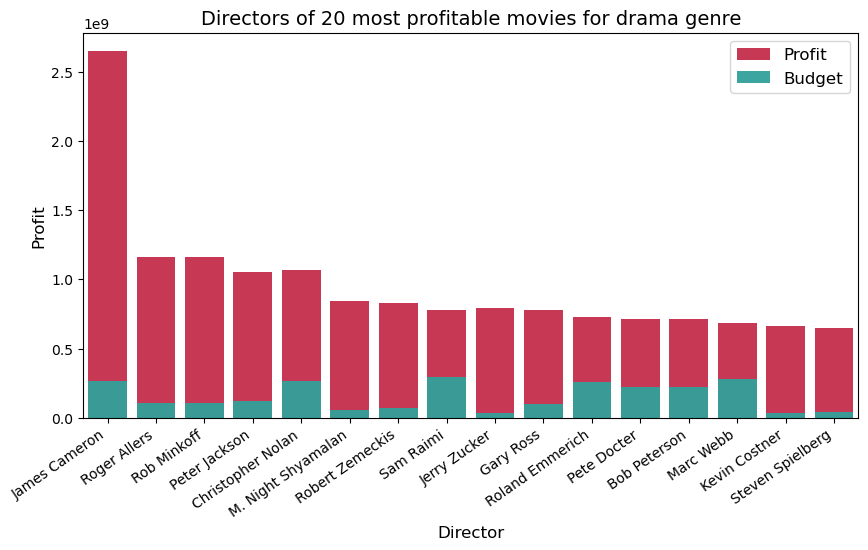

In [ ]:
# Most succesful directors in terms of profit
top_20_directors = df_all_top_profit[df_all_top_profit['genre']=='Drama'].dropna(how='all', subset=['directors']).drop_duplicates(['name', 'release_year', 'directors'])[0:20] # Remove NaN directors

plt.figure(figsize=(10,5))
sns.barplot(x=top_20_directors['directors'],y=top_20_directors['profit_modified'], 
            color='crimson', alpha=0.95, label='Profit', ci=None)
sns.barplot(x=top_20_directors['directors'],y=top_20_directors['budget_modified'], 
            color='lightseagreen', alpha=0.95, label='Budget', ci=None)
plt.xlabel('Director', fontsize=12)
plt.title("Directors of 20 most profitable movies for drama genre", fontsize=14)
plt.ylabel('Profit', fontsize=12)
plt.xticks(rotation=35, horizontalalignment='right', fontsize=10)
plt.legend(fontsize=12)

In [ ]:
print('pandas',pd.__version__,'networkX', nx.__version__,'pyvis', pyvis.__version__)

pandas 1.3.4 networkX 2.8.4 pyvis 0.3.1


Network graph:
Node size: feature score
Edge width: collaboration score

In [63]:
N = 15 # number of nodes 
top_N_directors = directors_score.sort_values(by='WScore',ascending=False)[0:N]

In [64]:
top_N_directors.head(15)

,directors,count,Score,WScore
17708,Woody Allen,40,9.332176,1282.952330
16602,Tim Burton,16,9.856922,1269.869484
0,'Weird Al' Yankovic,1,9.699204,1250.000000
10894,Martin Scorsese,34,9.326972,1229.125384
14124,Ridley Scott,20,9.622952,1219.704397
3017,Clint Eastwood,34,9.292390,1210.997391
2922,Chuck Jones,138,8.508252,1208.078283
17592,William Hanna,94,8.701730,1200.793136
7393,Jay Levey,3,9.422914,1200.000000
8636,Joseph Barbera,92,8.710104,1198.958727


In [67]:
ls_top_directors = top_N_directors['directors'].tolist()
director_pairs_score.rename({'directors': 'director_pair', 'WScore':'Score_pair', 'num_movies':'num_movies_pair'}, axis = 1,inplace=True)
#director_pairs_score.drop('Score',axis=1,inplace=True)

# Create a merged dataframe where we have only collaborations which include top directors
df = top_N_directors.merge(director_pairs_score,how='left',left_on='directors',right_on='directors0')
top_N_directors_graph = df[df['directors1'].isin(df['directors'])]
#del df

# Contains only top directors collaboration
print('Length of dataframe is: ',len(top_N_directors_graph))
top_N_directors_graph.head()


Length of dataframe is:  8


,directors,count,Score,WScore,directors_pair,num_movies_pair,Unweighted_score_pair,directors0,directors1,Score_pair
0,Woody Allen,40,9.332176,1282.952330,"(Woody Allen, Martin Scorsese)",2.0,9.540361,Woody Allen,Martin Scorsese,807.411396
2,'Weird Al' Yankovic,1,9.699204,1250.000000,"('Weird Al' Yankovic, Jay Levey)",2.0,9.699204,'Weird Al' Yankovic,Jay Levey,862.541589
24,Chuck Jones,138,8.508252,1208.078283,"(Chuck Jones, Joseph Barbera)",2.0,6.439311,Chuck Jones,Joseph Barbera,167.568839
33,Chuck Jones,138,8.508252,1208.078283,"(Chuck Jones, William Hanna)",2.0,6.439311,Chuck Jones,William Hanna,167.568839
37,William Hanna,94,8.701730,1200.793136,"(William Hanna, Joseph Barbera)",2.0,8.732376,William Hanna,Joseph Barbera,1745.524376


In [68]:
# Drop collaborations below threshold of number of collaboration
N_threshold = 1 # minimum number of collaborations to be considered
top_N_directors_graph.drop(top_N_directors_graph[top_N_directors_graph.num_movies_pair < N_threshold].index,inplace=True)

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [69]:
# Complete with top directors without collaboration
top_N_directors_graph = top_N_directors.merge(top_N_directors_graph,how='left',on=['directors','count','Score','WScore'])
top_N_directors_graph.sample(10)

,directors,count,Score,WScore,directors_pair,num_movies_pair,Unweighted_score_pair,directors0,directors1,Score_pair
3,Martin Scorsese,34,9.326972,1229.125384,NaN,NaN,NaN,NaN,NaN,NaN
6,Chuck Jones,138,8.508252,1208.078283,"(Chuck Jones, Joseph Barbera)",2.0,6.439311,Chuck Jones,Joseph Barbera,167.568839
7,Chuck Jones,138,8.508252,1208.078283,"(Chuck Jones, William Hanna)",2.0,6.439311,Chuck Jones,William Hanna,167.568839
4,Ridley Scott,20,9.622952,1219.704397,NaN,NaN,NaN,NaN,NaN,NaN
2,'Weird Al' Yankovic,1,9.699204,1250.000000,"('Weird Al' Yankovic, Jay Levey)",2.0,9.699204,'Weird Al' Yankovic,Jay Levey,862.541589
8,William Hanna,94,8.701730,1200.793136,"(William Hanna, Joseph Barbera)",2.0,8.732376,William Hanna,Joseph Barbera,1745.524376
13,Steven Spielberg,30,9.301101,1178.098577,NaN,NaN,NaN,NaN,NaN,NaN
1,Tim Burton,16,9.856922,1269.869484,NaN,NaN,NaN,NaN,NaN,NaN
0,Woody Allen,40,9.332176,1282.952330,"(Woody Allen, Martin Scorsese)",2.0,9.540361,Woody Allen,Martin Scorsese,807.411396
5,Clint Eastwood,34,9.292390,1210.997391,NaN,NaN,NaN,NaN,NaN,NaN


In [70]:
top_N_directors_graph.head(10)

,directors,count,Score,WScore,directors_pair,num_movies_pair,Unweighted_score_pair,directors0,directors1,Score_pair
0,Woody Allen,40,9.332176,1282.952330,"(Woody Allen, Martin Scorsese)",2.0,9.540361,Woody Allen,Martin Scorsese,807.411396
1,Tim Burton,16,9.856922,1269.869484,NaN,NaN,NaN,NaN,NaN,NaN
2,'Weird Al' Yankovic,1,9.699204,1250.000000,"('Weird Al' Yankovic, Jay Levey)",2.0,9.699204,'Weird Al' Yankovic,Jay Levey,862.541589
3,Martin Scorsese,34,9.326972,1229.125384,NaN,NaN,NaN,NaN,NaN,NaN
4,Ridley Scott,20,9.622952,1219.704397,NaN,NaN,NaN,NaN,NaN,NaN
5,Clint Eastwood,34,9.292390,1210.997391,NaN,NaN,NaN,NaN,NaN,NaN
6,Chuck Jones,138,8.508252,1208.078283,"(Chuck Jones, Joseph Barbera)",2.0,6.439311,Chuck Jones,Joseph Barbera,167.568839
7,Chuck Jones,138,8.508252,1208.078283,"(Chuck Jones, William Hanna)",2.0,6.439311,Chuck Jones,William Hanna,167.568839
8,William Hanna,94,8.701730,1200.793136,"(William Hanna, Joseph Barbera)",2.0,8.732376,William Hanna,Joseph Barbera,1745.524376
9,Jay Levey,3,9.422914,1200.000000,NaN,NaN,NaN,NaN,NaN,NaN


## Static Version

In [72]:
# Create node data:
node_data = pd.DataFrame({'name' : top_N_directors_graph['directors'].tolist(),
                      'score': top_N_directors_graph['Score'].tolist()}).drop_duplicates(subset='name')

In [76]:
#graph esthetic parameters
max_node_size = 1000
max_edge_width = 100

# normalize scores and define their width in the graph
nodes_scores = top_N_directors_graph.drop_duplicates(subset='directors')['WScore']
nodes_size = np.array(nodes_scores)
nodes_size = ((nodes_size - np.min(nodes_size)) / (np.max(nodes_size)-np.min(nodes_size)) + 1 if np.max(nodes_size)!=np.min(nodes_size) else nodes_size/np.max(nodes_size))
nodes_size *= max_node_size

#Rescale edge weights: 
weights = top_N_directors_graph['Score_pair'].dropna()
if len(weights) != 0:
    weights = ((weights - np.min(weights)) / (np.max(weights)-np.min(weights)) + 1 if np.max(weights)!=np.min(weights) else weights/np.max(weights))
    #weights *= max_edge_width
    top_N_directors_graph['weight_edge'] = weights

    # Create edge data:
    edge_data = pd.DataFrame({'source' : top_N_directors_graph['directors'].tolist(),
                          'target' : top_N_directors_graph['directors1'].tolist(),
                          'weight' : top_N_directors_graph['weight_edge'].tolist()})
    G = nx.from_pandas_edgelist(edge_data, 'source', 'target', True)
    
    # Remove node NaN
    G.remove_node(np.nan)
    # Remove edges to NaN
    G.remove_edges_from(list(zip(edge_data[edge_data['target'].isna()]['source'], edge_data[edge_data['target'].isna()]['target'])))


else:
    # Create edge data:
    edge_data = pd.DataFrame({'source' : top_N_directors_graph['directors'].tolist(),
                          'target' : top_N_directors_graph['directors'].tolist()})
    G = nx.from_pandas_edgelist(edge_data, 'source', 'target', None)
    
# Create node data:
node_data = pd.DataFrame({'name' : top_N_directors_graph['directors'].tolist(),
                      'score': top_N_directors_graph['Score'].tolist()}).drop_duplicates(subset='name')

G.add_nodes_from(node_data['name'])

In [429]:
#graph esthetic parameters
max_node_size = 1000
max_edge_width = 100

# normalize scores and define their width in the graph
nodes_scores = top_N_directors_graph.drop_duplicates(subset='directors')['WScore']
nodes_size = np.array(nodes_scores)
nodes_size = ((nodes_size - np.min(nodes_size)) / (np.max(nodes_size)-np.min(nodes_size)) + 1 if np.max(nodes_size)!=np.min(nodes_size) else nodes_size/np.max(nodes_size))
nodes_size *= max_node_size

#Rescale edge weights: 
weights = top_N_directors_graph['Score_pair'].dropna()
if len(weights) != 0:
    weights = ((weights - np.min(weights)) / (np.max(weights)-np.min(weights)) + 1 if np.max(weights)!=np.min(weights) else weights/np.max(weights))
    #weights *= max_edge_width
    top_N_directors_graph['weight_edge'] = weights

    # Create edge data:
    edge_data = pd.DataFrame({'source' : top_N_directors_graph['directors'].tolist(),
                          'target' : top_N_directors_graph['directors1'].tolist(),
                          'weight' : top_N_directors_graph['weight_edge'].tolist()})
    G = nx.from_pandas_edgelist(edge_data, 'source', 'target', True)
    
    # Remove node NaN
    G.remove_node(np.nan)
    # Remove edges to NaN
    G.remove_edges_from(list(zip(edge_data[edge_data['target'].isna()]['source'], edge_data[edge_data['target'].isna()]['target'])))


edge_data = pd.DataFrame({'source' : top_N_directors_graph['directors'].tolist(),
                      'target' : top_N_directors_graph['directors1'].tolist()})
G = nx.from_pandas_edgelist(edge_data, 'source', 'target', None)


In [379]:
top_N_directors_graph

,directors,count,Score,WScore,director_pair,num_movies_pair,directors0,directors1,Score_pair,weight_edge
0,John Bowker,1,4.149244,19.936085,NaN,NaN,NaN,NaN,NaN,NaN
1,Dennis Devine,1,4.151527,19.979984,NaN,NaN,NaN,NaN,NaN,NaN
2,Sean Skelding,1,4.151650,19.982367,NaN,NaN,NaN,NaN,NaN,NaN
3,Jason Kerr,1,4.151774,19.984750,NaN,NaN,NaN,NaN,NaN,NaN
4,Jim Carroll,1,4.151774,19.984750,NaN,NaN,NaN,NaN,NaN,NaN
5,Daniel Zirilli,1,4.151898,19.987134,NaN,NaN,NaN,NaN,NaN,NaN
6,Goldie Behl,1,4.152805,20.004606,NaN,NaN,NaN,NaN,NaN,NaN
7,Mark S. Jacobs,1,4.153109,20.010464,NaN,NaN,NaN,NaN,NaN,NaN
8,Peter Ney,1,4.153109,20.010464,NaN,NaN,NaN,NaN,NaN,NaN
9,Hans van Riet,1,4.153109,20.010464,NaN,NaN,NaN,NaN,NaN,NaN


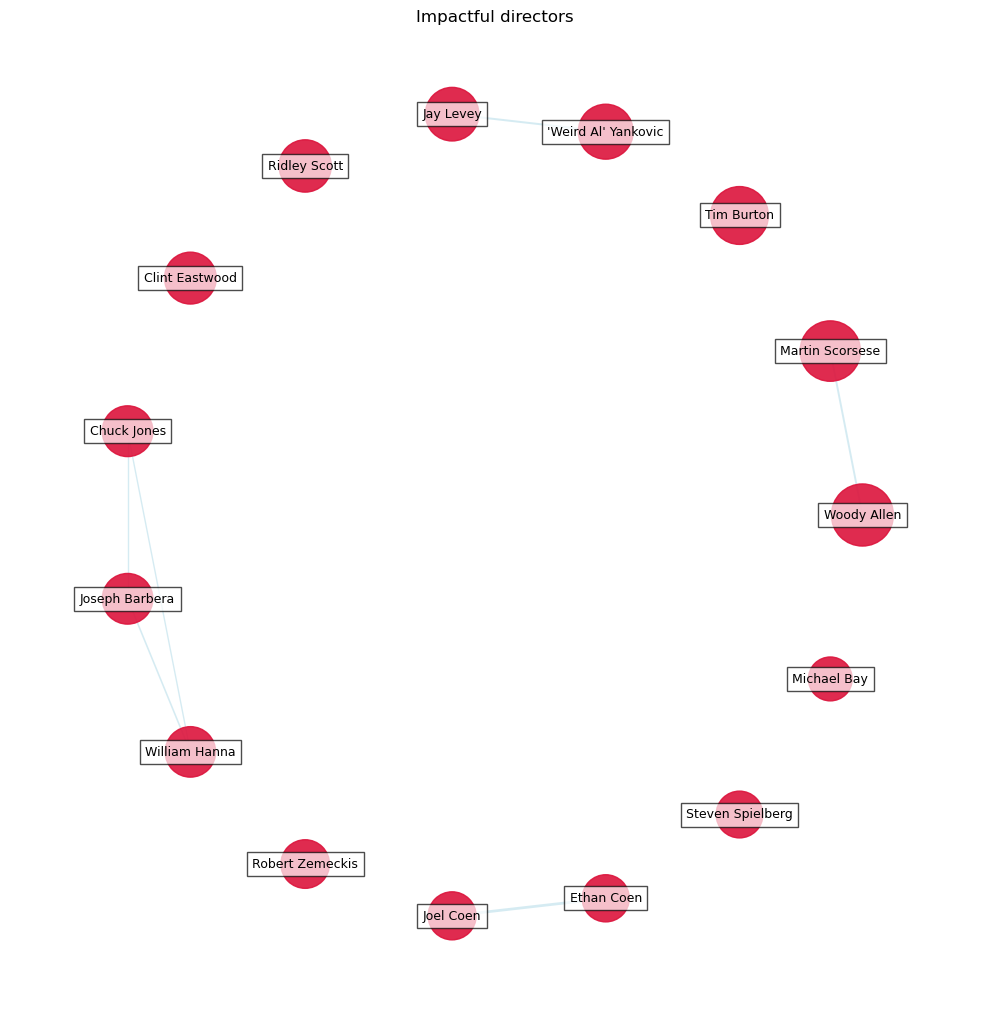

In [77]:
# Generate layout for visualization
pos = nx.circular_layout(G)
fig, ax = plt.subplots(figsize=(10, 10))

# Visualize graph components
nx.draw_networkx_nodes(G, pos, node_size=nodes_size, node_color='crimson', alpha=0.9)
if len(weights) != 0:
    widths = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edges(G,pos,edgelist = widths.keys(),width=list(widths.values()),edge_color='lightblue',alpha=0.5)


label_options = {"ec": "k", "fc": "white", "alpha": 0.7}
nx.draw_networkx_labels(G, pos, font_size=18/20*10, bbox=label_options)

# Resize figure for label readibility
ax.margins(0.1, 0.05)
fig.tight_layout()
plt.axis("off")
plt.title("Impactful directors")

#plt.savefig('../output/network_sparse.png', dpi = 500)
plt.show()


Check why: 
- no links

- finish function

## Animated version

In [171]:

# Create vis network
net = Network(notebook=True)
# Load the networkx graph
net.from_nx(G)
# Show
net.show("example.html")

NameError: name 'Network' is not defined

## Create function to generalise to all cases:

In [ ]:
#graph esthetic parameters
max_node_size = 1000
max_edge_width = 100

# normalize scores and define their width in the graph
nodes_scores = top_N_directors_graph.drop_duplicates(subset='directors')['WScore']
nodes_size = np.array(nodes_scores)
nodes_size = ((nodes_size - np.min(nodes_size)) / (np.max(nodes_size)-np.min(nodes_size)) + 1 if np.max(nodes_size)!=np.min(nodes_size) else nodes_size/np.max(nodes_size))
nodes_size *= max_node_size

#Rescale edge weights: 
weights = top_N_directors_graph['Score_pair'].dropna()
if len(weights) != 0:
    weights = ((weights - np.min(weights)) / (np.max(weights)-np.min(weights)) + 1 if np.max(weights)!=np.min(weights) else weights/np.max(weights))
    #weights *= max_edge_width
    top_N_directors_graph['weight_edge'] = weights

    # Create edge data:
    edge_data = pd.DataFrame({'source' : top_N_directors_graph['directors'].tolist(),
                          'target' : top_N_directors_graph['directors1'].tolist(),
                          'weight' : top_N_directors_graph['weight_edge'].tolist()})
    G = nx.from_pandas_edgelist(edge_data, 'source', 'target', True)
    
    # Remove node NaN
    G.remove_node(np.nan)
    # Remove edges to NaN
    G.remove_edges_from(list(zip(edge_data[edge_data['target'].isna()]['source'], edge_data[edge_data['target'].isna()]['target'])))


else:
    # Create edge data:
    edge_data = pd.DataFrame({'source' : top_N_directors_graph['directors'].tolist(),
                          'target' : top_N_directors_graph['directors'].tolist()})
    G = nx.from_pandas_edgelist(edge_data, 'source', 'target', None)
    
# Create node data:
node_data = pd.DataFrame({'name' : top_N_directors_graph['directors'].tolist(),
                      'score': top_N_directors_graph['Score'].tolist()}).drop_duplicates(subset='name')

G.add_nodes_from(node_data['name'])

# Generate layout for visualization
pos = nx.circular_layout(G)
fig, ax = plt.subplots(figsize=(10, 10))

# Visualize graph components
nx.draw_networkx_nodes(G, pos, node_size=nodes_size, node_color='crimson', alpha=0.9)
if len(weights) != 0:
    widths = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edges(G,pos,edgelist = widths.keys(),width=list(widths.values()),edge_color='lightblue',alpha=0.5)


label_options = {"ec": "k", "fc": "white", "alpha": 0.7}
nx.draw_networkx_labels(G, pos, font_size=18/20*10, bbox=label_options)

# Resize figure for label readibility
ax.margins(0.1, 0.05)
fig.tight_layout()
plt.axis("off")
plt.title("Impactful directors")

#plt.savefig('../output/network_sparse.png', dpi = 500)
plt.show()



In [6]:
def draw_bubble_graph(df_score, df_pair_score, feature, genre, N, N_threshold):
    # df_score: dataframe with score of independent features
    # df_pair_score: dataframe with score of paired features
    # feature: string name of column in dataframe to process 'directors', 'actor_name', 'genre'
    # genre: movie genre subset to plot
    # N: number of feature points to include
    # N_threshold: minimum number of collaborations to be considered
    
    # Remove empty entries:
    df_score = df_score.drop(index=df_score[df_score[feature] == ''].index,axis=0)
    # Take top N individuals:
    top_N = df_score.sort_values(by='WScore',ascending=False)[0:N]
    ls_top = top_N[feature].tolist()
    
    # Treat collaborations:
    df_pair_score.rename({feature: feature +'_pair', 'WScore':'Score_pair', 'num_movies':'num_movies_pair','Score':'Unweighted_score_pair'}, axis = 1,inplace=True)
    # Create a merged dataframe where we have only collaborations which include top features
    df = top_N.merge(df_pair_score,how='left',left_on=feature, right_on= feature +'0')
    top_N_graph = df[df[feature +'1'].isin(df[feature])]
    #del df
    
    # Drop collaborations below threshold of number of collaboration
    top_N_graph.drop(top_N_graph[top_N_graph.num_movies_pair < N_threshold].index,inplace=True)
    
    # Complete with top individuals without collaboration
    top_N_graph = top_N.merge(top_N_graph,how='left',on=[feature,'count','Score','WScore'])
    top_N_graph.sample(5)
    
    # Create network graph: 
    
    #graph esthetic parameters
    max_node_size = 1000
    max_edge_width = 5

    # normalize scores and define their width in the graph
    nodes_scores = top_N_graph.drop_duplicates(subset=feature)['WScore']
    nodes_size = np.array(nodes_scores)
    nodes_size = ((nodes_size - np.min(nodes_size)) / (np.max(nodes_size)-np.min(nodes_size)) + 1 if np.max(nodes_size)!=np.min(nodes_size) else nodes_size/np.max(nodes_size))
    nodes_size *= max_node_size

    #Rescale edge weights: 
    weights = top_N_graph['Score_pair'].dropna()
    if len(weights) != 0:
        weights = ((weights - np.min(weights)) / (np.max(weights)-np.min(weights)) + 1 if np.max(weights)!=np.min(weights) else weights/np.max(weights))
        weights *= max_edge_width
        top_N_graph['weight_edge'] = weights

        # Create edge data:
        edge_data = pd.DataFrame({'source' : top_N_graph[feature].tolist(),
                              'target' : top_N_graph[feature +'1'].tolist(),
                              'weight' : top_N_graph['weight_edge'].tolist()})
        
        G = nx.from_pandas_edgelist(edge_data, 'source', 'target', True)
        # Remove edges to NaN
        G.remove_edges_from(list(zip(edge_data[edge_data['target'].isna()]['source'], edge_data[edge_data['target'].isna()]['target'])))
    
    
    edge_data = pd.DataFrame({'source' : top_N_graph[feature].tolist(),
                              'target' : top_N_graph[feature].tolist()})
    G = nx.from_pandas_edgelist(edge_data, 'source', 'target', None)


    # Remove node NaN
    if np.nan in G:
        G.remove_node(np.nan)
            

    # Generate layout for visualization
    pos = nx.circular_layout(G)
    fig, ax = plt.subplots(figsize=(10, 10))


    # Visualize graph components
    nx.draw_networkx_nodes(G, pos, node_size=nodes_size, node_color='crimson', alpha=0.9)
    if len(weights) != 0:
        widths = nx.get_edge_attributes(G, 'weight')
        nx.draw_networkx_edges(G,pos,edgelist = widths.keys(),width=list(widths.values()),edge_color='lightblue',alpha=0.5)



    label_options = {"ec": "k", "fc": "white", "alpha": 0.7}
    nx.draw_networkx_labels(G, pos, font_size=18/20*10, bbox=label_options)

    # Resize figure for label readibility
    ax.margins(0.1, 0.05)
    fig.tight_layout()
    plt.axis("off")
    plt.title("Impactful " + feature)

    #plt.savefig('../output/network_sparse.png', dpi = 500)
    plt.show()



In [7]:
draw_bubble_graph(df_score=directors_score, df_pair_score=director_pairs_score, feature='directors', genre='a', N=15, N_threshold=1)


NameError: name 'directors_score' is not defined

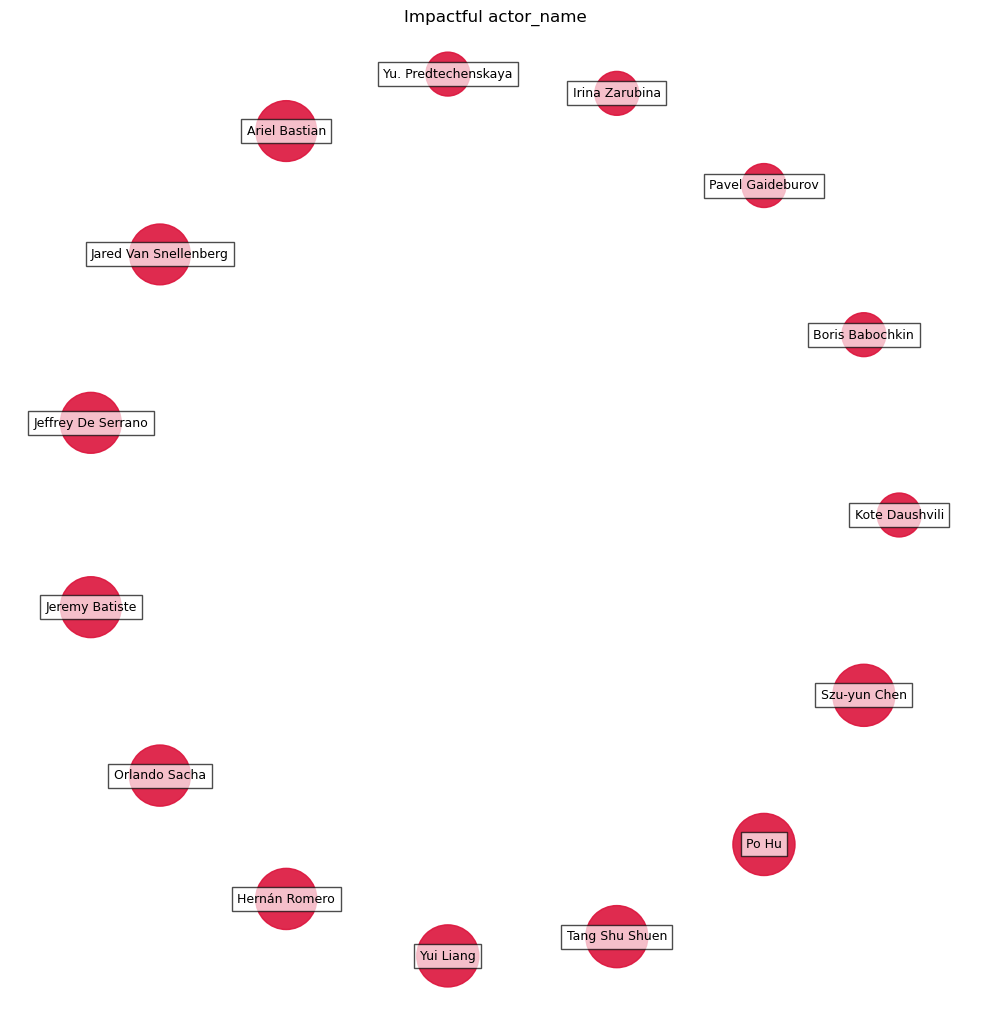

In [447]:
draw_bubble_graph(actors_score ,actor_pairs_score, 'actor_name', 'a', 15,1)

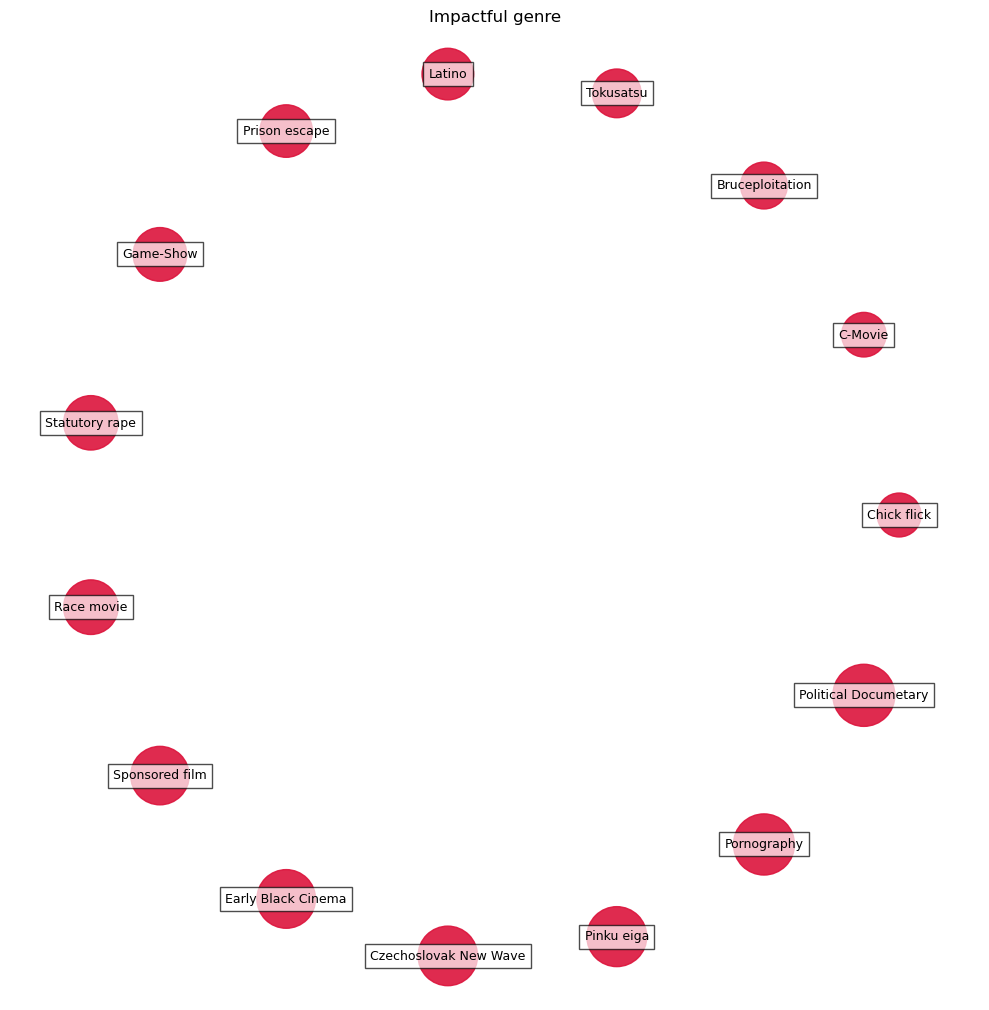

In [453]:
draw_bubble_graph(genre_score ,genre_pairs_score, 'genre', 'insertgenre', 15,1)

## Create bubble graphs according to genre

In [254]:
top_genre

['Drama',
 'Comedy',
 'Romance Film',
 'Action',
 'Black-and-white',
 'Thriller',
 'Short Film',
 'World cinema',
 'Crime Fiction',
 'Indie',
 'Documentary',
 'Horror',
 'Silent film',
 'Adventure',
 'Family Film']

In [255]:
df_all.head()

,freebase_id,name,runtime,languages,countries,release_year,isAdult,directors,writers,WR,...,S2,S3,S4,Score,actors_score,directors_score,genres_score,normalised_score,Score_inversed,actor_name
0,/m/0bth54,Avatar,178.0,"[English, Spanish]","[United States of America, United Kingdom]",2009.0,0.0,[James Cameron],[James Cameron],7.799997,...,1,1,46813,10.000000,8.170079,9.296045,6.606622,0.000000,1.000000,"[Wes Studi, Sam Worthington, Zoe Saldana, Sigo..."
1,/m/07cz2,The Matrix,135.0,[English],"[United States of America, Australia]",1999.0,0.0,"[Lana Wachowski, Lilly Wachowski]","[Lilly Wachowski, Lana Wachowski]",8.699995,...,91,121,1,9.999772,7.760669,9.748930,6.851679,0.000067,0.999977,"[Belinda McClory, Keanu Reeves, Laurence Fishb..."
2,/m/0dr_4,Titanic,194.0,"[Italian, English, French, Swedish, Russian, G...",[United States of America],1997.0,0.0,[James Cameron],[James Cameron],7.899996,...,2,2,46814,9.999758,7.790698,9.296045,6.883182,0.000024,0.999976,"[Kate Winslet, Leonardo DiCaprio, Billy Zane, ..."
3,/m/0h5ndj,The Ambassador,27.0,[English],[United States of America],2008.0,0.0,[Rob Sitch],"[Santo Cilauro, Tom Gleisner, Rob Sitch]",9.467126,...,2465,8393,50618,9.999758,8.065421,9.432452,6.306592,0.000024,0.999976,[Will Arnett]
4,/m/062zm5h,The Avengers,137.0,"[Russian, English]",[United States of America],2012.0,0.0,[Joss Whedon],"[Joss Whedon, Zak Penn]",7.999996,...,3,3,14167,9.999517,8.342349,9.714670,6.151706,0.000048,0.999952,"[Clark Gregg, Robert Downey Jr., Chris Evans, ..."


In [15]:
genre = 'Thriller'
df_genres = df_all.explode('genre').reset_index()
df_genre = df_genres[df_genres['genre'] == genre]
idx_df_all = df_genre['index'].values

# Compute feature score for given genre:
actors_score = score_movie_element(df_all.iloc[idx_df_all], 'actor_name')
directors_score = score_movie_element(df_all.iloc[idx_df_all], 'directors')
genre_score = score_movie_element(df_all.iloc[idx_df_all], 'genre')

# Compute score of feature pairs for given genre:
actor_pairs_score = score_movie_element_groups(df_all.iloc[idx_df_all], 'actor_name')
director_pairs_score = score_movie_element_groups(df_all, 'directors')
genre_pairs_score = score_movie_element_groups(df_all.iloc[idx_df_all], 'genre')

# Only keep genre of interest:
genre_pairs_score = genre_pairs_score[(genre_pairs_score['genre0'] == genre) | (genre_pairs_score['genre1'] == genre)]


# Weight feature score by number of movies: 
actors_score = weighted_rating(actors_score, 'Score', 'count', 'WScore')
director_score = weighted_rating(directors_score, 'Score', 'count', 'WScore')
genre_score = weighted_rating(genre_score, 'Score', 'count', 'WScore')


# Weight feature pairs score by number of movies: 
actor_pairs_score = weighted_rating(actor_pairs_score, 'Score', 'num_movies', 'WScore')
director_pairs_score = weighted_rating(director_pairs_score, 'Score', 'num_movies', 'WScore')
genre_pairs_score = weighted_rating(genre_pairs_score, 'Score', 'num_movies', 'WScore')



In [29]:
director_pairs_score.iloc[0:10000,1] = 2

In [33]:
director_score

,directors,count,Score,WScore
0,'Weird Al' Yankovic,1,9.699204,595.262103
1,50 Cent,1,4.588225,29.808679
2,A. Bhimsingh,16,8.377174,662.497269
3,A. Dean Bell,1,7.399822,201.673596
4,A. Edward Sutherland,27,7.071091,383.310267
...,...,...,...,...
17943,Özlem Sulak,1,5.289086,52.636421
17944,Øystein Karlsen,1,9.530811,554.987570
17945,Øyvind Vennerød,2,7.282784,225.014840
17946,Ümit Ünal,1,7.251950,186.029987


In [35]:
director_pairs_score[director_pairs_score['directors0'] == "'Weird Al' Yankovic"]

,directors_pair,num_movies_pair,Unweighted_score_pair,directors0,directors1,Score_pair
0,"('Weird Al' Yankovic, Jay Levey)",2,9.699204,'Weird Al' Yankovic,Jay Levey,862.541589


In [54]:
director_score.loc[director_score[director_score['directors'] == "Jay Levey"].index,'WScore']= 1200

In [55]:
director_score.loc[director_score[director_score['directors'] == "'Weird Al' Yankovic"].index,'WScore']= 1250

In [56]:
director_score.sort_values(by='WScore',ascending=False)

,directors,count,Score,WScore
17708,Woody Allen,40,9.332176,1282.952330
16602,Tim Burton,16,9.856922,1269.869484
0,'Weird Al' Yankovic,1,9.699204,1250.000000
10894,Martin Scorsese,34,9.326972,1229.125384
14124,Ridley Scott,20,9.622952,1219.704397
...,...,...,...,...
7337,Jason Kerr,1,4.151774,19.984750
7811,Jim Carroll,1,4.151774,19.984750
15242,Sean Skelding,1,4.151650,19.982367
3978,Dennis Devine,1,4.151527,19.979984


In [59]:
director_score.sort_values(by='WScore')[0:25]

,directors,count,Score,WScore
8087,John Bowker,1,4.149244,19.936085
3978,Dennis Devine,1,4.151527,19.979984
15242,Sean Skelding,1,4.151650,19.982367
7337,Jason Kerr,1,4.151774,19.984750
7811,Jim Carroll,1,4.151774,19.984750
3407,Daniel Zirilli,1,4.151898,19.987134
5870,Goldie Behl,1,4.152805,20.004606
10798,Mark S. Jacobs,1,4.153109,20.010464
13033,Peter Ney,1,4.153109,20.010464
6211,Hans van Riet,1,4.153109,20.010464


In [32]:
director_pairs_score

,directors_pair,num_movies_pair,Unweighted_score_pair,directors0,directors1,Score_pair
0,"('Weird Al' Yankovic, Jay Levey)",2,9.699204,'Weird Al' Yankovic,Jay Levey,862.541589
1,"(A. Edward Sutherland, Dorothy Arzner)",2,7.098152,A. Edward Sutherland,Dorothy Arzner,247.409748
2,"(A. Edward Sutherland, Edmund Goulding)",2,7.098152,A. Edward Sutherland,Edmund Goulding,247.409748
3,"(A. Edward Sutherland, Lothar Mendes)",2,7.098152,A. Edward Sutherland,Lothar Mendes,247.409748
4,"(A. Edward Sutherland, Victor Heerman)",2,7.098152,A. Edward Sutherland,Victor Heerman,247.409748
...,...,...,...,...,...,...
9999,"(Åsa Sjöström, Mari Marten-Bias Wahlgren)",2,7.073323,Åsa Sjöström,Mari Marten-Bias Wahlgren,243.966180
10000,"(Étienne Arnaud, Herbert Blaché)",1,4.863872,Étienne Arnaud,Herbert Blaché,54.546144
10001,"(Ömer Faruk Sorak, Yilmaz Erdogan)",1,9.592081,Ömer Faruk Sorak,Yilmaz Erdogan,825.062667
10002,"(Özgür Dogan, Orhan Eskiköy)",1,8.989815,Özgür Dogan,Orhan Eskiköy,636.559167


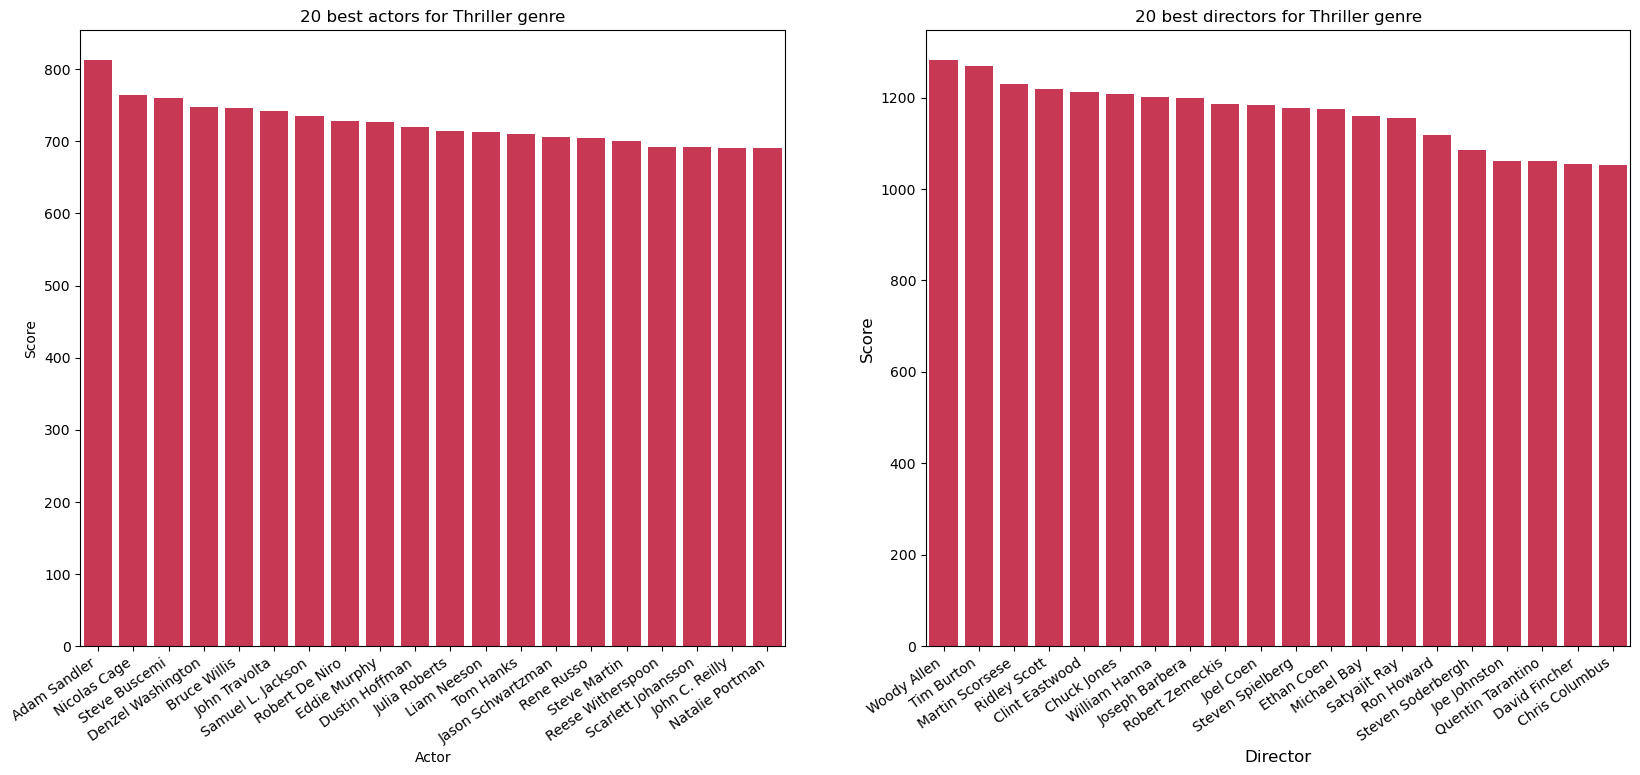

In [336]:
fig, ax = plt.subplots(1,2,figsize= (20,8)) 

# Subplot 1 ----------
sbplt1 = ax[0]
top_20_actors = actors_score.sort_values(by='WScore', ascending=False)[0:20]

sns.barplot(ax= sbplt1, x=top_20_actors['actor_name'],y=top_20_actors['WScore'], 
            color='crimson', alpha=0.95, ci=None);
sbplt1.set_xlabel('Actor');
sbplt1.set_ylabel('Score');
sbplt1.set_title("20 best actors for " + genre +" genre");
sbplt1.set_xticklabels(top_20_actors['actor_name'],rotation=35, horizontalalignment='right');

# Subplot 2 ----------
sbplt2 = ax[1]

top_20_directors = director_score.sort_values(by='WScore', ascending=False)[0:20]

sns.barplot(ax= sbplt2, x=top_20_directors['directors'],y=top_20_directors['WScore'], 
            color='crimson', alpha=0.95, ci=None);
sbplt2.set_xlabel('Director', fontsize=12);
sbplt2.set_ylabel('Score', fontsize=12);
sbplt2.set_title("20 best directors for " + genre +" genre");
sbplt2.set_xticklabels(top_20_directors['directors'],rotation=35, horizontalalignment='right');

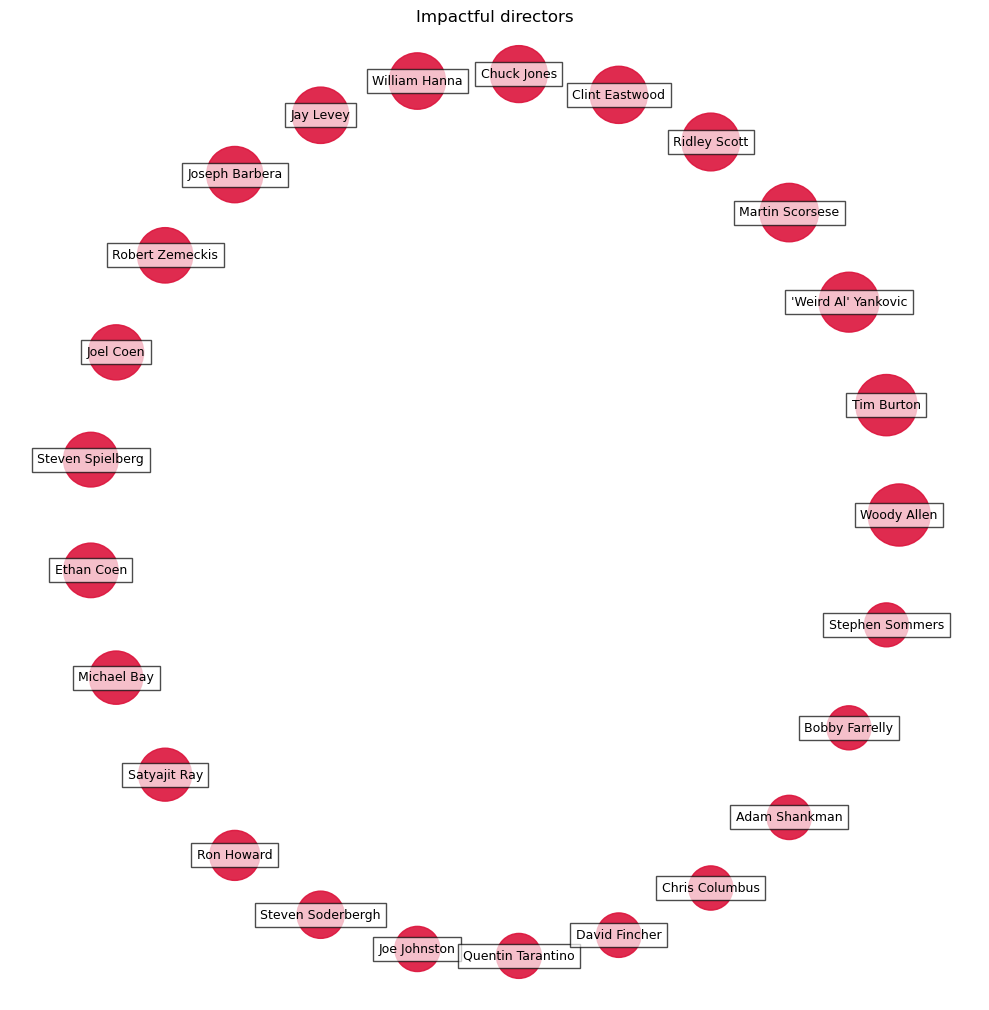

In [62]:
draw_bubble_graph(directors_score ,director_pairs_score, 'directors', 'a', 25,1)

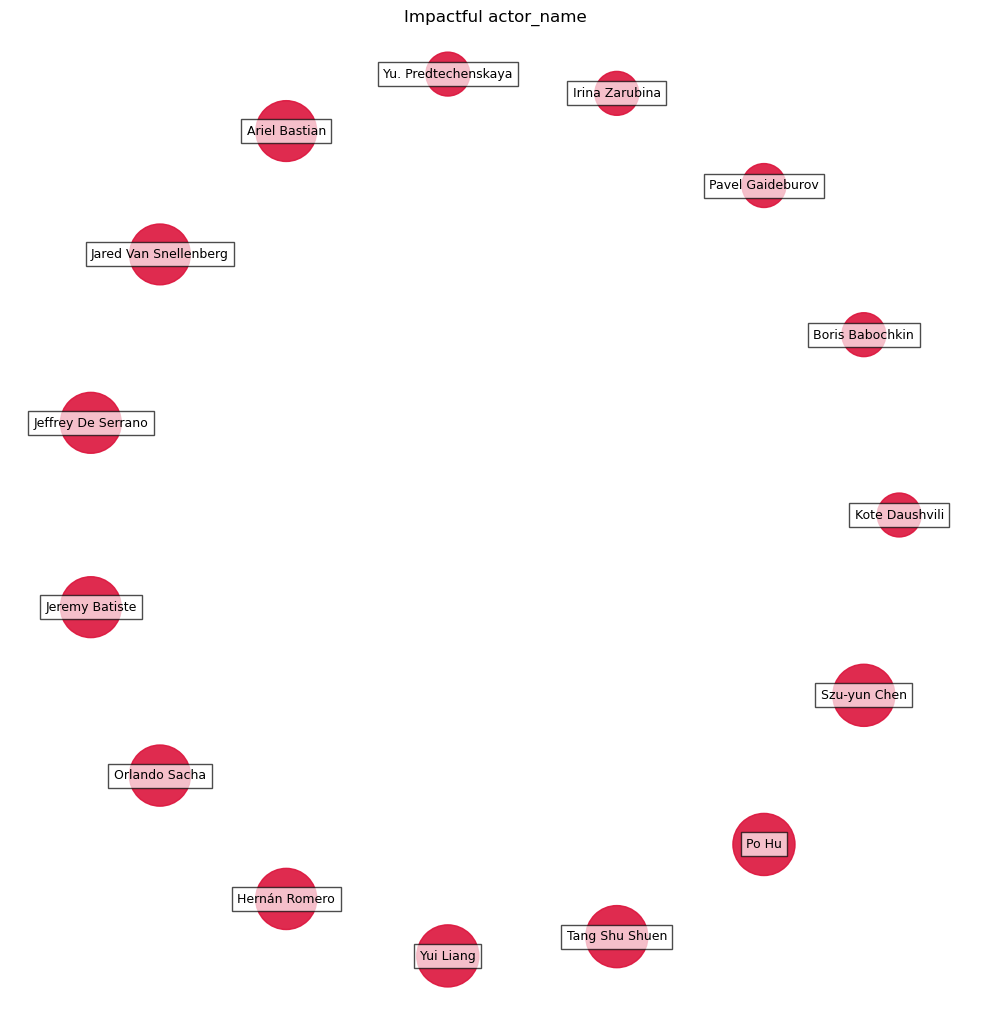

In [438]:
draw_bubble_graph(actors_score ,actor_pairs_score, 'actor_name', 'a', 15)

## Regression analysis

In [281]:
df_all_expanded.head()

,freebase_id,name,runtime,languages,countries,release_year,isAdult,directors,writers,WR,...,S2,S3,S4,Score,actors_score,directors_score,genres_score,normalised_score,Score_inversed,actor_name
0,/m/0bth54,Avatar,178.0,English,United States of America,2009.0,0.0,James Cameron,James Cameron,7.799997,...,1,1,46813,10.0,8.170079,9.296045,6.606622,0.0,1.0,"['Wes Studi', 'Sam Worthington', 'Zoe Saldana'..."
0,/m/0bth54,Avatar,178.0,English,United Kingdom,2009.0,0.0,James Cameron,James Cameron,7.799997,...,1,1,46813,10.0,8.170079,9.296045,6.606622,0.0,1.0,"['Wes Studi', 'Sam Worthington', 'Zoe Saldana'..."
0,/m/0bth54,Avatar,178.0,Spanish,United States of America,2009.0,0.0,James Cameron,James Cameron,7.799997,...,1,1,46813,10.0,8.170079,9.296045,6.606622,0.0,1.0,"['Wes Studi', 'Sam Worthington', 'Zoe Saldana'..."
0,/m/0bth54,Avatar,178.0,Spanish,United Kingdom,2009.0,0.0,James Cameron,James Cameron,7.799997,...,1,1,46813,10.0,8.170079,9.296045,6.606622,0.0,1.0,"['Wes Studi', 'Sam Worthington', 'Zoe Saldana'..."
0,/m/0bth54,Avatar,178.0,English,United States of America,2009.0,0.0,James Cameron,James Cameron,7.799997,...,1,1,46813,10.0,8.170079,9.296045,6.606622,0.0,1.0,"['Wes Studi', 'Sam Worthington', 'Zoe Saldana'..."


In [282]:
list(df_all_expanded.columns)

['freebase_id',
 'name',
 'runtime',
 'languages',
 'countries',
 'release_year',
 'isAdult',
 'directors',
 'writers',
 'WR',
 'genre',
 'release_day',
 'release_month',
 'profit_modified',
 'total_gross_modified',
 'budget_modified',
 'pageviews',
 'total_gross_modified_std',
 'total_gross_modified_norm',
 'S1',
 'S2',
 'S3',
 'S4',
 'Score',
 'actors_score',
 'directors_score',
 'genres_score',
 'normalised_score',
 'Score_inversed',
 'actor_name']

In [ ]:
mod = smf.ols(formula='Score ~ runtime + release_year + release_month + actors_score + directors_score + genres_score', data=df_all)
np.random.seed(2)
res = mod.fit()
res.summary()